In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys, json
import gc

import time

from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta,date
#%matplotlib inline

#es = Elasticsearch(hosts="https://localhost:9200")

In [2]:
import requests, json, os
from itertools import groupby

In [3]:
import numpy as np
import pandas as pd
import os
import keras
import keras.callbacks as cb
from keras.models import Sequential,Model,model_from_json
from keras.layers import Dense,Activation,Dropout,Input
#from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import ELU, PReLU, LeakyReLU

from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM


2023-04-23 13:11:42.413165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64::/home/bockjoo/services/external/webisoget-2.8.4/lib:/usr/lib/x86_64-linux-gnu
2023-04-23 13:11:42.413204: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-23 13:11:43.279961: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64::/home/bockjoo/services/external/webisoget-2.8.4/lib:/usr/lib/x86_64-linux-gnu
2023-04-23 13:11:43.280085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys, json

import time

from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta,date
#%matplotlib inline

#es = Elasticsearch(hosts="https://localhost:9200")

In [5]:
import requests, json, os
from itertools import groupby

In [6]:
shortURL = "https://monit-opensearch.cern.ch/dashboards/goto/e0b026c5a3dbb183ceb31062397f7627?security_tenant=global"
# Long URL https://monit-opensearch.cern.ch/dashboards/app/discover#/?_g=(filters:!(),refreshInterval:(pause:!t,value:0),time:(from:now-15m,to:now))&_a=(columns:!(_type,data.end_time,data.server_site),filters:!(),index:AWnEUpm3NZZoUCd3kmbV,interval:auto,query:(language:kuery,query:''),sort:!())

In [7]:
#def get_rucio_transfers (dbid=9269, size=10000, gte="now-30m/m",lte="now",unique_f = "metadata.timestamp", tie_breaker_id = "data.request_id"):
def get_rucio_transfers (dbid=9231, size=10000, gte="now-30m/m",lte="now",
                         unique_f = "metadata.timestamp", 
                         tie_breaker_id="metadata.kafka_timestamp"):
    
    url = "https://monit-grafana.cern.ch/api/datasources/proxy/"+str(dbid)+"/_msearch"

    index_name = "monit_prod_cms_rucio_raw_events*" # RUCIO Transfers
    index_name = "monit_prod_cms_raw_aaa-ng*"       # XRD Collector Monitoring
    payload_index_props = {
        "search_type": "query_then_fetch",
        "index": [ index_name ],
        "ignore_unavailable":True
    }

    # See /opt/cms/services/HammerCloudXrootdMonitoring/monit_prod_cms_rucio_raw_events_source_dest_sort_search.json.in
    payload_query = {
        "query": {
            "bool": {
                "filter": [
                    {
                        "range": {
                            "metadata.timestamp": {
                                "gte": "@@gte@@",
                                "lte": "@@lte@@",
                                "format": "epoch_millis"
                            }
                        }
                    },
                    {
                        "query_string": {
                            "analyze_wildcard":True,
                            "query": "data.server_site: *"
                        }
                    }
                ]
            }
        },
        "from": 0,
        "size": 10000,
        "sort": []
    }

    payload_query["query"]["bool"]["filter"][0]["range"]["metadata.timestamp"]["gte"] = gte
    payload_query["query"]["bool"]["filter"][0]["range"]["metadata.timestamp"]["lte"] = lte
    payload_query["sort"].append({unique_f : "desc"})
    payload_query["sort"].append({tie_breaker_id : "asc"})

    #print (payload_query)


    payload = json.dumps(payload_index_props) + " \n" + json.dumps(payload_query) + "\n"
    headers = {
      'Content-Type': 'application/json',
      'Authorization': 'Bearer {}'.format(os.environ["GRAFANA_VIEWER_TOKEN"])
    }
    result = requests.request("POST", url, headers=headers, data = payload).json()
    results = []
    results.append(result)
    nhits = result["responses"][0]["hits"]["total"]["value"]
    i=0
    print (i,nhits," vs ",len(result["responses"][0]["hits"]["hits"]), " Searching next hits...", )
    while len(result["responses"][0]["hits"]["hits"]) == size :
       i = i + 1
       #print (i," Searching next hits...")
       payload_query["search_after"] = result["responses"][0]["hits"]["hits"][nhits-1]["sort"]
       payload = json.dumps(payload_index_props) + " \n" + json.dumps(payload_query) + "\n"
       result = requests.request("POST", url, headers=headers, data = payload).json()
       results.append(result)
       nhits = result["responses"][0]["hits"]["total"]["value"]
       print (i,nhits," vs ",len(result["responses"][0]["hits"]["hits"]), " Searching next hits...", )
    return results

In [8]:
def extract_data( results ) :
    from datetime import datetime
    events = []
    for j in results:
       #print(len(j['responses']))
       for resp in j['responses'] :
            # DEBUG print(resp.keys()) # dict_keys(['took', 'timed_out', '_shards', 'hits', 'status'])
            #scroll_size = resp['hits']['total']['value']
            #print('total hits in {} : {}'.format('index',scroll_size))
            for hit in resp['hits']['hits']:
                # DEBUG print(hit.keys())
                thedata = hit['_source']['data']
                thedata['metadata.timestamp'] = datetime.fromtimestamp(int(hit['_source']['metadata']['timestamp'] / 1000))
                thedata['Ymd'] = datetime.fromtimestamp( int( hit['_source']['metadata']['timestamp'] / 1000) ).strftime('%Y-%m-%d')
                #events.append(hit['_source']['data'])
                events.append( thedata )
                #break
            #break
       #break

    return pd.DataFrame(events)

In [9]:
def create_preprocessed (input_file) :
    data = pd.read_csv(input_file, low_memory=False)
    data = data[data['submitted_at'].notna()]
    data = data[data['started_at'].notna()]
    data = preprocess_data(data, use_cache=False)
    if not os.path.isdir('./preprocessed') :
        os.makedirs('./preprocessed')
    preprocessed_file = './preprocessed/'+input_file.replace('.csv','_preprocessed.csv')
    data.to_csv(preprocessed_file, index=False)
    
    print('Saved {} data to disk as {} !!'.format("rucio transfer", preprocessed_file))
    return preprocessed_file

In [10]:
def create_csv (results, file_name='rucio_transfers.csv') :
    events = extract_data( results ) 
    #plot_data_stats(tmp_data)
    #file_name = (index+'.csv')
    #         hdf.put(index, tmp_data, format='table', data_columns=True)
    events.to_csv(file_name)
    print('Saved {} data to disk as {} !!'.format("rucio transfer", file_name))
    print('Preprocessing {}...'.format(file_name))
    preprocessed_file = create_preprocessed(file_name)
    
    return file_name

In [11]:
def create_raw_csv (results, file_name='/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata.csv') :
    events = extract_data( results ) 
    #plot_data_stats(tmp_data)
    #file_name = (index+'.csv')
    #         hdf.put(index, tmp_data, format='table', data_columns=True)
    events.to_csv(file_name)
    print('Saved {} data to disk as {} !!'.format("XRD Collector Monitoring Data", file_name))
    #print('Preprocessing {}...'.format(file_name))
    #preprocessed_file = create_preprocessed(file_name)
    
    return file_name

In [12]:
def preprocess_data(xrdcoll_data, site='ALL',
                    operation='ALL', throughput=0, client_domain='ALL',
                    user_protocol='ALL', use_cache=False):
    from datetime import datetime
    
    fields_to_drop = ['Unnamed: 0','server_domain','unique_id','file_lfn','write_bytes',
                     'write_average','write_bytes_at_close','write_max','write_min','write_operations',
                     'write_sigma','metadata','user','user_dn','server_ip','read_single_bytes',
                     'read_vector_bytes','read_vector_average','read_vector_count_average','read_vector_count_max',
                     'read_single_min','read_single_operations','read_single_sigma','read_vector_count_min',
                     'read_vector_count_sigma','read_vector_max','read_vector_min','read_vector_operations',
                     'read_vector_sigma','read_average','read_bytes_at_close','read_max','read_min','read_operations',
                     'read_sigma','read_single_average','read_single_max','fallback','vo']
    
    timestamps = ['start_time', 'end_time', 'metadata.timestamp', 'Ymd', 'YmdHMS']

    xrdcoll_data = xrdcoll_data.drop(fields_to_drop, axis=1)
    xrdcoll_data['YmdHMS'] = pd.to_datetime(xrdcoll_data['start_time']/1000, unit='s')
    xrdcoll_data = xrdcoll_data.sort_values(by='YmdHMS') # ('submitted_at')
    
    # Reindex data with 'submitted_at timestamp'
    xrdcoll_data.index = pd.DatetimeIndex(xrdcoll_data['YmdHMS']) # ['submitted_at'])
    
    #remove all timestamp columns
    xrdcoll_data = xrdcoll_data.drop(timestamps, axis=1)  
    xrdcoll_data[f'read_btyes/file_size'] = xrdcoll_data['read_bytes'].div(xrdcoll_data['file_size'])

    if not 'ALL' in site:
       xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['site_name'] == site]
    if not 'ALL' in operation:
       xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['operation'] == operation]
    if throughput > 0 : 
       xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['throughput'] > throughput]
    if not 'ALL' in user_protocol : 
       xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['user_protocol'] == user_protocol ]
    if not 'ALL' in client_domain : 
       xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['client_domain'] == client_domain]
    
    more_fields_to_drop = ['site_name','client_domain','client_host','server_host','server_site','user_protocol','operation']
    #if not target in fields_to_drop: fields_to_drop.append(target)
            
    #y=xrdcoll_data[target]
    #X = xrdcoll_data.drop(more_fields_to_drop, axis=1)

    return xrdcoll_data.drop(more_fields_to_drop, axis=1) # xrdcoll_data

## Choose Features and Target

In [13]:
def select_features_and_target ( xrdcoll_data, features = ['file_size','read_bytes','ipv6', 'server_host'], target='operation_time' ):
    fields_to_drop = [] # 'site_name','client_host','server_host','server_site','user_protocol','operation']
    if not target in fields_to_drop: fields_to_drop.append(target)
            
    y = xrdcoll_data[target]
    X_full = xrdcoll_data.drop(fields_to_drop, axis=1)
    X = X_full[features].copy()
    
    return X,y

In [14]:
def train_encoders_fit_transform(xrdcoll_data, use_cache=False):
    ipv6_encoder = LabelEncoder()
    ipv6_encoder.fit(xrdcoll_data['ipv6'].unique())    
    np.save('ipv6.npy', ipv6_encoder.classes_)
    xrdcoll_data['ipv6'] = ipv6_encoder.transform(xrdcoll_data['ipv6'])
    
    server_host_encoder = LabelEncoder()
    server_host_encoder.fit(xrdcoll_data['server_host'].unique())    
    np.save('server_host.npy', server_host_encoder.classes_)
    xrdcoll_data['server_host'] = server_host_encoder.transform(xrdcoll_data['server_host'])

    
    return xrdcoll_data

In [15]:
def rescale_data(X, y):
    # Normalization
    # using custom scaling parameters (based on trends of the following variables)

    #     durations = durations / 1e3
    X['read_bytes'] = X['read_bytes'] / 1e6
    X['file_size'] = X['file_size'] / 1e6
    #X['throughput'] = X['throughput'] / 1e6
    #y = y / 1e6
    #X['delay'] = X['delay'] / 1e3
    #     rucio_data['src-rse'] = rucio_data['src-rse'] / 1e2
    #     rucio_data['dst-rse'] = rucio_data['dst-rse'] / 1e2
    
    return X, y

In [16]:
def prepare_model_inputs(X, y, num_timesteps=50):
    print(X.shape[0], y.shape)
    n_examples = X.shape[0]
    n_batches = (n_examples - num_timesteps +1)
    print('Total Data points for training/testing : {} of {} timesteps each.'.format(n_batches, num_timesteps))
    inputs=[]
    outputs=[]
    for i in range(0,n_batches):
        v = X[i:i+num_timesteps]
        w = y[i+num_timesteps-1]
        inputs.append(v)
        outputs.append(w)
    inputs = np.stack(inputs)
    outputs = np.stack(outputs)
    print(inputs.shape, outputs.shape)
    
    return inputs, outputs

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    print(len(losses))
    fig.show()

In [18]:
def build_model(num_timesteps=50, batch_size = 512, n_feature=5, parallel=False):
    
    model = Sequential()
    layers = [512, 512, 512, 512, 128, 1]
    print ("INFO building Sequential model with layers = ",layers)
    
    model.add(LSTM(layers[0], input_shape=(num_timesteps, n_feature), return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[3]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[4]))
    model.add(Activation("relu"))
    
    model.add(Dense(layers[5]))
    model.add(Activation("linear"))
    
    start = time.time()
    
    #if parallel:
    #    model = to_multi_gpu(model,4)
    print ("Compiling model with lostt = mse, optimizer = adam")
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model


In [19]:
def get_input_files(path='./', n_files =100):
    abspaths = []
    for fn in os.listdir(path):
        #if 'rucio_transfers' in fn:
        # if 'csv' in fn:
        #
        abspaths.append(os.path.abspath(os.path.join(path, fn)))
    print("\n Found : ".join(abspaths))
    print('\n total files found = {}'.format(len(abspaths)))
    return abspaths

In [20]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


In [21]:
def get_train_sample ():
    import glob
    import os
    from chep2023XRDMonitoringDataDeepLearning_list import chep2023XRDMonitoringDataDeepLearning_list
    #print ( chep2023XRDMonitoringDataDeepLearning_list)

    # files in order of time
    search_dir = "/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData"
    all_files = glob.glob(search_dir + '/*.csv.zip')
    #os.chdir(search_dir)
    #all_files = filter(os.path.isfile, os.listdir(search_dir))
    #all_files = [os.path.join(search_dir, f) for f in all_files] # add path to each file
    all_files.sort(key=lambda x: os.path.getmtime(x))

    li = []

    for filename in all_files:
        if filename in chep2023XRDMonitoringDataDeepLearning_list : # continue # Exclude files in the training/validation
            print ( "Doing " + filename)    
            df = pd.read_csv( filename, parse_dates=True, index_col="metadata.timestamp", low_memory=False, compression='zip')
            #df = preprocess_data(df, site=site, operation=operation, throughput=throughput, 
            #                         user_protocol=user_protocol, client_domain=client_domain,
            #                         use_cache=False).dropna()
            li.append(df)
            print ( "Done " + filename)    
        else :
            print ( "Skipping " + filename)    

    frame = pd.concat(li, axis=0) #, ignore_index=True)
    #frame.to_csv('chep2023XRDMonitoringDataDeepLearning_test.csv', index=False)    #print ( li )
    #print ( "Created chep2023XRDMonitoringDataDeepLearning_test.csv")    
    #with open("chep2023XRDMonitoringDataDeepLearning_test_list.py", "w") as inputs :
    #    # Writing data to a file
    #    inputs.write("chep2023XRDMonitoringDataDeepLearning_test_list = [\n")
    #    len(all_files)
    #    for i, f in enumerate(all_files) :
    #      if i == (len(all_files) - 1) :
    #        inputs.write('               "'+f+'"]\n')
    #      else :
    #        inputs.write('               "'+f+'",\n')
    #print("Created chep2023XRDMonitoringDataDeepLearning_test_list.py")

    return frame

In [22]:
def get_test_sample ():
    import glob
    import os
    #from chep2023XRDMonitoringDataDeepLearning_list import chep2023XRDMonitoringDataDeepLearning_list
    from chep2023XRDMonitoringDataDeepLearningTake3_1_test import chep2023XRDMonitoringDataDeepLearningTake3_1_test
    #print ( chep2023XRDMonitoringDataDeepLearning_list)

    # files in order of time
    search_dir = "/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData"
    all_files = glob.glob(search_dir + '/*.csv.zip')
    #os.chdir(search_dir)
    #all_files = filter(os.path.isfile, os.listdir(search_dir))
    #all_files = [os.path.join(search_dir, f) for f in all_files] # add path to each file
    all_files.sort(key=lambda x: os.path.getmtime(x))

    li = []

    for filename in all_files:
        if filename in chep2023XRDMonitoringDataDeepLearningTake3_1_test : #continue # Exclude files in the training/validation
            print ( "Doing " + filename)    
            df = pd.read_csv( filename, parse_dates=True, index_col="metadata.timestamp", low_memory=False, compression='zip')
            #df = preprocess_data(df, site=site, operation=operation, throughput=throughput, 
            #                         user_protocol=user_protocol, client_domain=client_domain,
            #                         use_cache=False).dropna()
            li.append(df)
            print ( "Done " + filename)    
    frame = pd.concat(li, axis=0) #, ignore_index=True)
    #frame.to_csv('chep2023XRDMonitoringDataDeepLearning_test.csv', index=False)    #print ( li )
    #print ( "Created chep2023XRDMonitoringDataDeepLearning_test.csv")    
    #with open("chep2023XRDMonitoringDataDeepLearning_test_list.py", "w") as inputs :
    #    # Writing data to a file
    #    inputs.write("chep2023XRDMonitoringDataDeepLearning_test_list = [\n")
    #    len(all_files)
    #    for i, f in enumerate(all_files) :
    #      if i == (len(all_files) - 1) :
    #        inputs.write('               "'+f+'"]\n')
    #      else :
    #        inputs.write('               "'+f+'",\n')
    #print("Created chep2023XRDMonitoringDataDeepLearning_test_list.py")

    return frame

In [23]:
def get_latest_test_sample ():
    import glob
    import os
    from chep2023XRDMonitoringDataDeepLearning_list import chep2023XRDMonitoringDataDeepLearning_list
    from chep2023XRDMonitoringDataDeepLearningTake3_1_test import chep2023XRDMonitoringDataDeepLearningTake3_1_test

    # files in order of time
    search_dir = "/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData"
    all_files = glob.glob(search_dir + '/colldata_*.csv.zip')
    all_files.sort(key=lambda x: os.path.getmtime(x))

    li = []

    for filename in all_files:
        if filename in chep2023XRDMonitoringDataDeepLearningTake3_1_test : 
            print ( "Skipping " + filename)    
            continue # Exclude files in the training/validation
        elif filename in chep2023XRDMonitoringDataDeepLearning_list :
            print ( "Skipping " + filename)    
            continue
        else:
            print ( "Doing " + filename)    
            df = pd.read_csv( filename, parse_dates=True, index_col="metadata.timestamp", low_memory=False, compression='zip')
            li.append(df)
            print ( "Done " + filename)    
    frame = pd.concat(li, axis=0)

    return frame

In [24]:
import os
from zipfile import ZipFile

def zip_csv(directory_name, zip_file_name, filter):
   # Create object of ZipFile
   # zip_csv('E:/Folder to be zipped', 'E:/Zipped file.zip', lambda name: 'csv' in name)

   with ZipFile(zip_file_name, 'w') as zip_object:
       # Traverse all files in directory
       for folder_name, sub_folders, file_names in os.walk(directory_name):
          for filename in file_names:
              # Filter for csv files
              if filter(filename):
                 # Create filepath of files in directory
                 file_path = os.path.join(folder_name, filename)
                 # Add files to zip file
                 zip_object.write(file_path, os.path.basename(file_path))


In [25]:
def get_from_to_days_ago (from_days_ago = 18, to_days_ago = 6):
    '''
    for dated in get_from_to_days_ago() :
        print (dated)    import datetime
    '''
    import datetime
    today=datetime.datetime.today()
    train_dates = [] # "["
    #from_days_ago = 18
    #to_days_ago = 6
    for i, d in enumerate(range(from_days_ago,to_days_ago,-1)):
        dated = (today - datetime.timedelta(days=d)).strftime("%Y%m%d")
        #if i == (from_days_ago  - to_days_ago - 1) :
        #    #train_dates += "'"+dated+"']"
        #else:
        #    #train_dates += "'"+dated+"',"
        train_dates.append(dated)
    #print (train_dates)
    return train_dates

In [26]:
def get_initial_train_sample ( ):
    '''
    To get a list of files worth for the past ndayweek days
    '''
    import glob
    import os
    import datetime
    search_dir = "/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData"    
    today=datetime.datetime.today()
    all_files = []
    for d in range(ndayweek-1,-1,-1):
        dated = (today - datetime.timedelta(days=d)).strftime("%Y%m%d")
        #dated = dated.strftime("%Y%m%d")
        dated_files = glob.glob(search_dir + '/colldata_'+str(dated)+'*.csv.zip')
        all_files += dated_files
    all_files.sort(key=lambda x: os.path.getmtime(x))
    
    li = []

    for filename in all_files:
        #if filename in chep2023XRDMonitoringDataDeepLearningTake3_1_test : 
        #    print ( "Skipping " + filename)    
        #    continue # Exclude files in the training/validation
        #elif filename in chep2023XRDMonitoringDataDeepLearning_list :
        #    print ( "Skipping " + filename)    
        #    continue
        #else:
        print ( "Doing " + filename)    
        df = pd.read_csv( filename, parse_dates=True, index_col="metadata.timestamp", low_memory=False, compression='zip')
        li.append(df)
        print ( "Done " + filename)    
    frame = pd.concat(li, axis=0)
    return frame

In [27]:
def get_past_ndays_test_sample ( ndayweek = 7 ):
    '''
    To get a list of files worth for the past ndayweek days
    '''
    import glob
    import os
    import datetime
    search_dir = "/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData"    
    today=datetime.datetime.today()
    all_files = []
    for d in range(ndayweek-1,-1,-1):
        dated = (today - datetime.timedelta(days=d)).strftime("%Y%m%d")
        #dated = dated.strftime("%Y%m%d")
        dated_files = glob.glob(search_dir + '/colldata_'+str(dated)+'*.csv.zip')
        all_files += dated_files
    all_files.sort(key=lambda x: os.path.getmtime(x))
    
    li = []

    for filename in all_files:
        #if filename in chep2023XRDMonitoringDataDeepLearningTake3_1_test : 
        #    print ( "Skipping " + filename)    
        #    continue # Exclude files in the training/validation
        #elif filename in chep2023XRDMonitoringDataDeepLearning_list :
        #    print ( "Skipping " + filename)    
        #    continue
        #else:
        print ( "Doing " + filename)    
        df = pd.read_csv( filename, parse_dates=True, index_col="metadata.timestamp", low_memory=False, compression='zip')
        li.append(df)
        print ( "Done " + filename)    
    frame = pd.concat(li, axis=0)
    return frame

## 1 Sample Constraint

In [28]:
print ("Setting Sample Constraints")
site='T2_US_Florida' # 'ALL'
operation='read'
throughput=1
user_protocol='xroot' # 'xroot' # 'https' # 'xroot'
client_domain='wisc.edu' # 'mit.edu' # 'purdue.edu' 'ALL'
operation_time=1
file_size = 0
#client_domains = ['ultralight.org', 'mit.edu', 'unl.edu', 'purdue.edu', 'ucsd.edu', 'wisc.edu', 'vanderbilt.edu']
client_domains = ['ultralight.org', 'mit.edu', 'unl.edu', 'purdue.edu', 'ucsd.edu', 'wisc.edu', 'vanderbilt.edu', 'ufhpc|ufl.edu', 'fnal.gov']

n_timesteps = 1
path = '/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData'

parallel = False
epochs=1
batch=128

features = ['file_size','read_bytes','ipv6', 'operation_time', 'read_btyes/file_size']
features = ['file_size','read_bytes','ipv6', 'server_host']
features = ['file_size','read_bytes','ipv6', 'server_host', 'read_btyes/file_size']
features = ['file_size','read_bytes','ipv6', 'server_host', 'operation_time', 'read_btyes/file_size']
target = 'throughput'
saved_model_path = '/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_6_SavedModel'
saved_model_path = '/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_6_1_SavedModel_'


Setting Sample Constraints


## 2 Read In and Preprocess the Test Sample

In [29]:
print ( "Length of arguments : ", len(sys.argv) )

Length of arguments :  3


In [30]:
#df_test_latest = get_latest_test_sample ()
ndays = 7
print ( "Length of arguments : ", len(sys.argv) )
if len(sys.argv) > 1 :
  if not "ipykernel_launcher.py" in sys.argv[0] :
    ndays = int(sys.argv[1])
print ( "NDAYS : ", ndays )

Length of arguments :  3
NDAYS :  7


In [31]:
df_test_latest = get_past_ndays_test_sample ( ndays )

Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041818.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041818.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041900.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041900.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041906.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041906.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041912.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041912.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041918.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023041918.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023042000.csv.zip
Done

In [32]:
for client_domain in client_domains :
    xrdcoll_test_latest_data = df_test_latest.loc[df_test_latest['throughput'] > throughput]
    xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['site_name'] == site]
    xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['operation'] == operation]
    xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['user_protocol'] == user_protocol]
    #xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['client_domain'] == client_domain]
    xrdcoll_test_latest_data = xrdcoll_test_latest_data[xrdcoll_test_latest_data.client_domain.str.contains(client_domain, regex= True, na=False)]
    xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['file_size'] > file_size]
    xrdcoll_test_latest_data[f'read_btyes/file_size'] = xrdcoll_test_latest_data['read_bytes'].div(xrdcoll_test_latest_data['file_size'])
    xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['operation_time'] > operation_time]

    print (client_domain," xrdcoll_test_latest_data.shape : ",xrdcoll_test_latest_data.shape)

    X_test_latest, y_test_latest = select_features_and_target ( xrdcoll_test_latest_data, features=features, target = target )
    X_test_latest = train_encoders_fit_transform(X_test_latest, use_cache=False)
    
    X_test_latest_csv = "chep2023XRDMonitoringDataDeepLearning_X_test_latest_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    y_test_latest_csv = "chep2023XRDMonitoringDataDeepLearning_y_test_latest_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    X_test_latest.to_csv(X_test_latest_csv, index=False)
    y_test_latest.to_csv(y_test_latest_csv, index=False)


ultralight.org  xrdcoll_test_latest_data.shape :  (1207, 55)
mit.edu  xrdcoll_test_latest_data.shape :  (2485, 55)
unl.edu  xrdcoll_test_latest_data.shape :  (1199, 55)
purdue.edu  xrdcoll_test_latest_data.shape :  (160, 55)
ucsd.edu  xrdcoll_test_latest_data.shape :  (426, 55)
wisc.edu  xrdcoll_test_latest_data.shape :  (19771, 55)
vanderbilt.edu  xrdcoll_test_latest_data.shape :  (1988, 55)
ufhpc|ufl.edu  xrdcoll_test_latest_data.shape :  (615, 55)
fnal.gov  xrdcoll_test_latest_data.shape :  (29309, 55)


## 3 Load the Model, Train Sample, Test Sample, and Compare

In [33]:
tolerance = 0.5
for client_domain in client_domains :
    print ("Client Domain: ",client_domain)
    #saved_model_path = '/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_6_SavedModel_'
    saved_model_path = '/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_6_1_SavedModel_'
    saved_model_path += client_domain.replace(".","_").replace("|","_or_")
    model = keras.models.load_model(saved_model_path)
    X_train_csv = "chep2023XRDMonitoringDataDeepLearning_X_train_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    y_train_csv = "chep2023XRDMonitoringDataDeepLearning_y_train_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    X_train = pd.read_csv( X_train_csv, low_memory=False ) #, compression='zip')
    y_train = pd.read_csv( y_train_csv, low_memory=False )
    
    X_valid_csv = "chep2023XRDMonitoringDataDeepLearning_X_valid_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    y_valid_csv = "chep2023XRDMonitoringDataDeepLearning_y_valid_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    X_valid = pd.read_csv( X_valid_csv, low_memory=False ) #, compression='zip')
    y_valid = pd.read_csv( y_valid_csv, low_memory=False )
    
    X_full_csv = "chep2023XRDMonitoringDataDeepLearning_X_full_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    y_full_csv = "chep2023XRDMonitoringDataDeepLearning_y_full_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    X_full = pd.read_csv( X_full_csv, low_memory=False ) #, compression='zip')
    y_full = pd.read_csv( y_full_csv, low_memory=False )
    score_train = model.evaluate(X_train, y_train, verbose=2) 
    score_valid = model.evaluate(X_valid, y_valid, verbose=2)
    score_full = model.evaluate(X_full, y_full, verbose=2)
    
    data_full = X_full[features].copy()
    predicted = model.predict(data_full,batch_size=256, verbose=0)
    error_max = 0
    predicted_max = 0
    obs_max = 0
    index_max = 0
    MSE=0
    for i, obs in enumerate(y_full.to_numpy()) :
        error = abs ( predicted[i,0] - obs[0] )
        if error > error_max :
           error_max = error
           predicted_max = predicted[i,0]
           obs_max = obs[0]
           #obs_max = obs
           index_max = i
        MSE=MSE+( predicted[i,0] - obs[0] ) **2 
        #print ( "Predicted ",predicted[i,0] / 1000000, " Observed0 ",obs[0] / 1000000)
    #print ("Model Name : ",model.name)
    #print ("    Error Max: ",error_max)
    #print ("    Error Max Index: ",index_max)
    #print ("    Error Max Predicted: ",predicted_max)
    #print ("    Error Max Observed: ",obs_max)
    #print ("    RMSE : ", "{:.2f}".format( np.sqrt(MSE[0]/(i + 1)) / 1000000 ), " MB/s vs 30 MB/s" )
    RMSE_X_full = np.sqrt(MSE/(i + 1)) / 1000000
    
    X_test_latest_csv = "chep2023XRDMonitoringDataDeepLearning_X_test_latest_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    y_test_latest_csv = "chep2023XRDMonitoringDataDeepLearning_y_test_latest_"+client_domain.replace(".","_").replace("|","_or_")+".csv"
    X_test_latest = pd.read_csv( X_test_latest_csv, low_memory=False ) #, compression='zip')
    y_test_latest = pd.read_csv( y_test_latest_csv, low_memory=False )
    data_test = X_test_latest[features].copy()
    predicted = model.predict(data_test,batch_size=256, verbose=0)
    error_max = 0
    predicted_max = 0
    obs_max = 0
    index_max = 0
    MSE=0
    tp_avg_pred = 0
    tp_avg_obs = 0
    for i, obs in enumerate(y_test_latest.to_numpy()) :
        error = abs ( predicted[i,0] - obs[0] )
        #error = abs ( predicted[i,0] - obs )
        #if i > 4 : break
        if error > error_max :
           error_max = error
           predicted_max = predicted[i,0]
           #obs_max = obs
           obs_max = obs[0]
           index_max = i
        #MSE=MSE+( predicted[i,0] - obs ) **2 
        MSE=MSE+( predicted[i,0] - obs[0] ) **2
        tp_avg_pred += predicted[i,0]
        tp_avg_obs += obs[0]
        #print ( "Predicted ",predicted[i,0] / 1000000, " Observed0 ",obs[0] / 1000000)
        #print (error)   
    RMSE_X_test_latest = np.sqrt(MSE/(i + 1)) / 1000000
    tp_avg_pred = tp_avg_pred / i/ 1000000
    tp_avg_obs = tp_avg_obs / i/ 1000000
    print("Average Throughput Prediction: ","{:.2f}".format(tp_avg_pred)," MB/s")
    print("Average Throughput Observation: ","{:.2f}".format(tp_avg_obs)," MB/s")
    print("RMSE_X_test_latest shape: ",RMSE_X_test_latest.shape, RMSE_X_test_latest)
    print("RMSE_X_full shape: ",RMSE_X_full.shape, RMSE_X_full)
    #print ("Model Name : ",model.name)
    #print ("    Error Max: ",error_max)
    #print ("    Error Max Index: ",index_max)
    #print ("    Error Max Predicted: ",predicted_max)
    #print ("    Error Max Observed: ",obs_max)
    #print ("    Test Sample RMSE : ", "{:.2f}".format( RMSE_X_test_latest ), " MB/s vs Train Sample ", "{:.2f}".format( RMSE_X_full )," MB/s" )
    #if RMSE_X_test_latest[0] > ( RMSE_X_full  + RMSE_X_full * tolerance ) :
    if RMSE_X_test_latest > ( RMSE_X_full  + RMSE_X_full * tolerance ) :
       print ("Warning: Test Sample RMSE is beyond the Train Sample RMSE tolerance")
       print ("    Test Sample RMSE : ", "{:.2f}".format( RMSE_X_test_latest ), " MB/s vs Train Sample ", "{:.2f}".format( RMSE_X_full )," MB/s" )
    else :
       print ("OK: Test Sample RMSE is within the Train Sample RMSE tolerance")
       print ("    Test Sample RMSE : ", "{:.2f}".format( RMSE_X_test_latest ), " MB/s vs Train Sample ", "{:.2f}".format( RMSE_X_full )," MB/s" )
        
    if False:
        throughput_test_pred = model.predict(data_test,batch_size=256, verbose=1)
        sns.set_context('poster')
        plt.figure(figsize=(50,20))
        plt.plot(y_test_latest.to_numpy(), 'g', label='Throughput')
        plt.plot(throughput_test_pred, 'y', label='Predicted Throughput')
        plt.title('Model predictions on Unseen data')
        plt.legend()
        plt.xlabel('# sequential samples')
        plt.ylabel('Throughput')
        plt.yscale("log")
        plt.show()

Client Domain:  ultralight.org


2023-04-23 13:13:36.086356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64::/home/bockjoo/services/external/webisoget-2.8.4/lib:/usr/lib/x86_64-linux-gnu
2023-04-23 13:13:36.086407: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-23 13:13:36.086486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cms.ufhpc): /proc/driver/nvidia/version does not exist


326/326 - 1s - loss: 2299514585088.0000 - 1s/epoch - 5ms/step
82/82 - 0s - loss: 3358994202624.0000 - 331ms/epoch - 4ms/step
407/407 - 2s - loss: 2511459057664.0000 - 2s/epoch - 4ms/step
Average Throughput Prediction:  1.38  MB/s
Average Throughput Observation:  0.90  MB/s
RMSE_X_test_latest shape:  () 1.5669166160935797
RMSE_X_full shape:  () 1.5847583682723445
OK: Test Sample RMSE is within the Train Sample RMSE tolerance
    Test Sample RMSE :  1.57  MB/s vs Train Sample  1.58  MB/s
Client Domain:  mit.edu
124/124 - 1s - loss: 20384975945728.0000 - 655ms/epoch - 5ms/step
31/31 - 0s - loss: 1693553520541696.0000 - 142ms/epoch - 5ms/step
155/155 - 1s - loss: 355153899159552.0000 - 602ms/epoch - 4ms/step
Average Throughput Prediction:  0.89  MB/s
Average Throughput Observation:  0.68  MB/s
RMSE_X_test_latest shape:  () 1.3460526292304233
RMSE_X_full shape:  () 18.845528936704476
OK: Test Sample RMSE is within the Train Sample RMSE tolerance
    Test Sample RMSE :  1.35  MB/s vs Train S

In [34]:
del df_test_latest
del xrdcoll_test_latest_data
del X_train
del y_train
del X_valid
del y_valid
del X_full
del y_full
del X_test_latest
del y_test_latest
del data_full
del data_test
gc.collect()

3119

In [37]:
sys.exit()

SystemExit: 

/opt/cms/services/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 4 Train Sample

In [108]:
X_train_csv = "chep2023XRDMonitoringDataDeepLearning_X_train.csv"
y_train_csv = "chep2023XRDMonitoringDataDeepLearning_y_train.csv"
X_train = pd.read_csv( X_train_csv, low_memory=False ) #, compression='zip')
y_train = pd.read_csv( y_train_csv, low_memory=False )

In [109]:
score_train = model.evaluate(X_train, y_train, verbose=2) 

695/695 - 3s - loss: 726745980338176.0000 - 3s/epoch - 4ms/step


In [110]:
score_train /  y_train['throughput'].mean()

539143779.9099725

In [111]:
y_train['throughput'].mean()

1347963.2102210836

In [112]:
X_valid_csv = "chep2023XRDMonitoringDataDeepLearning_X_valid.csv"
y_valid_csv = "chep2023XRDMonitoringDataDeepLearning_y_valid.csv"
X_valid = pd.read_csv( X_valid_csv, low_memory=False ) #, compression='zip')
y_valid = pd.read_csv( y_valid_csv, low_memory=False )
score_valid = model.evaluate(X_valid, y_valid, verbose=2)

174/174 - 1s - loss: 1447372571803648.0000 - 698ms/epoch - 4ms/step


In [113]:
X_full_csv = "chep2023XRDMonitoringDataDeepLearning_X_full.csv"
y_full_csv = "chep2023XRDMonitoringDataDeepLearning_y_full.csv"
X_full = pd.read_csv( X_full_csv, low_memory=False ) #, compression='zip')
y_full = pd.read_csv( y_full_csv, low_memory=False )
score_full = model.evaluate(X_full, y_full, verbose=2)

868/868 - 3s - loss: 870871057039360.0000 - 3s/epoch - 4ms/step


In [114]:
data_full = X_full[features].copy()
predicted = model.predict(data_full,batch_size=256, verbose=1)

109/109 [==============================] - 1s 11ms/step


In [115]:
type(predicted)

numpy.ndarray

In [116]:
type(y_full)

pandas.core.frame.DataFrame

In [117]:
error = abs ( predicted - y_full.to_numpy() )

In [118]:
print ( "Error Min : ", error.min())
print ( "Error Mean: ", error.mean())
print ( "Error Max : ", error.max())

Error Min :  9.635373444005381
Error Mean:  1553709.6653628896
Error Max :  3508443878.5


In [119]:
error_max = 0
predicted_max = 0
obs_max = 0
index_max = 0

for i, obs in enumerate(y_full.to_numpy()) :
    error = abs ( predicted[i,0] - obs[0] )
    #if i > 4 : break
    if error > error_max :
       error_max = error
       predicted_max = predicted[i,0]
       obs_max = obs[0]
       index_max = i
       
    #print (error)   
print ("Error Max: ",error_max)
print ("Error Max Index: ",index_max)
print ("Error Max Predicted: ",predicted_max)
print ("Error Max Observed: ",obs_max)

Error Max:  3508443878.5
Error Max Index:  23965
Error Max Predicted:  26036176.0
Error Max Observed:  3534480054.5


In [120]:
for f in features : 
   print (f, " : ", X_full[f][index_max])

file_size  :  11369410050
read_bytes  :  7068960109
ipv6  :  1
server_host  :  4
operation_time  :  2
read_btyes/file_size  :  0.6217525868019863


In [121]:
print ("Predicted Throughput Mean: ",predicted.mean())
print ("Observed Throughput Mean: ",y_full.to_numpy().mean())

Predicted Throughput Mean:  1328264.1
Observed Throughput Mean:  1501119.781485201


In [127]:
models = [model]

data_full = X_full[features].copy()
for model in models:
    predicted = model.predict(data_full,batch_size=256, verbose=0)
    error_max = 0
    predicted_max = 0
    obs_max = 0
    index_max = 0
    MSE=0
    for i, obs in enumerate(y_full.to_numpy()) :
        error = abs ( predicted[i,0] - obs[0] )
        #error = abs ( predicted[i,0] - obs )
        #if i > 4 : break
        if error > error_max :
           error_max = error
           predicted_max = predicted[i,0]
           obs_max = obs[0]
           #obs_max = obs
           index_max = i
        MSE=MSE+( predicted[i,0] - obs ) **2 
        #print (error)   
    print ("Model Name : ",model.name)
    print ("    Error Max: ",error_max)
    print ("    Error Max Index: ",index_max)
    print ("    Error Max Predicted: ",predicted_max)
    print ("    Error Max Observed: ",obs_max)
    print ("    RMSE : ", "{:.2f}".format( np.sqrt(MSE[0]/(i + 1)) / 1000000 ), " MB/s vs 30 MB/s" )
RMSE_X_full = np.sqrt(MSE[0]/(i + 1)) / 1000000

Model Name :  sequential_7
    Error Max:  3508443878.5
    Error Max Index:  23965
    Error Max Predicted:  26036176.0
    Error Max Observed:  3534480054.5
    RMSE :  29.51  MB/s vs 30 MB/s


## 5 Check the Test Sample

101/101 [==============================] - 1s 11ms/step


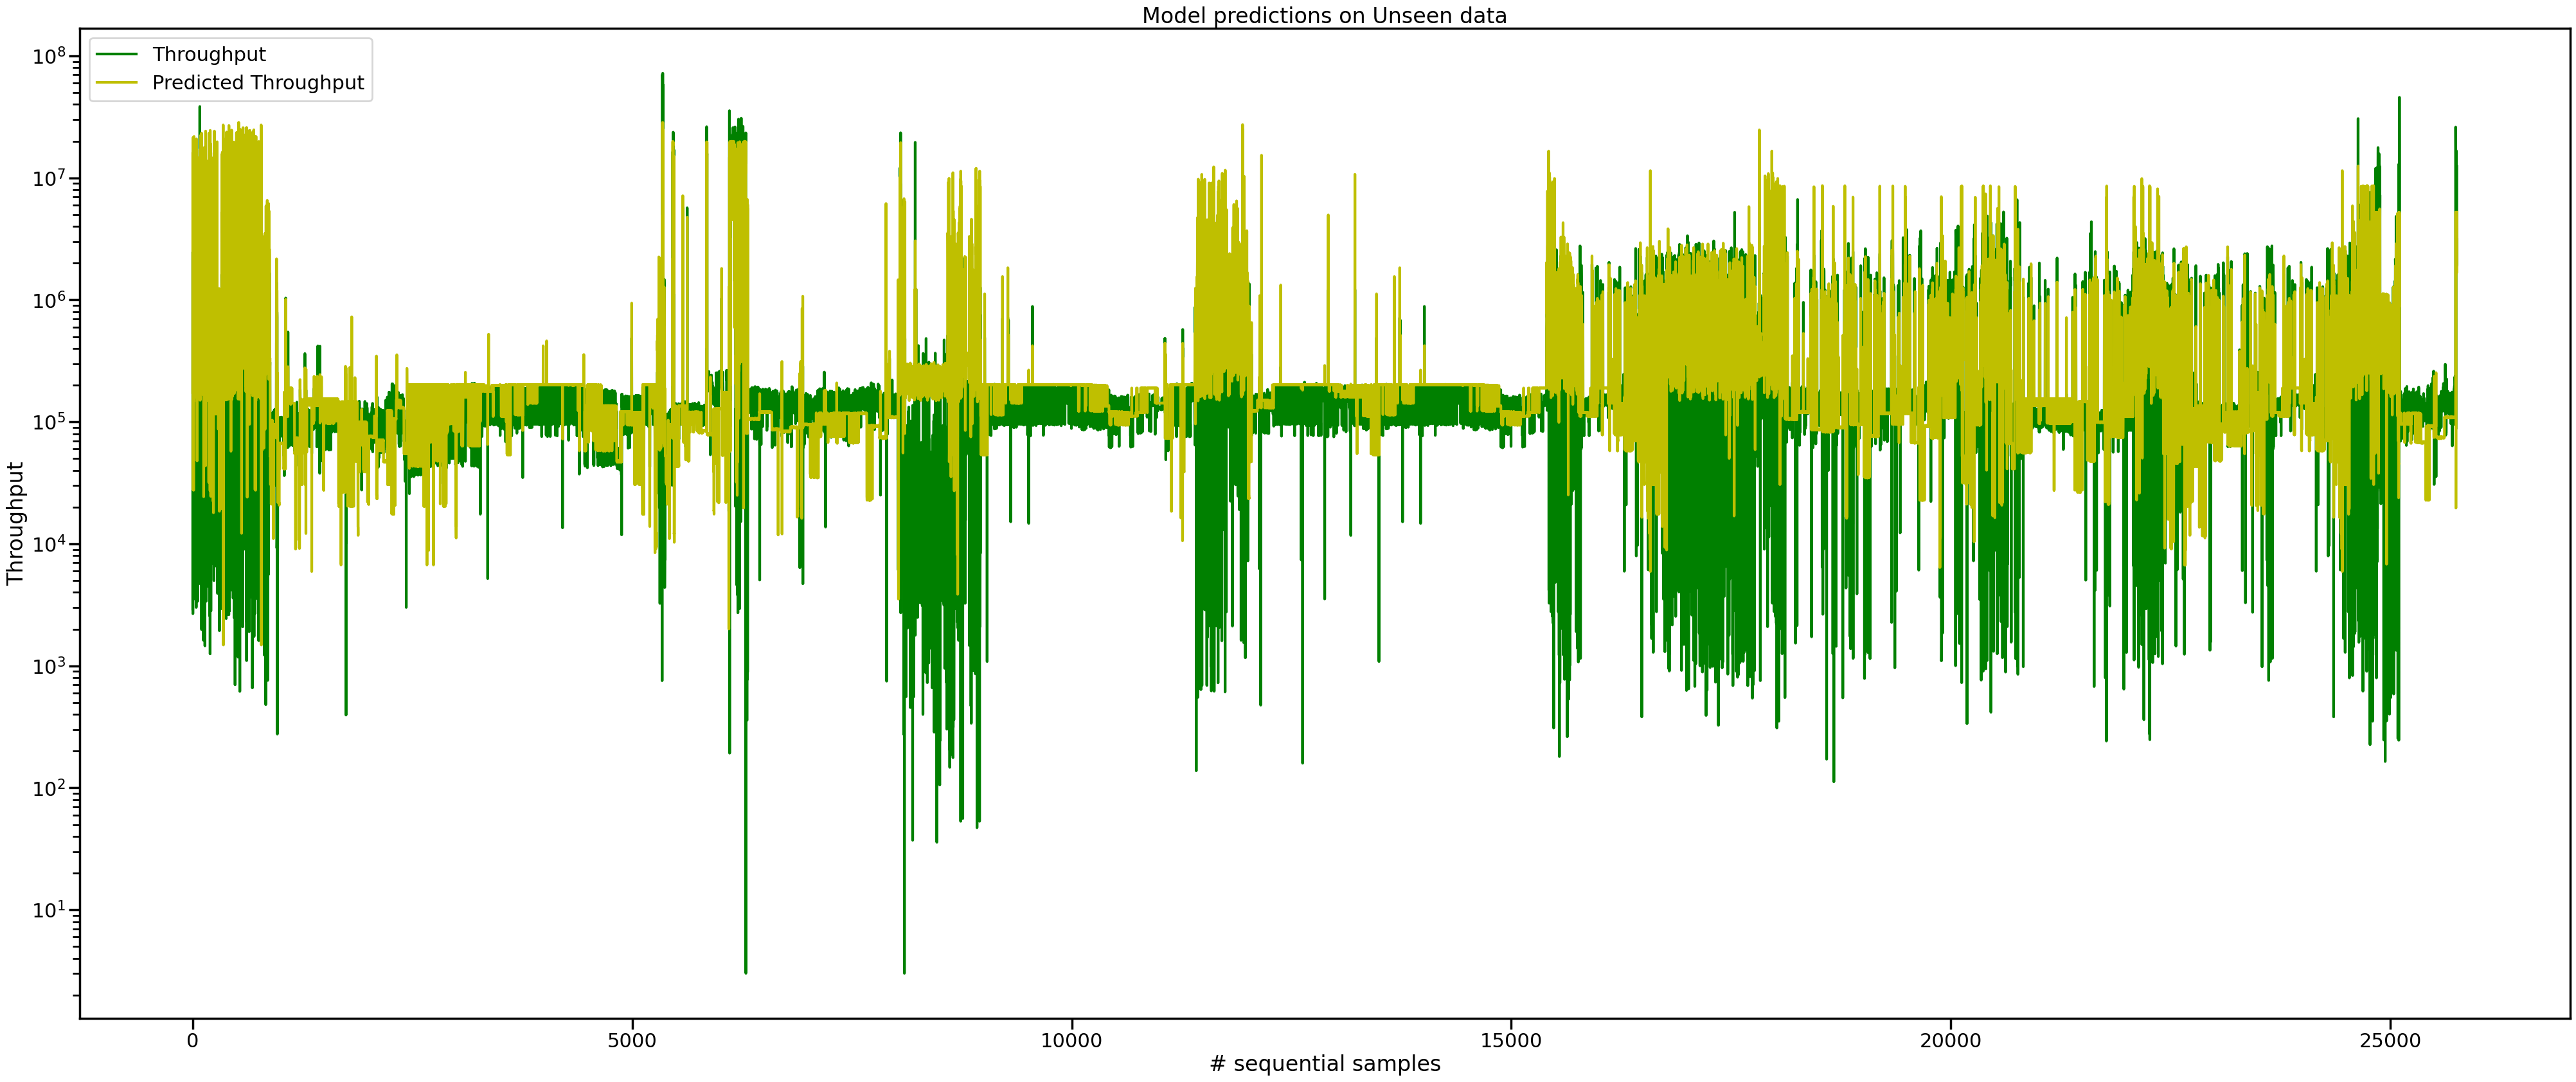

In [128]:
data_test = X_test_latest[features].copy()
throughput_test_pred = model.predict(data_test,batch_size=256, verbose=1)
if False:
    sns.set_context('poster')

    plt.figure(figsize=(50,20))
    plt.plot(y_test_latest.to_numpy(), 'g', label='Throughput')
    plt.plot(throughput_test_pred, 'y', label='Predicted Throughput')
    plt.title('Model predictions on Unseen data')
    plt.legend()
    plt.xlabel('# sequential samples')
    plt.ylabel('Throughput')
    plt.yscale("log")
    plt.show()

In [75]:
score = model.evaluate(X_test_latest, y_test_latest, verbose=2)
print (np.sqrt(score))

844/844 - 3s - loss: 3760350822400.0000 - 3s/epoch - 4ms/step
1939162.4022757867


In [78]:
print ( "Score Difference : ", abs (score - score_train ))
print ( "Mean Throughput : ", y_test_latest.mean() )

Score Difference :  722985629515776.0
Mean Throughput :  411876.1785766999


In [131]:
models = [model]

data_full = X_test_latest[features].copy()
for model in models:
    predicted = model.predict(data_full,batch_size=256, verbose=0)
    error_max = 0
    predicted_max = 0
    obs_max = 0
    index_max = 0
    MSE=0
    for i, obs in enumerate(y_test_latest.to_numpy()) :
        #error = abs ( predicted[i,0] - obs[0] )
        error = abs ( predicted[i,0] - obs )
        #if i > 4 : break
        if error > error_max :
           error_max = error
           predicted_max = predicted[i,0]
           #obs_max = obs[0]
           obs_max = obs
           index_max = i
        MSE=MSE+( predicted[i,0] - obs ) **2 
        #print (error)   
    RMSE_X_test_latest = np.sqrt(MSE/(i + 1)) / 1000000
    print ("Model Name : ",model.name)
    print ("    Error Max: ",error_max)
    print ("    Error Max Index: ",index_max)
    print ("    Error Max Predicted: ",predicted_max)
    print ("    Error Max Observed: ",obs_max)
    print ("    Test Sample RMSE : ", "{:.2f}".format( RMSE_X_test_latest ), " MB/s vs Train Sample ", "{:.2f}".format( RMSE_X_full )," MB/s" )
    


Model Name :  sequential_7
    Error Max:  44518557.047619045
    Error Max Index:  25103
    Error Max Predicted:  1283726.0
    Error Max Observed:  45802283.047619045
    Test Sample RMSE :  1.74  MB/s vs Train Sample  29.51  MB/s


In [134]:
if RMSE_X_test_latest > ( RMSE_X_full  + RMSE_X_full * 0.15 ) :
   print ("Warning: Test Sample RMSE is beyond the Train Sample RMSE tolerance")
   print ("    Test Sample RMSE : ", "{:.2f}".format( RMSE_X_test_latest ), " MB/s vs Train Sample ", "{:.2f}".format( RMSE_X_full )," MB/s" )
else :
   print ("OK: Test Sample RMSE is within the Train Sample RMSE tolerance")
   print ("    Test Sample RMSE : ", "{:.2f}".format( RMSE_X_test_latest ), " MB/s vs Train Sample ", "{:.2f}".format( RMSE_X_full )," MB/s" )


OK: Test Sample RMSE is within the Train Sample RMSE tolerance
    Test Sample RMSE :  1.74  MB/s vs Train Sample  29.51  MB/s


In [135]:
del df_test_latest
del X_test_latest
del y_test_latest
del data_full
gc.collect()


57455

In [ ]:
sys.exit()

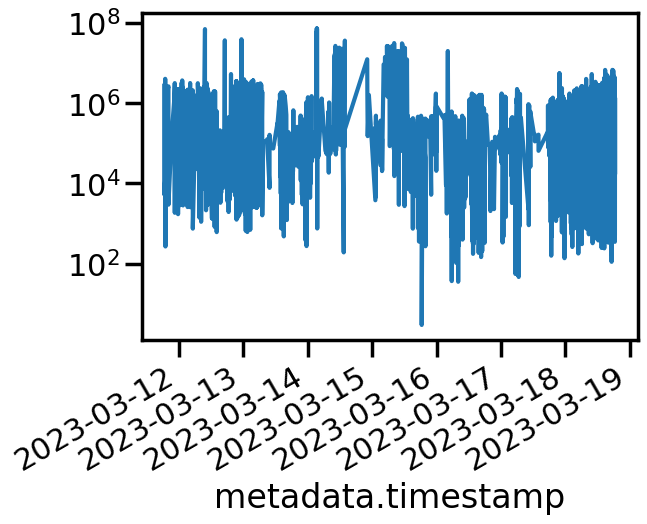

In [50]:
fig, ax = plt.subplots()
y_test_latest.plot(legend=False, ax=ax)
plt.yscale("log")
plt.show()

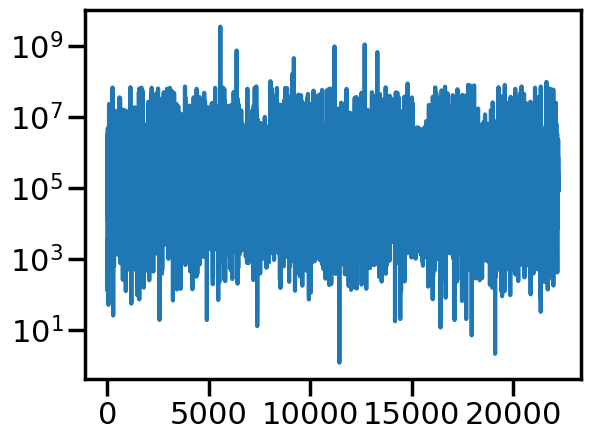

In [51]:
fig, ax = plt.subplots()
y_train.plot(legend=False, ax=ax)
plt.yscale("log")
plt.show()

In [53]:
print ("Predicted Throughput Mean: ",throughput_test_pred.mean())
print ("Observed Throughput Mean: ",y_test_latest.to_numpy().mean())

Predicted Throughput Mean:  369642.03
Observed Throughput Mean:  390554.9461736496


In [56]:
skill = model.compare(y_test_latest.to_numpy(), throughput_test_pred)

AttributeError: 'Sequential' object has no attribute 'compare'

In [54]:
sys.exit()

SystemExit: 

/opt/cms/services/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 2 Get the Train Sample

In [26]:
print ("Getting the Train Sample")
traincsv = 'chep2023XRDMonitoringDataDeepLearningTake3_3_1_train.csv'
if not os.path.isfile(traincsv):
   df = get_train_sample ()
   df.to_csv(traincsv, index=False)
   del df
   import gc
   gc.collect()
   work_path="/opt/cms/services/T2/ops/Work/CHEP2023"
   file_path = work_path + "/" + traincsv
   from zipfile import ZipFile
   with ZipFile(traincsv+".zip", 'w') as zip_object:
        zip_object.write(file_path, os.path.basename(file_path))

In [33]:
df = get_train_sample ()

Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030206.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030206.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030212.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030212.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030200.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030200.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030218.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030218.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030300.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030300.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030306.csv.zip
Done

In [27]:
#df.to_csv(traincsv, index=False)

In [28]:
#df.keys()

In [32]:
#!ls chep2023XRDMonitoringDataDeepLearning*csv*

In [31]:
#csvFileToTest = 'chep2023XRDMonitoringDataDeepLearningTake3_1_train.csv.zip'
#preprocessed_data_X_test_full = pd.read_csv( csvFileToTest, low_memory=False , compression='zip')
# 
# Memory issue: df = pd.read_csv( traincsv+".zip", low_memory=False, compression='zip')
#

## Reshape the Data Frame for the Features and the Target

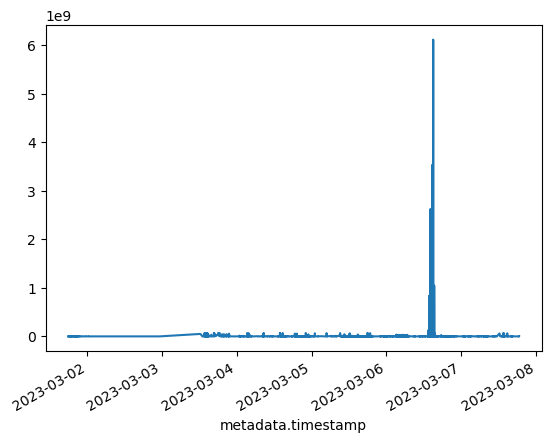

In [34]:
print("Reshaping the Data Frame for the Features and the Target")
xrdcoll_data = df.loc[df['throughput'] > throughput]
xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['site_name'] == site]
xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['operation'] == operation]
xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['user_protocol'] == user_protocol]
xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['client_domain'] == client_domain]
xrdcoll_data[f'read_btyes/file_size'] = xrdcoll_data['read_bytes'].div(xrdcoll_data['file_size'])

fig, ax = plt.subplots()
xrdcoll_data["throughput"].plot(legend=False, ax=ax)
plt.show()

#del df
#gc.collect()


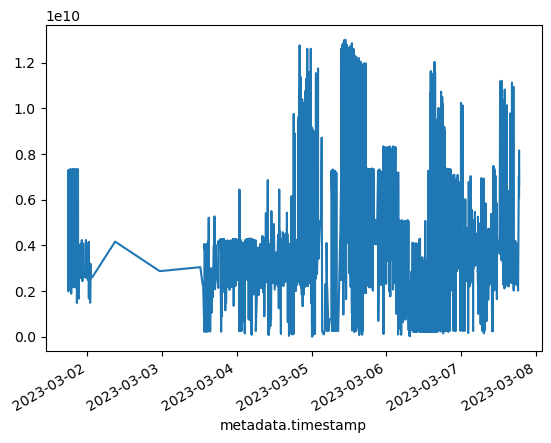

In [35]:
#fig, ax = plt.subplots()
#xrdcoll_data = df.loc[df['throughput'] > throughput]
#xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['site_name'] == site]
#xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['operation'] == operation]
#xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['user_protocol'] == user_protocol]
#xrdcoll_data = xrdcoll_data.loc[xrdcoll_data['client_domain'] == client_domain]
#xrdcoll_data[f'read_btyes/file_size'] = xrdcoll_data['read_bytes'].div(xrdcoll_data['file_size'])
xrdcoll_data["file_size"].plot(legend=False, ax=ax)
plt.show()

Text(0.5, 1.0, 'File_size vs Throughput')

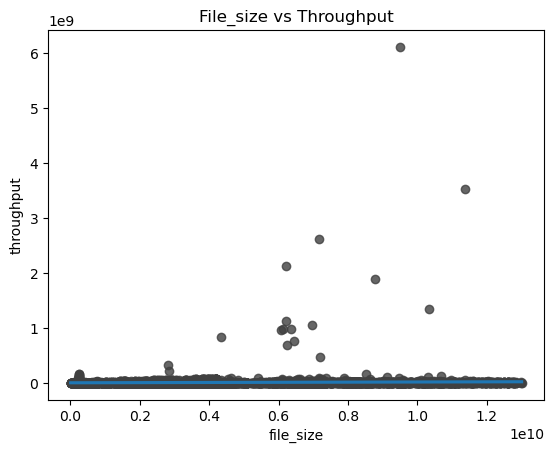

In [36]:
fig, ax = plt.subplots()
#ax.plot('start_time', 'operation_time', data=xrdcoll_data, color='0.75')
ax = sns.regplot(x='file_size', y='throughput', data=xrdcoll_data, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('File_size vs Throughput')

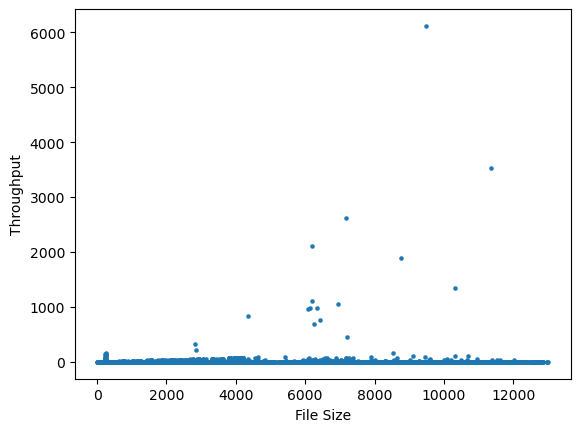

In [37]:
fig, ax = plt.subplots()
scale_me=1000000 # MB
plt.scatter(xrdcoll_data['file_size']/scale_me, xrdcoll_data['throughput']/scale_me, s=10, linewidths = 0.1)
plt.xlabel('File Size')
plt.ylabel('Throughput')
#plt.yscale("log")
plt.show()

In [38]:
xrdcoll_data.shape

(27782, 55)

In [39]:
#plt.scatter(x, y)
xrdcoll_data.keys()

Index(['Unnamed: 0', 'site_name', 'fallback', 'user_dn', 'client_host',
       'client_domain', 'server_host', 'server_domain', 'server_ip',
       'unique_id', 'file_lfn', 'file_size', 'read_bytes', 'read_single_bytes',
       'read_vector_bytes', 'ipv6', 'start_time', 'end_time', 'operation_time',
       'operation', 'server_site', 'write_bytes', 'read_average',
       'read_bytes_at_close', 'read_max', 'read_min', 'read_operations',
       'read_sigma', 'read_single_average', 'read_single_max',
       'read_single_min', 'read_single_operations', 'read_single_sigma',
       'read_vector_average', 'read_vector_count_average',
       'read_vector_count_max', 'read_vector_count_min',
       'read_vector_count_sigma', 'read_vector_max', 'read_vector_min',
       'read_vector_operations', 'read_vector_sigma', 'throughput',
       'write_average', 'write_bytes_at_close', 'write_max', 'write_min',
       'write_operations', 'write_sigma', 'metadata', 'Ymd', 'user',
       'user_protocol', '

## Separate the Train and the Validation

In [52]:
print("Separating the Sample for the Train and the Validation")
# Obtain target and predictors
X, y = select_features_and_target ( xrdcoll_data, features = features, target = 'throughput' )

X = train_encoders_fit_transform(X, use_cache=False)

#X = X_full[features].copy()

#X_test_full, _ = select_features_and_target ( preprocessed_data_X_test_full, target = 'throughput' )
#X_test_full = train_encoders_fit_transform(X_test_full, use_cache=False)
#X_test = X_test_full[features].copy()

from sklearn.model_selection import train_test_split

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

Separating the Sample for the Train and the Validation


## Some Scatter Plots for Presentation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


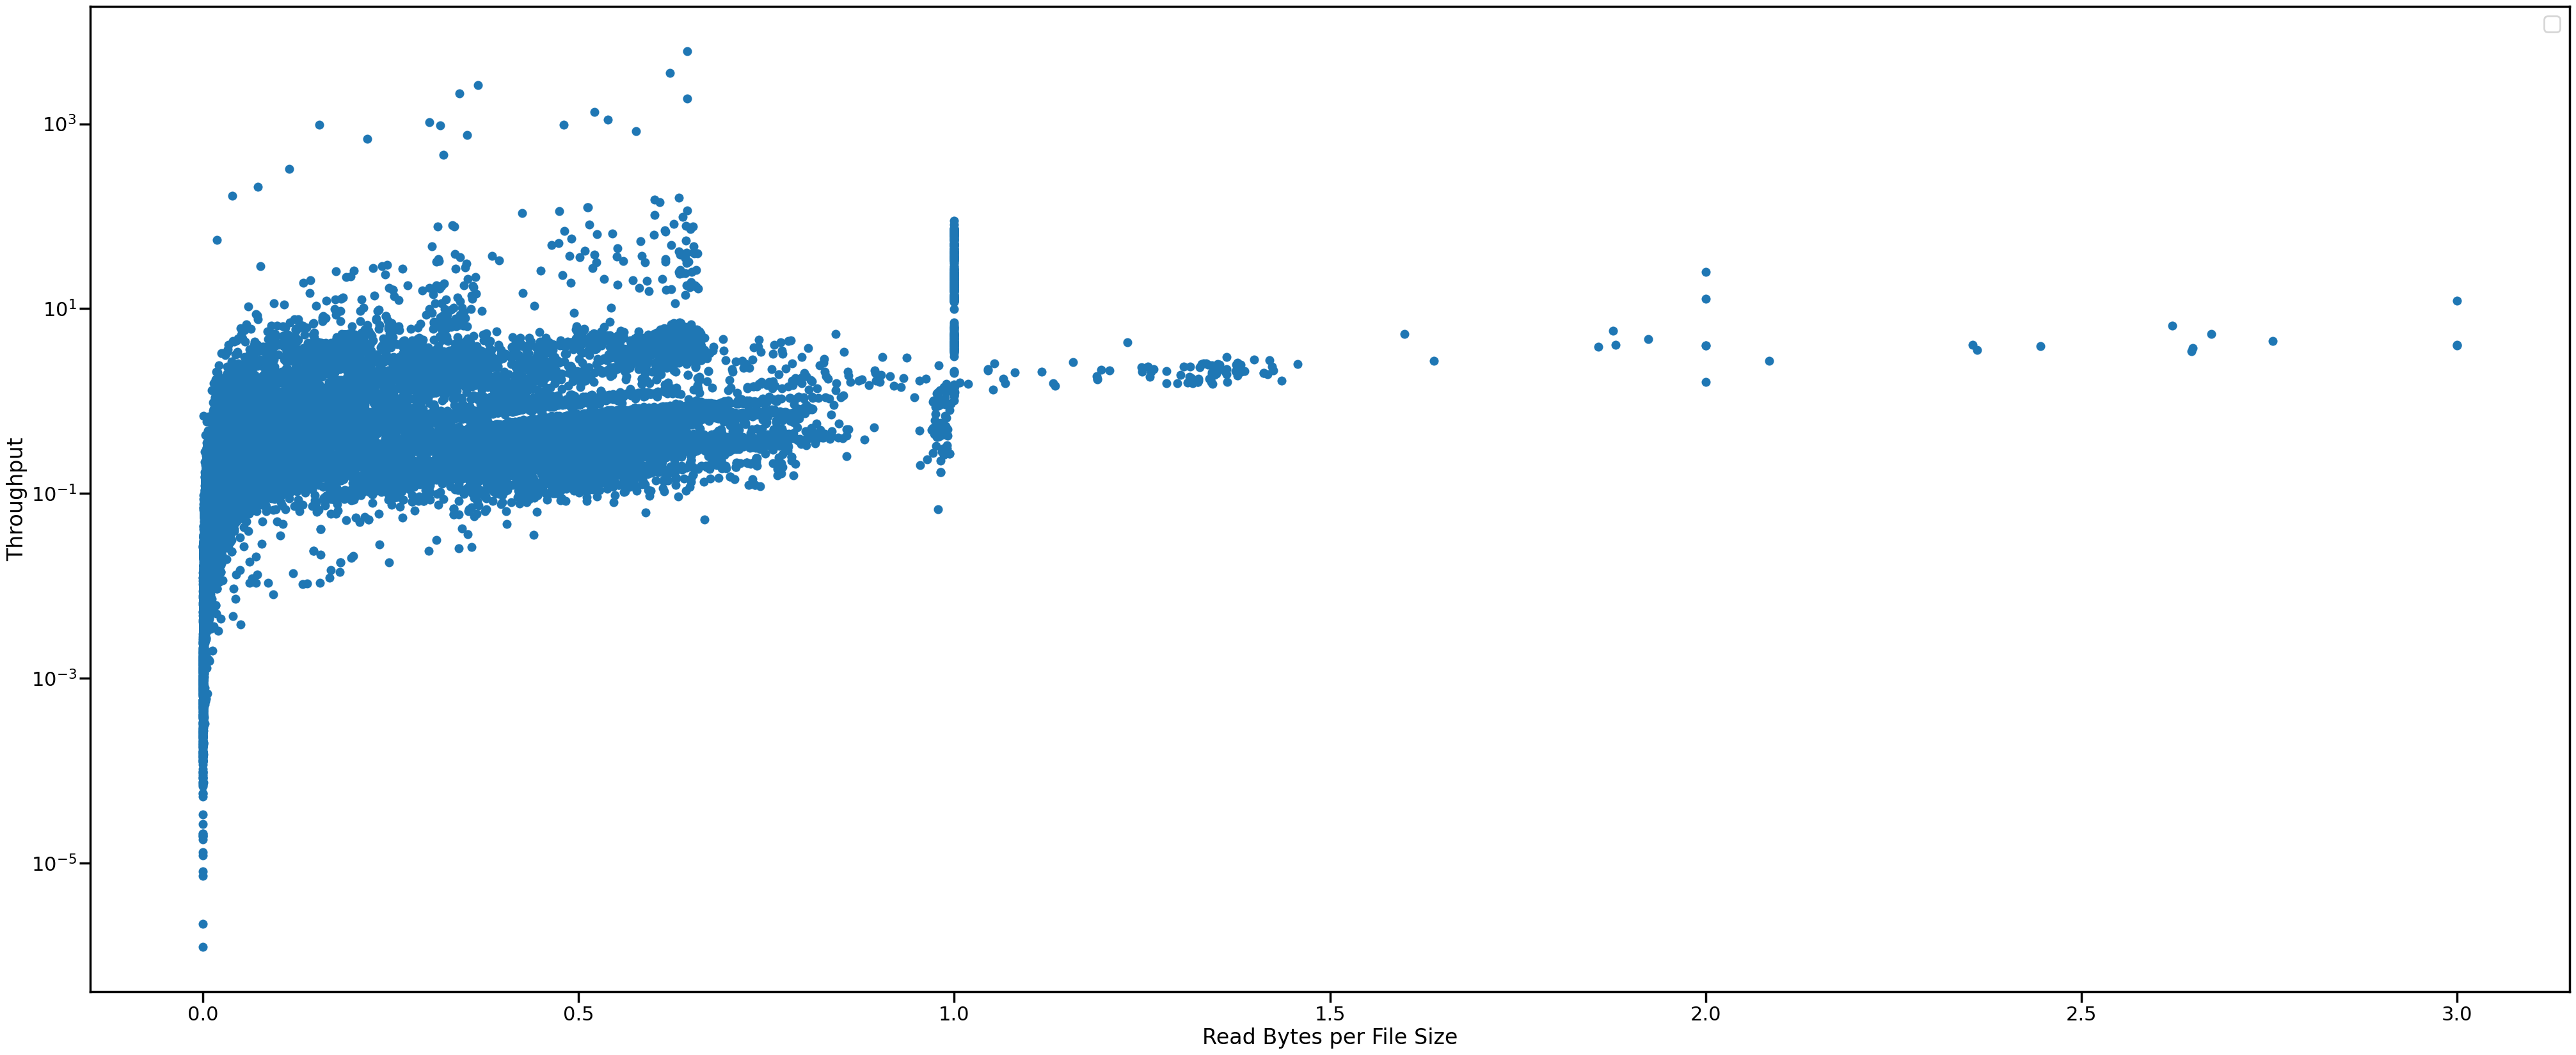

In [42]:
print ("Showing Some Scatter Plots")
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X['read_btyes/file_size'], y/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(y_test.to_numpy()/scale_me, throughput_test_pred/scale_me, 1)
#plt.plot(y_test.to_numpy()/scale_me, m*(y_test.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Read Bytes per File Size')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


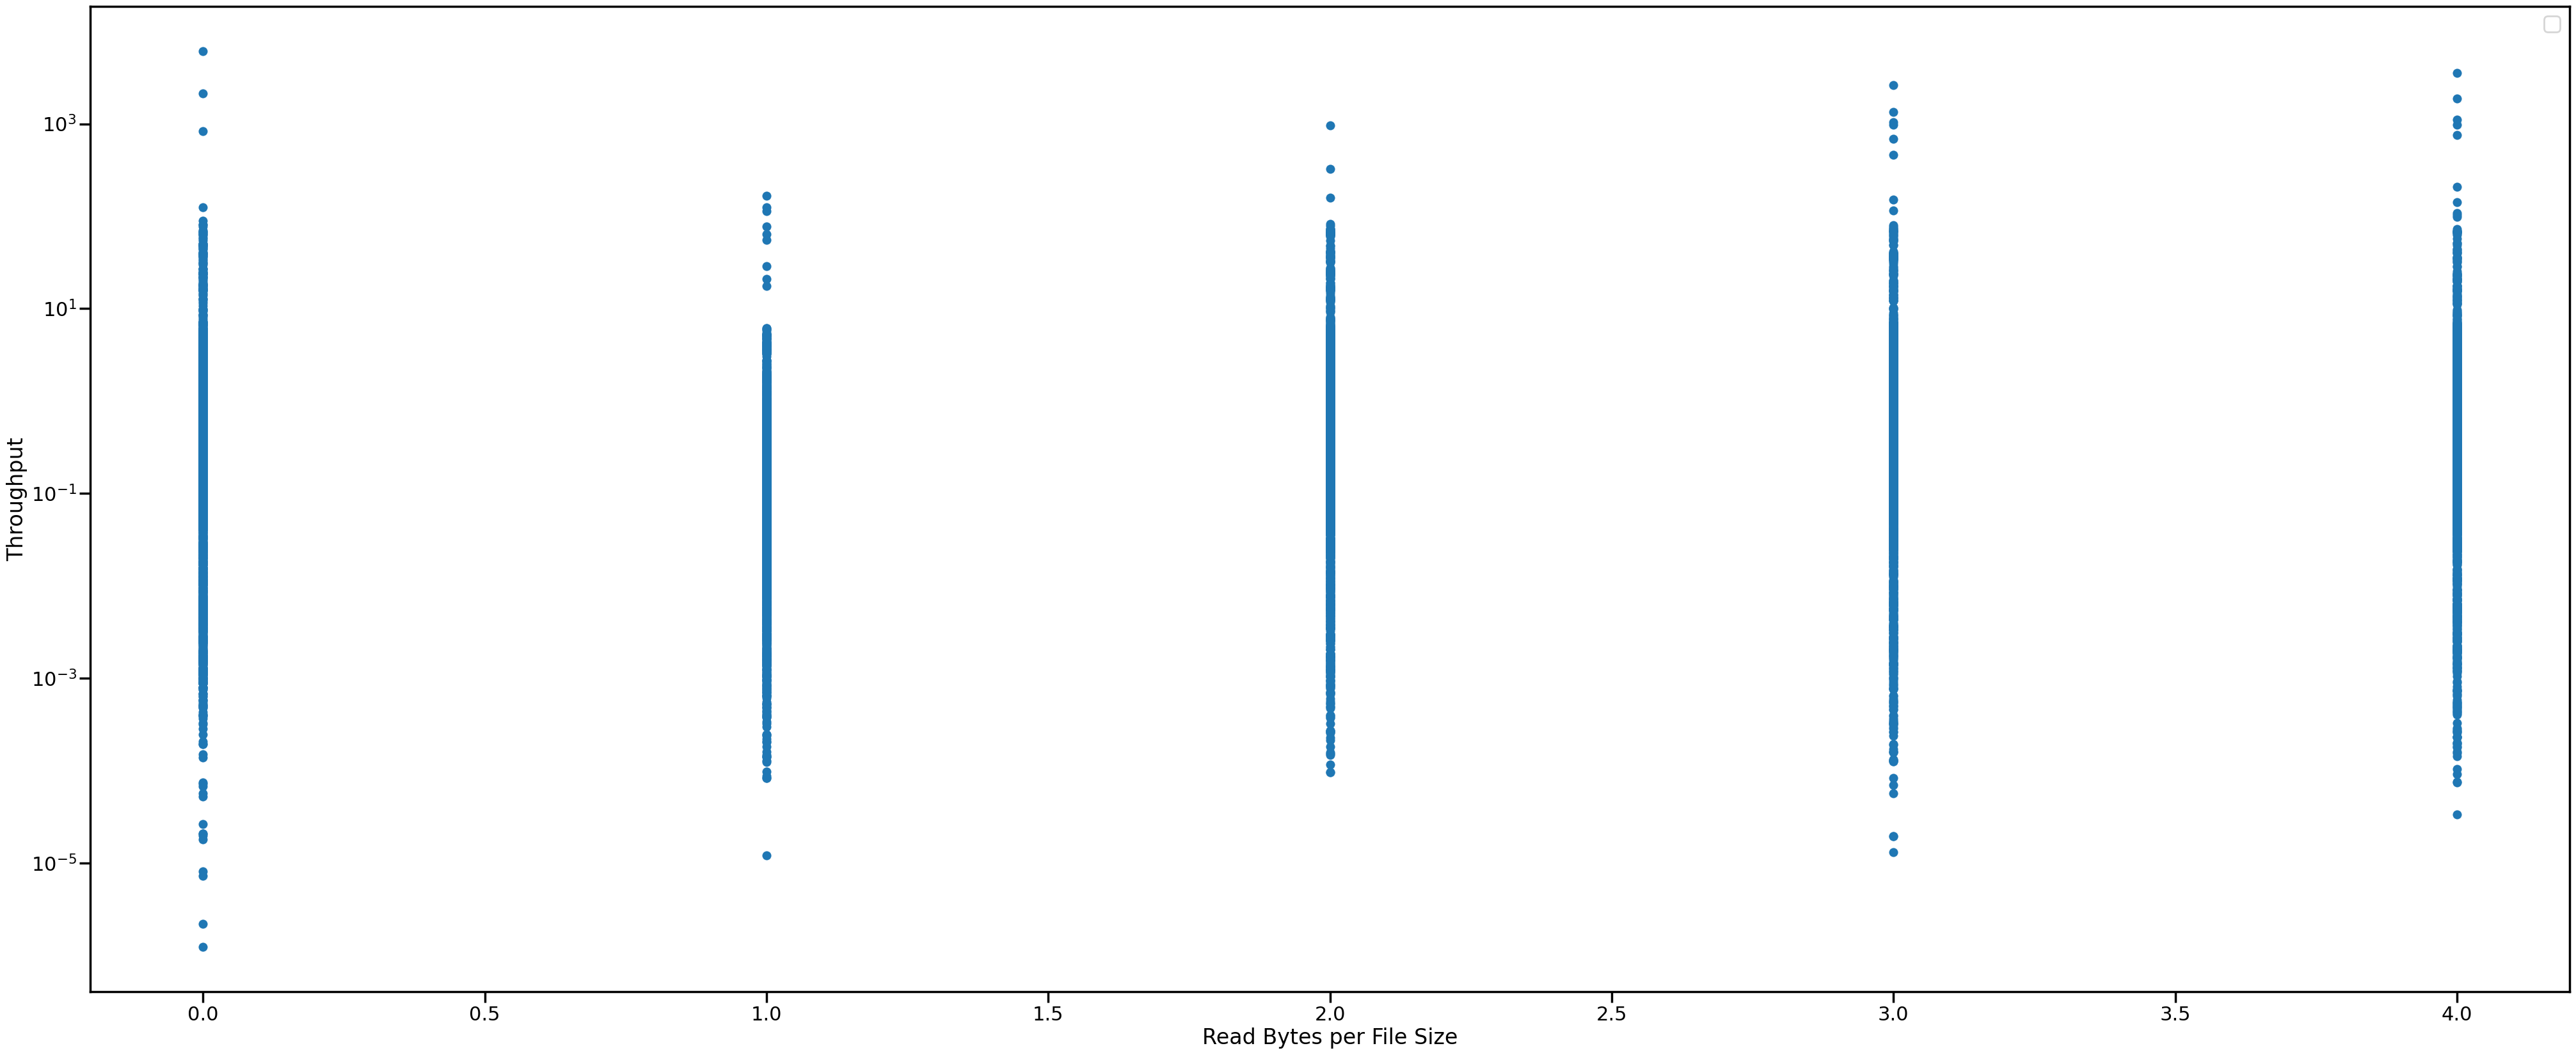

In [43]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X['server_host'], y/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(y_test.to_numpy()/scale_me, throughput_test_pred/scale_me, 1)
#plt.plot(y_test.to_numpy()/scale_me, m*(y_test.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Read Bytes per File Size')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


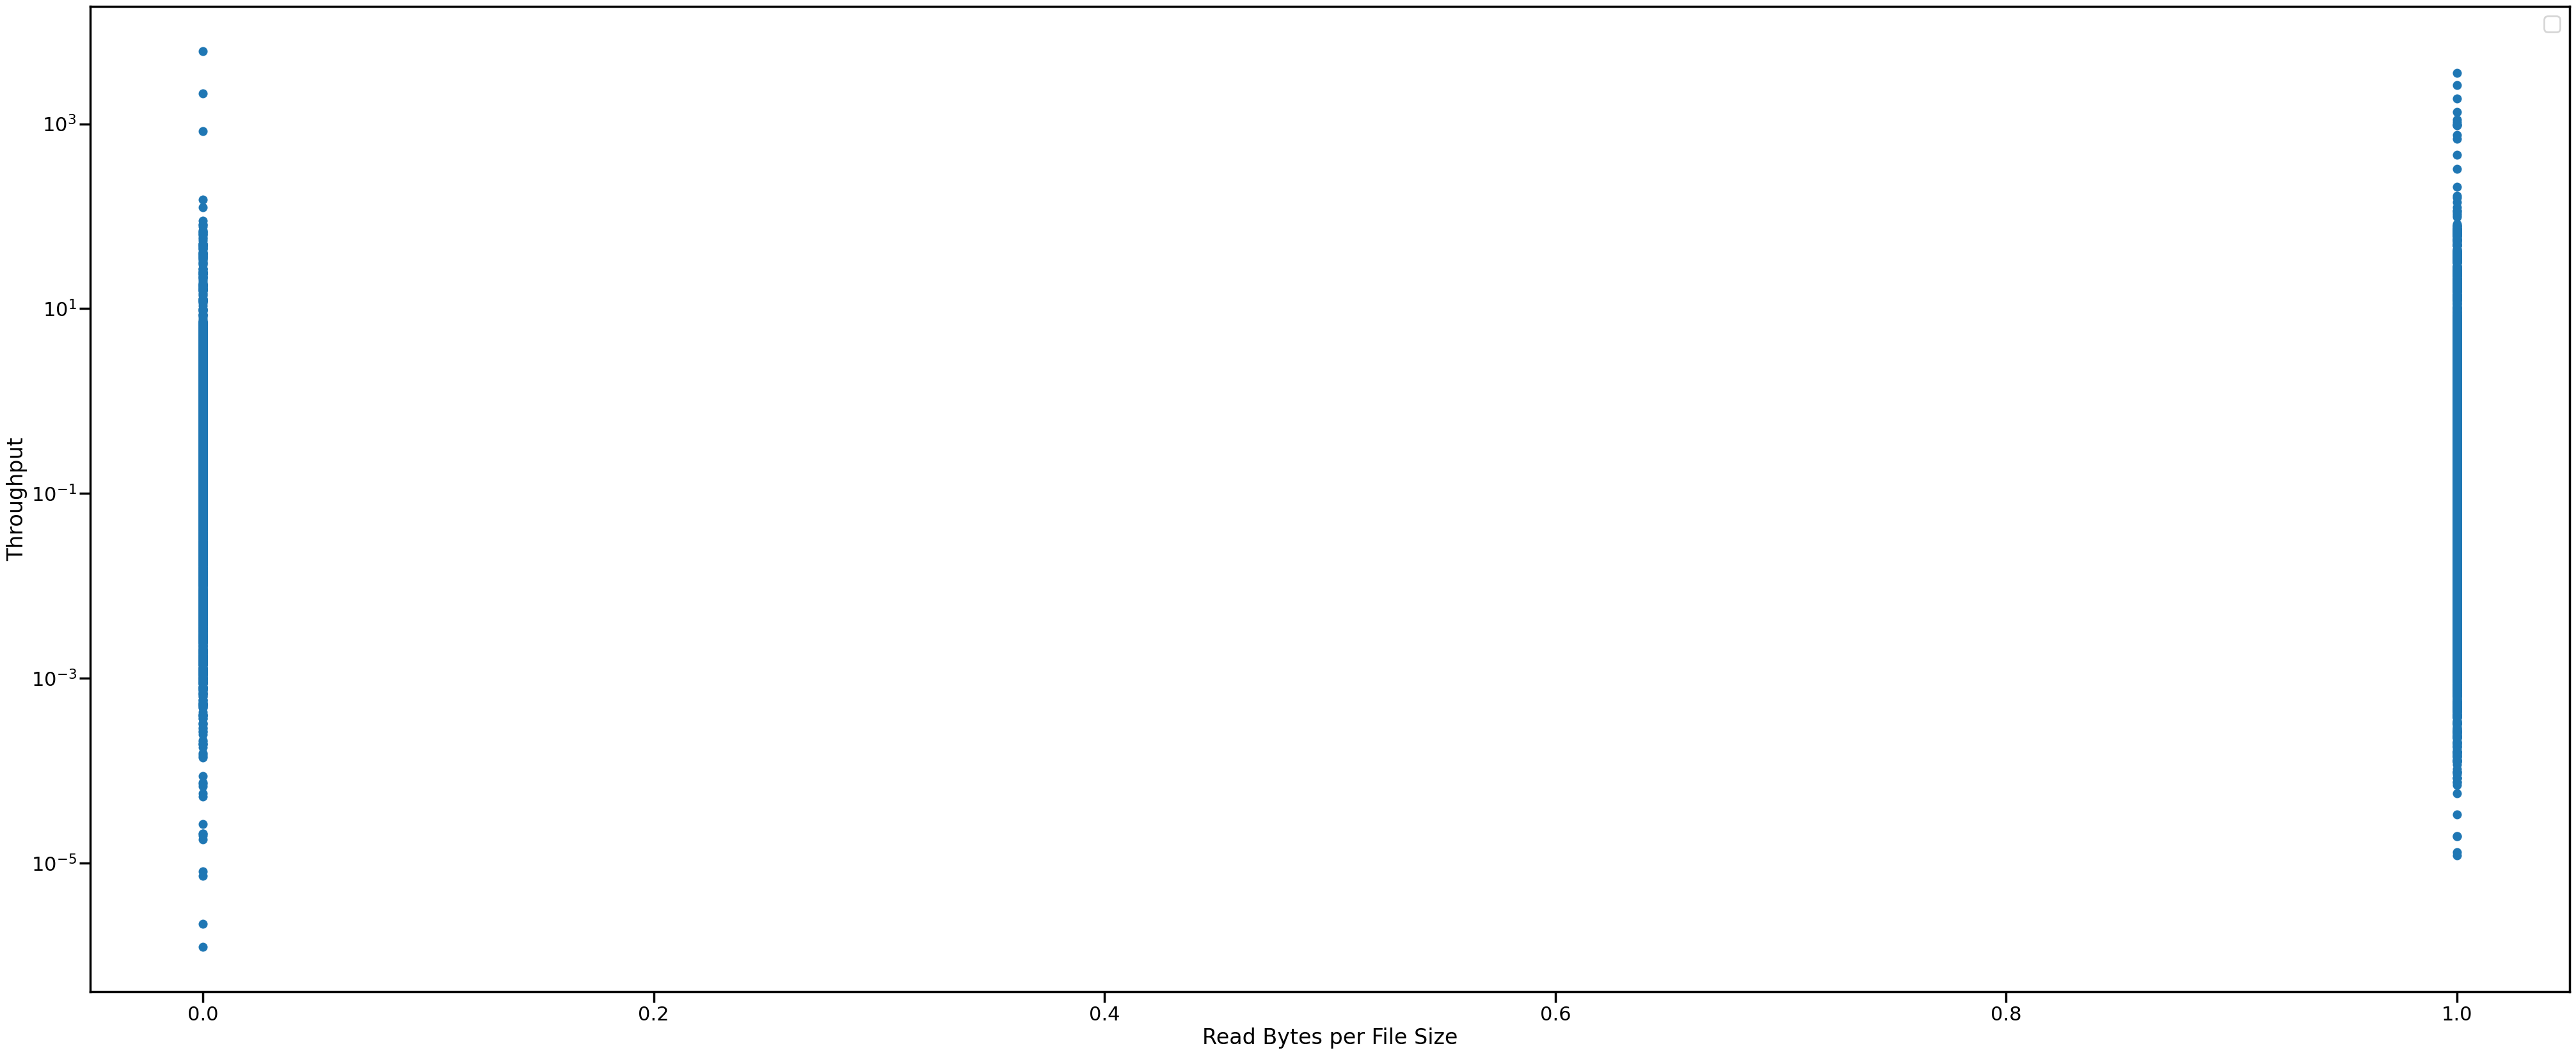

In [44]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X['ipv6'], y/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(y_test.to_numpy()/scale_me, throughput_test_pred/scale_me, 1)
#plt.plot(y_test.to_numpy()/scale_me, m*(y_test.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Read Bytes per File Size')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


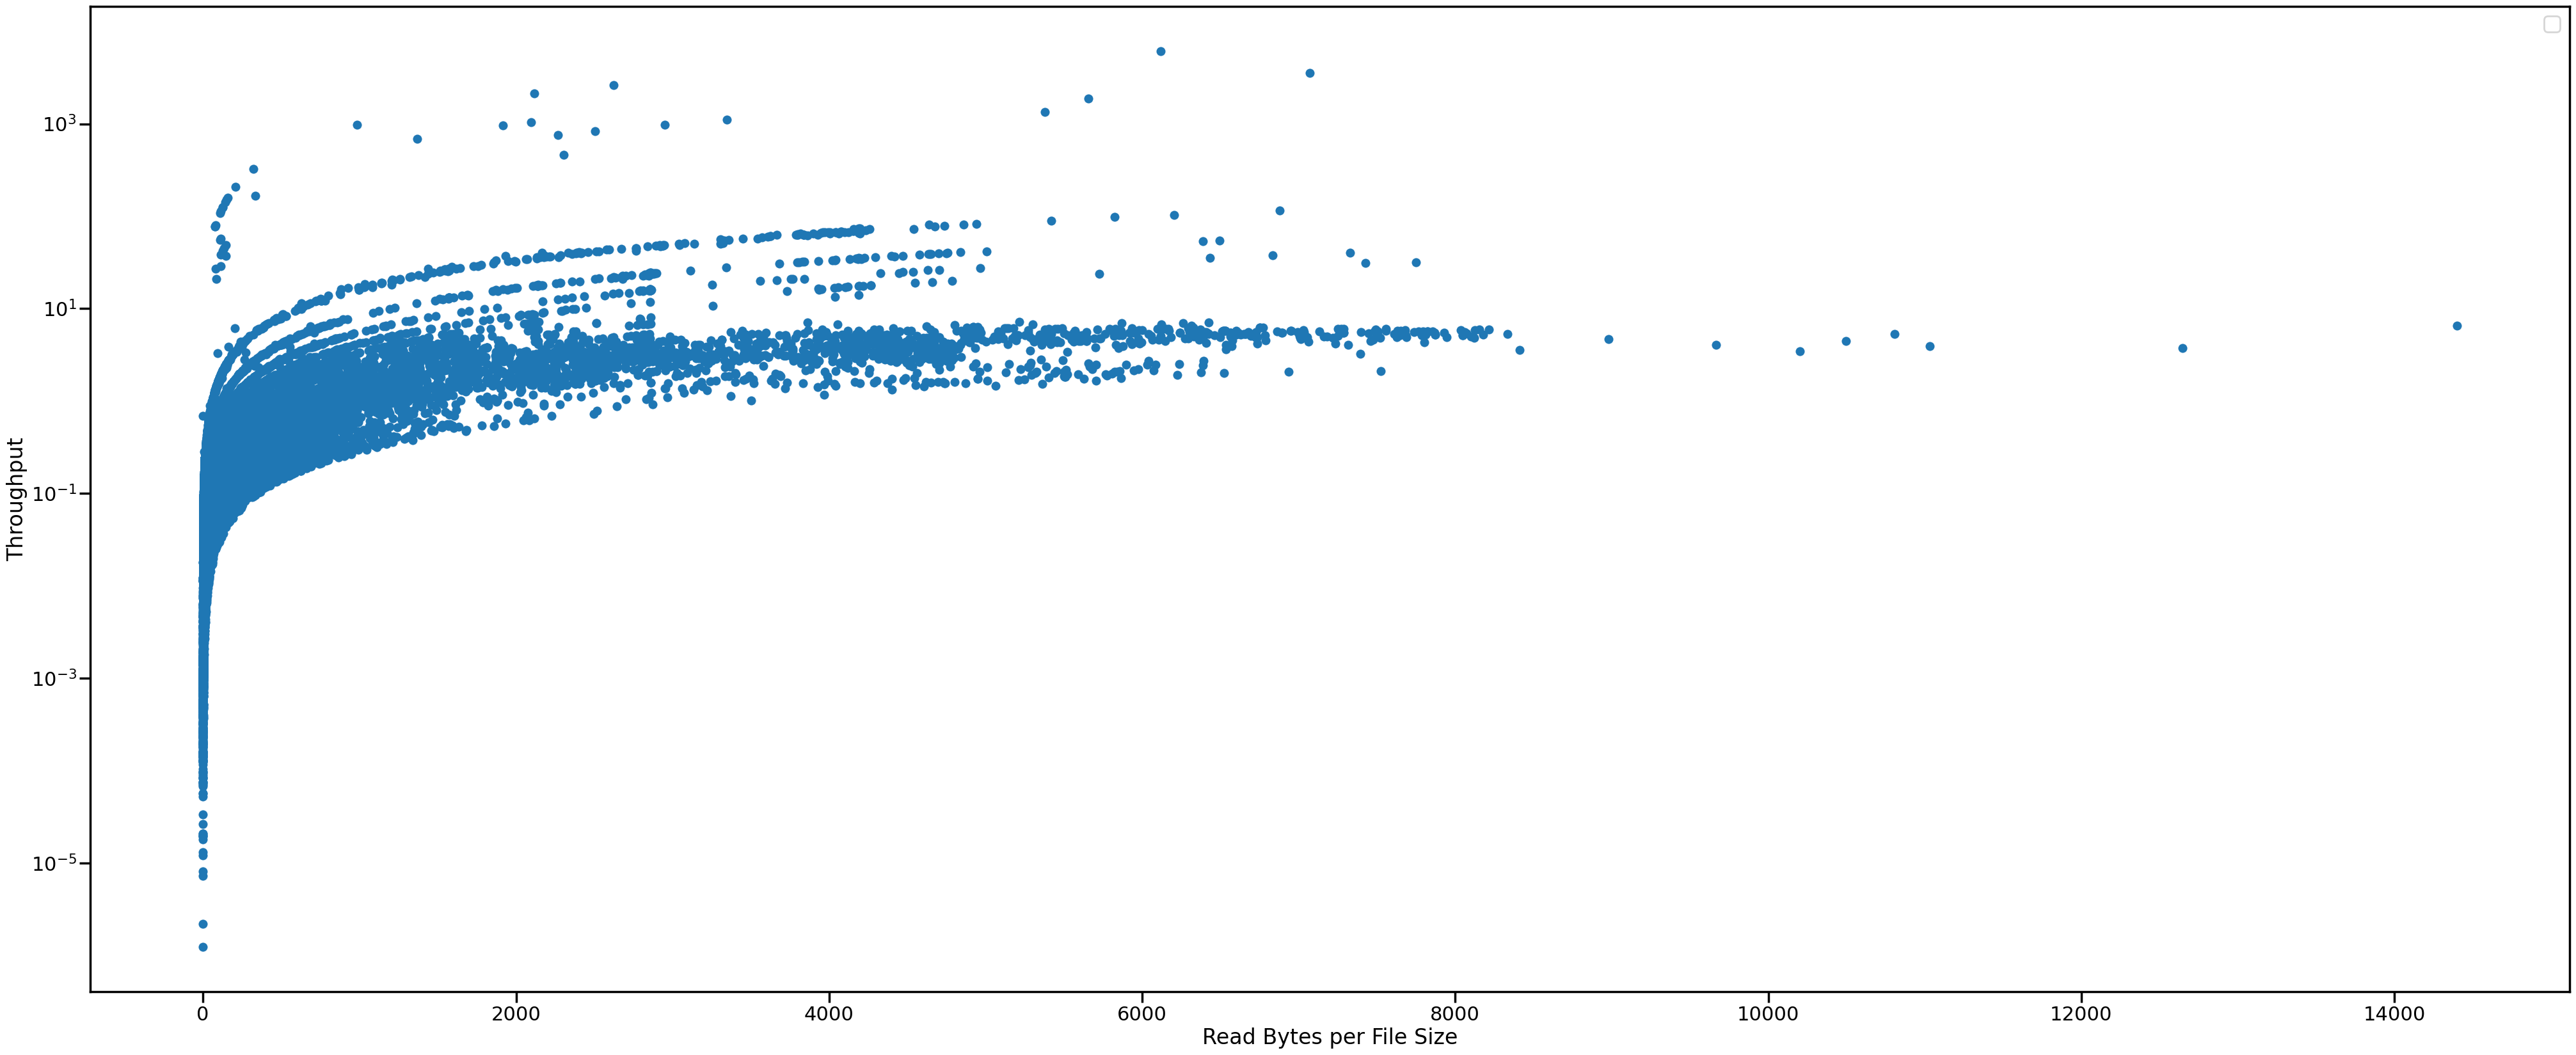

In [45]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X['read_bytes']/scale_me, y/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(y_test.to_numpy()/scale_me, throughput_test_pred/scale_me, 1)
#plt.plot(y_test.to_numpy()/scale_me, m*(y_test.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Read Bytes per File Size')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


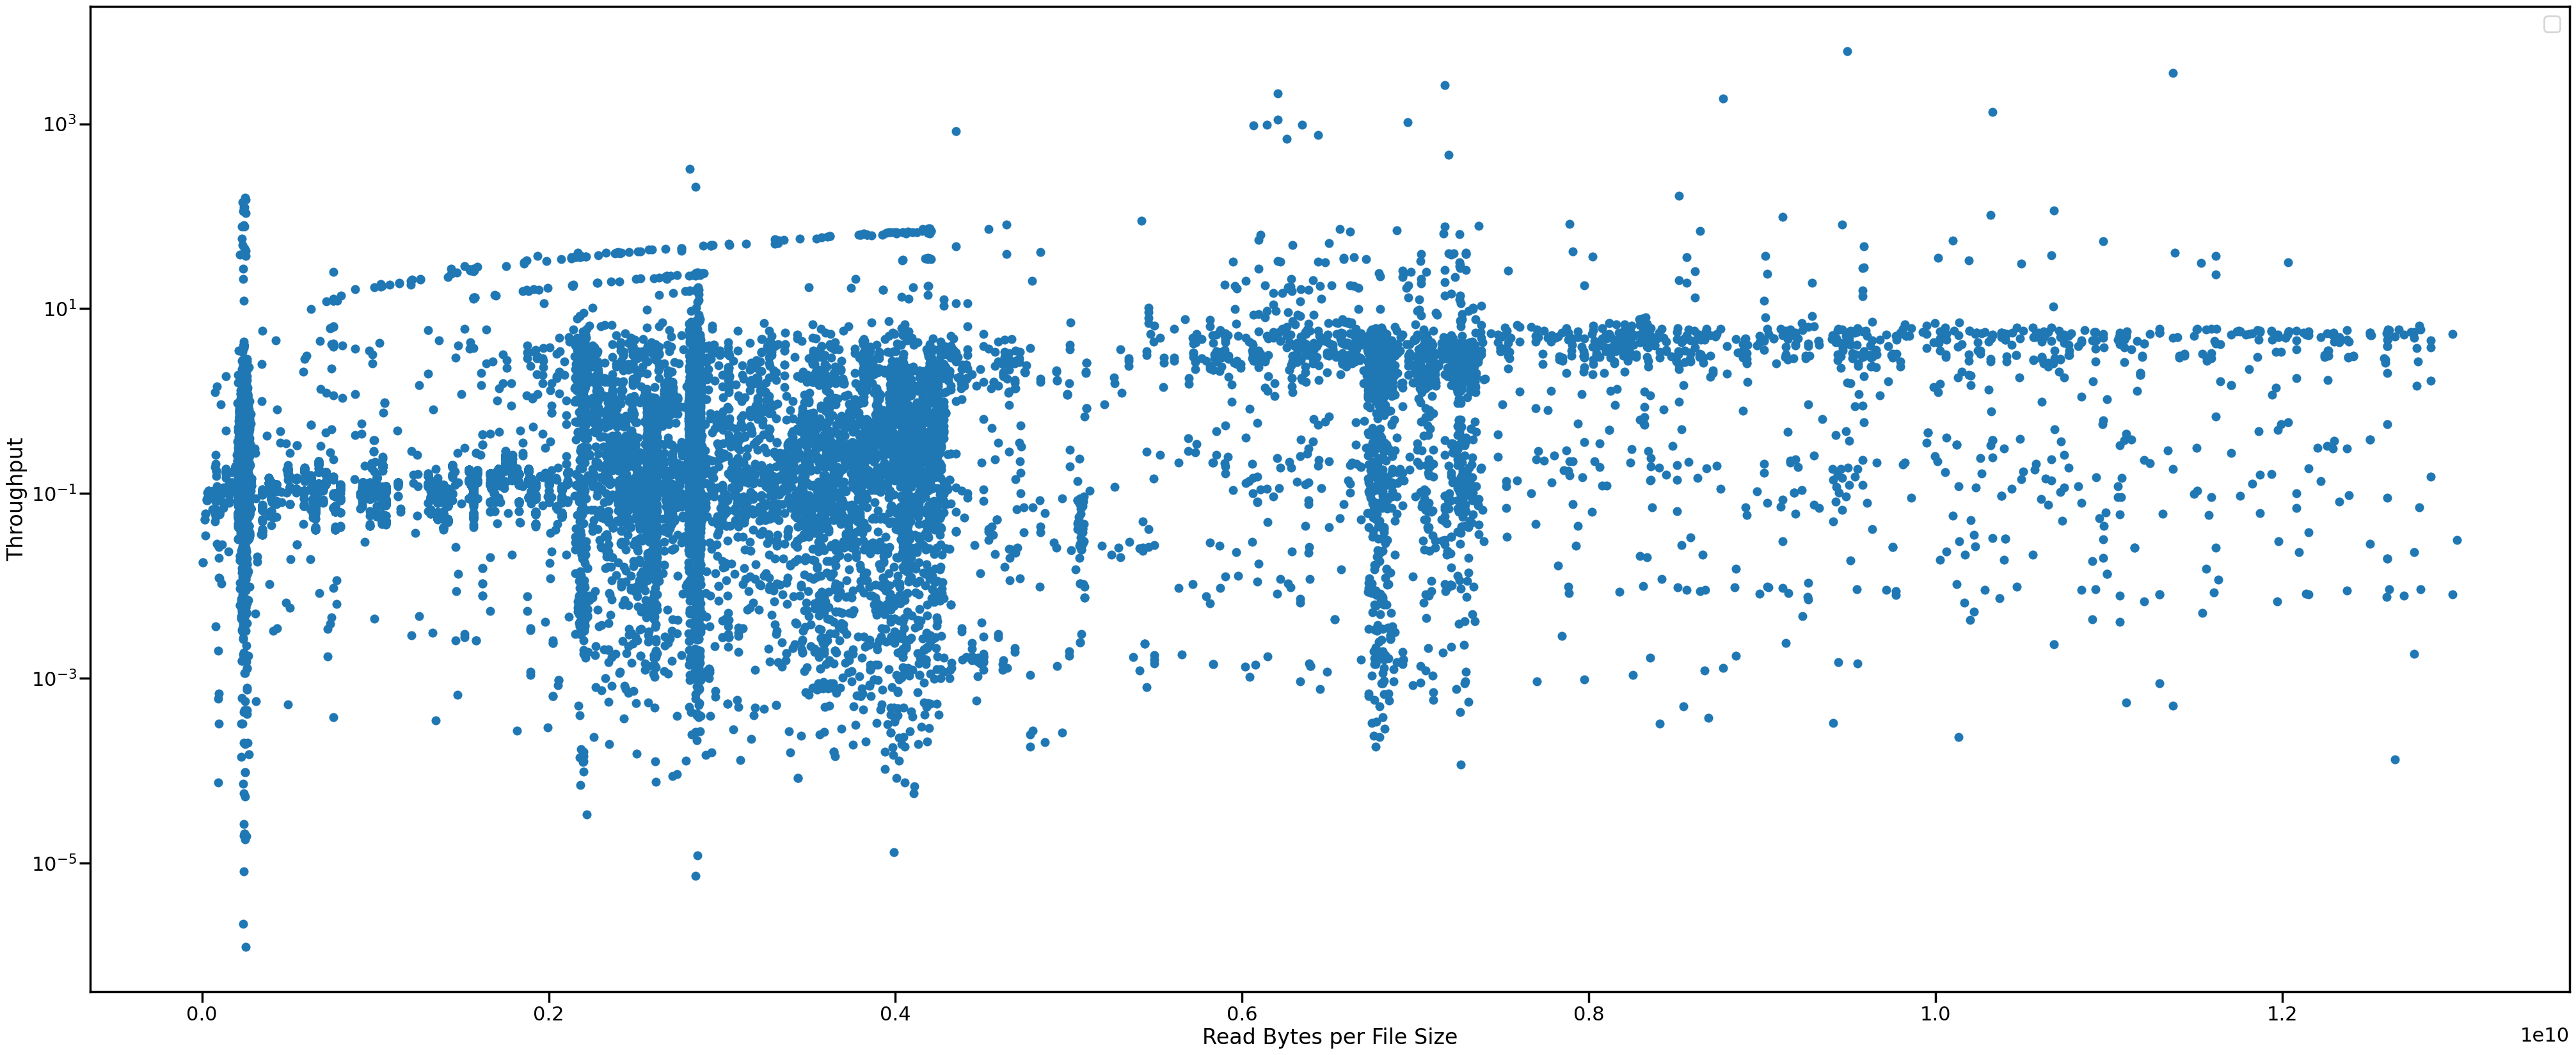

In [46]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X['file_size'], y/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(y_test.to_numpy()/scale_me, throughput_test_pred/scale_me, 1)
#plt.plot(y_test.to_numpy()/scale_me, m*(y_test.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Read Bytes per File Size')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

## Building and Training a Model

In [47]:
print("Building and Training a Model")
input_shape = [X_train.shape[1]] # ['file_size', 'read_bytes', 'ipv6', 'operation_time', 'read_btyes/file_size']

In [48]:
### Model 2

2023-03-18 13:34:53.968946: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64::/home/bockjoo/services/external/webisoget-2.8.4/lib:/usr/lib/x86_64-linux-gnu
2023-03-18 13:34:53.974619: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-18 13:34:53.974654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cms.ufhpc): /proc/driver/nvidia/version does not exist


Minimum validation loss: 2473305.0


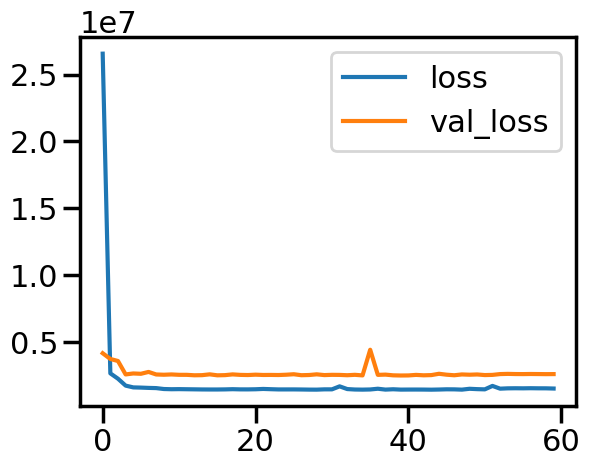

In [49]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model2 = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=512, activation='relu', input_shape=input_shape),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=512, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

model2.compile(
    optimizer='adam',
    loss='mae',
    metrics=['accuracy'],
)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

## Check Closure

109/109 [==============================] - 0s 3ms/step


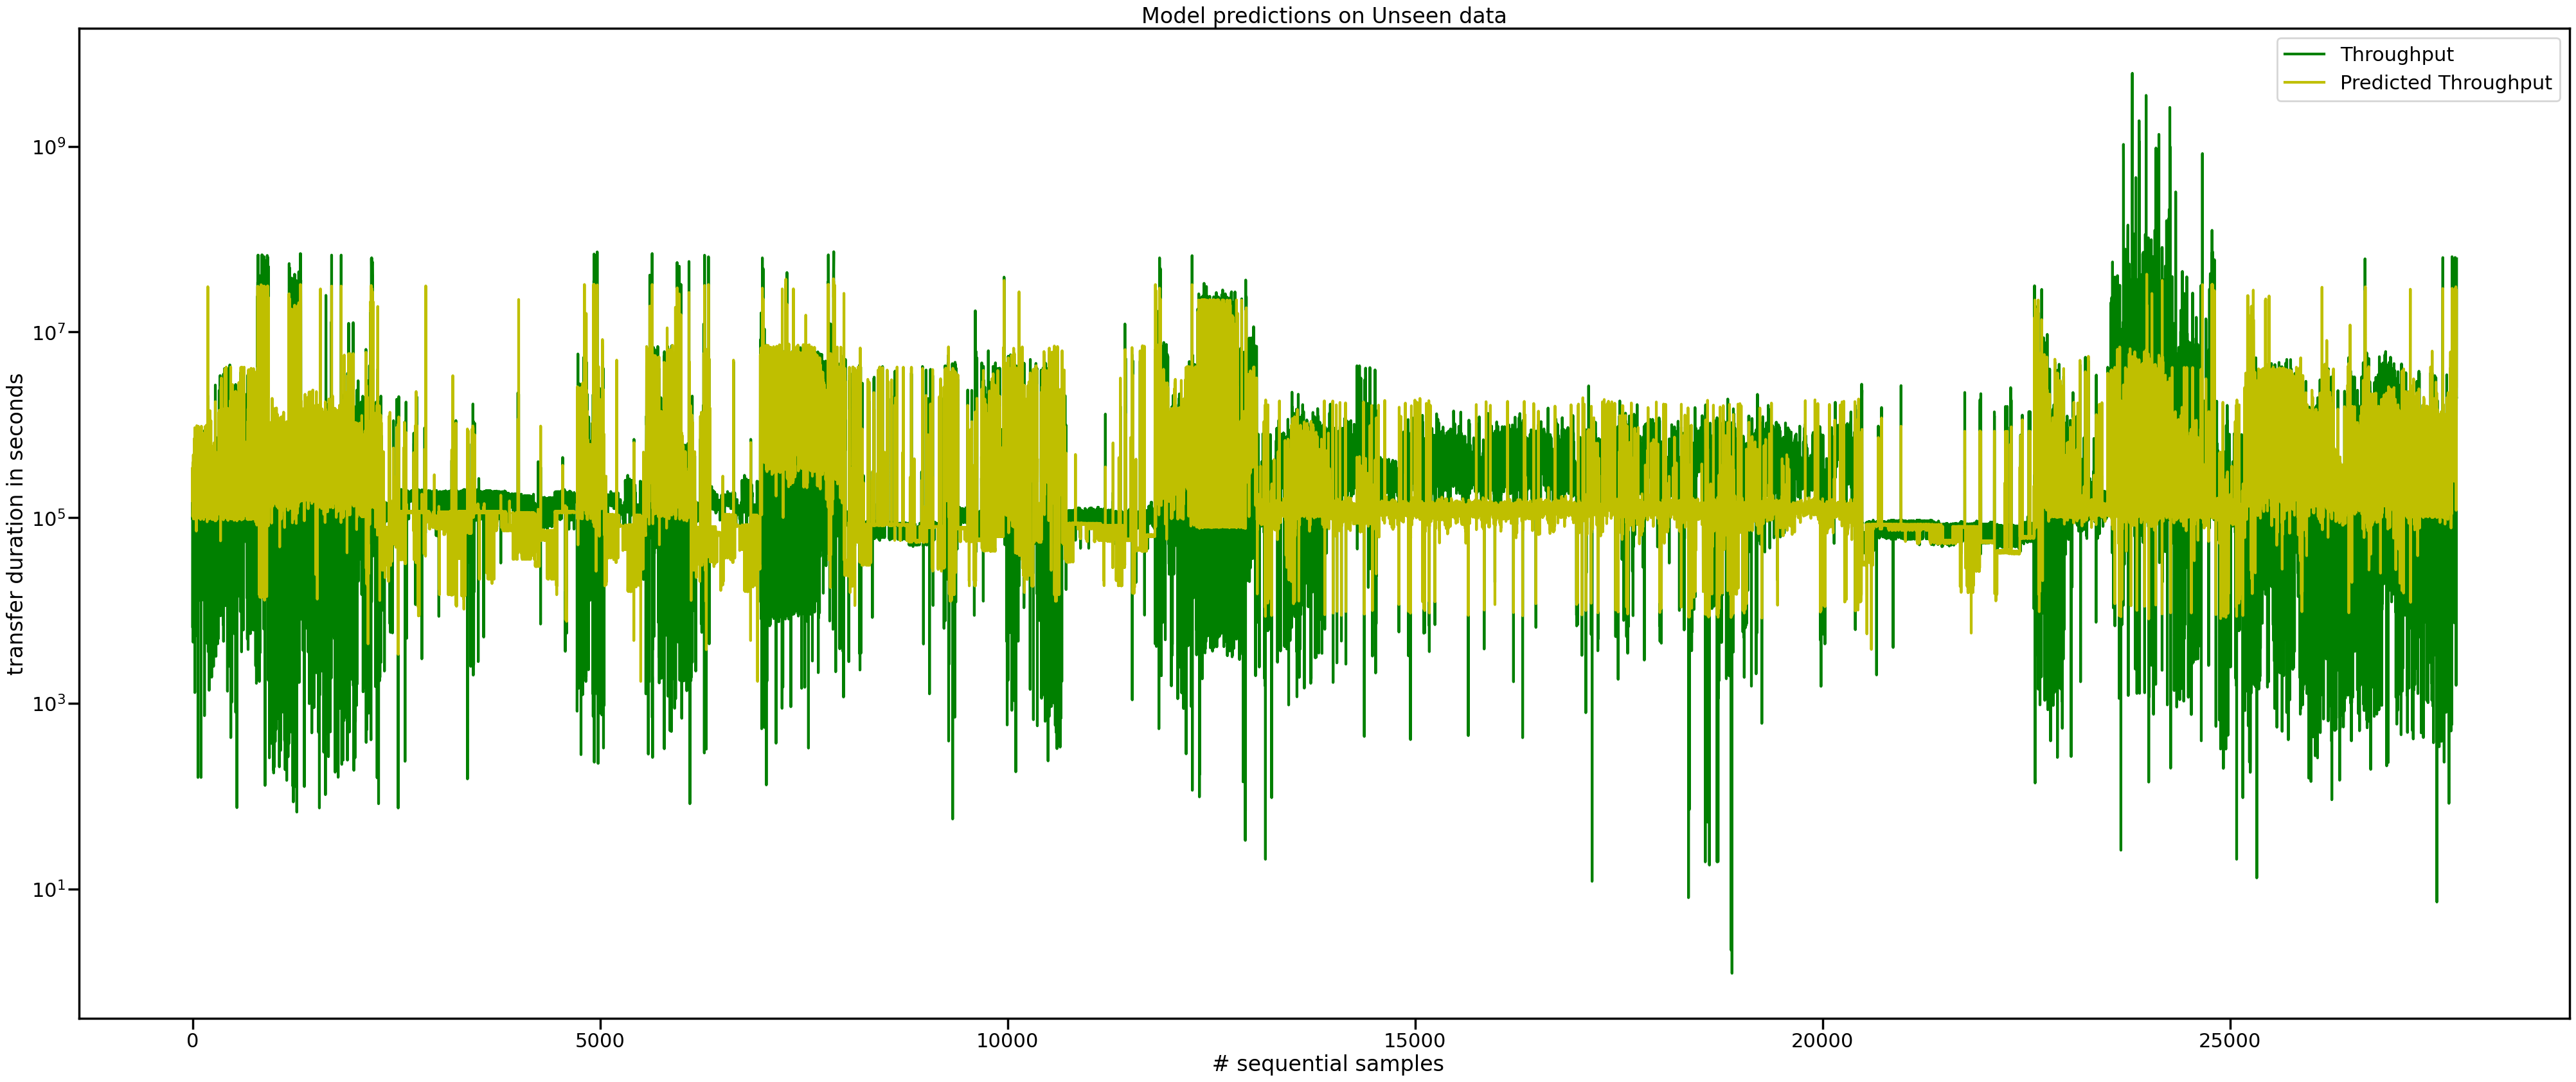

In [50]:
print ("Checking Closure")
data_full = X[features].copy()
throughput_full_pred = model2.predict(data_full,batch_size=256, verbose=1)
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y.to_numpy(), 'g', label='Throughput')
plt.plot(throughput_full_pred, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

## Save the Model

In [51]:
print("Saving the Model for the Test Samples")
saved_model_path = '/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel'
if not os.path.exists(saved_model_path) :
    model2.save(saved_model_path)

INFO:tensorflow:Assets written to: /opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel/assets


INFO:tensorflow:Assets written to: /opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel/assets


In [ ]:
sys.exit()

In [42]:
### Model 1

In [43]:
#def init_model(input_dim=5):
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
input_shape = [X_train.shape[1]]

start_time= time.time()
print('Compiling model ...')

model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=512, activation='tanh', input_shape=input_shape),
    layers.Dense(units=512, activation='linear'),
    layers.LeakyReLU(alpha=0.001),
    layers.Dense(units=512, activation='tanh'),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=256, activation='linear'),
    layers.Dense(units=128, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

adam = Adam(lr=0.0002, decay = 0.00001)


model.compile(
    optimizer=adam,
    loss='mse',
    metrics=['mean_squared_error'],
)

Compiling model ...


2023-03-16 20:05:08.930014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64::/home/bockjoo/services/external/webisoget-2.8.4/lib:/usr/lib/x86_64-linux-gnu
2023-03-16 20:05:08.930055: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 20:05:08.930089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cms.ufhpc): /proc/driver/nvidia/version does not exist
/opt/cms/services/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
history = LossHistory()

Training model...
Epoch 1/128
87/87 [==============================] - 2s 16ms/step - loss: 2293824458063872.0000 - mean_squared_error: 2293824458063872.0000 - val_loss: 4263654836928512.0000 - val_mean_squared_error: 4263654836928512.0000
Epoch 2/128
87/87 [==============================] - 1s 13ms/step - loss: 2293807009759232.0000 - mean_squared_error: 2293807009759232.0000 - val_loss: 4263599002353664.0000 - val_mean_squared_error: 4263599002353664.0000
Epoch 3/128
87/87 [==============================] - 1s 13ms/step - loss: 2293753322668032.0000 - mean_squared_error: 2293753322668032.0000 - val_loss: 4263473642995712.0000 - val_mean_squared_error: 4263473642995712.0000
Epoch 4/128
87/87 [==============================] - 1s 13ms/step - loss: 2293657222774784.0000 - mean_squared_error: 2293657222774784.0000 - val_loss: 4263262921162752.0000 - val_mean_squared_error: 4263262921162752.0000
Epoch 5/128
87/87 [==============================] - 1s 13ms/step - loss: 2293457775230976.000

Epoch 38/128
87/87 [==============================] - 1s 13ms/step - loss: 2287203765977088.0000 - mean_squared_error: 2287203765977088.0000 - val_loss: 4249668812800000.0000 - val_mean_squared_error: 4249668812800000.0000
Epoch 39/128
87/87 [==============================] - 1s 14ms/step - loss: 2287059616137216.0000 - mean_squared_error: 2287059616137216.0000 - val_loss: 4250545254563840.0000 - val_mean_squared_error: 4250545254563840.0000
Epoch 40/128
87/87 [==============================] - 1s 14ms/step - loss: 2286821245452288.0000 - mean_squared_error: 2286821245452288.0000 - val_loss: 4250518411018240.0000 - val_mean_squared_error: 4250518411018240.0000
Epoch 41/128
87/87 [==============================] - 1s 13ms/step - loss: 2286821245452288.0000 - mean_squared_error: 2286821245452288.0000 - val_loss: 4249687066411008.0000 - val_mean_squared_error: 4249687066411008.0000
Epoch 42/128
87/87 [==============================] - 1s 14ms/step - loss: 2286620455731200.0000 - mean_squa

Epoch 75/128
87/87 [==============================] - 1s 13ms/step - loss: 2283810741813248.0000 - mean_squared_error: 2283810741813248.0000 - val_loss: 4247407244083200.0000 - val_mean_squared_error: 4247407244083200.0000
Epoch 76/128
87/87 [==============================] - 1s 13ms/step - loss: 2283718668451840.0000 - mean_squared_error: 2283718668451840.0000 - val_loss: 4248134167298048.0000 - val_mean_squared_error: 4248134167298048.0000
Epoch 77/128
87/87 [==============================] - 1s 13ms/step - loss: 2283531032068096.0000 - mean_squared_error: 2283531032068096.0000 - val_loss: 4246743671635968.0000 - val_mean_squared_error: 4246743671635968.0000
Epoch 78/128
87/87 [==============================] - 1s 13ms/step - loss: 2283297224785920.0000 - mean_squared_error: 2283297224785920.0000 - val_loss: 4247771242561536.0000 - val_mean_squared_error: 4247771242561536.0000
Epoch 79/128
87/87 [==============================] - 1s 13ms/step - loss: 2283669544763392.0000 - mean_squa

Epoch 112/128
87/87 [==============================] - 1s 15ms/step - loss: 2280949756723200.0000 - mean_squared_error: 2280949756723200.0000 - val_loss: 4243747663511552.0000 - val_mean_squared_error: 4243747663511552.0000
Epoch 113/128
87/87 [==============================] - 1s 15ms/step - loss: 2281125045075968.0000 - mean_squared_error: 2281125045075968.0000 - val_loss: 4244487740063744.0000 - val_mean_squared_error: 4244487740063744.0000
Epoch 114/128
87/87 [==============================] - 1s 14ms/step - loss: 2280857683361792.0000 - mean_squared_error: 2280857683361792.0000 - val_loss: 4243784170733568.0000 - val_mean_squared_error: 4243784170733568.0000
Epoch 115/128
87/87 [==============================] - 1s 13ms/step - loss: 2279916280217600.0000 - mean_squared_error: 2279916280217600.0000 - val_loss: 4247445630353408.0000 - val_mean_squared_error: 4247445630353408.0000
Epoch 116/128
87/87 [==============================] - 1s 13ms/step - loss: 2280707896377344.0000 - mean

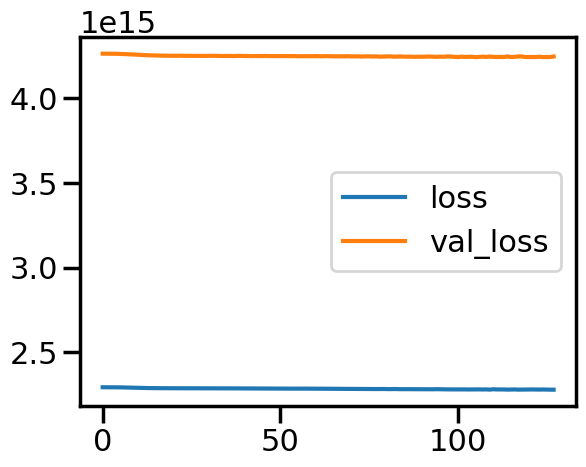

In [45]:
epochs=128 ; batch=256
print('Training model...')
#training = model.fit(trainX, trainY, 
#                     epochs=epochs, batch_size=batch,
#                     callbacks=[history, TQDMNotebookCallback(leave_inner=True)],
#                     validation_split=0.1, verbose=0)
training = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=batch,
        epochs=epochs,
        callbacks=[history], # put your callbacks in a list
        verbose=1,  # turn off training log
    )

history_df = pd.DataFrame(training.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

## Check Closure

109/109 [==============================] - 1s 4ms/step


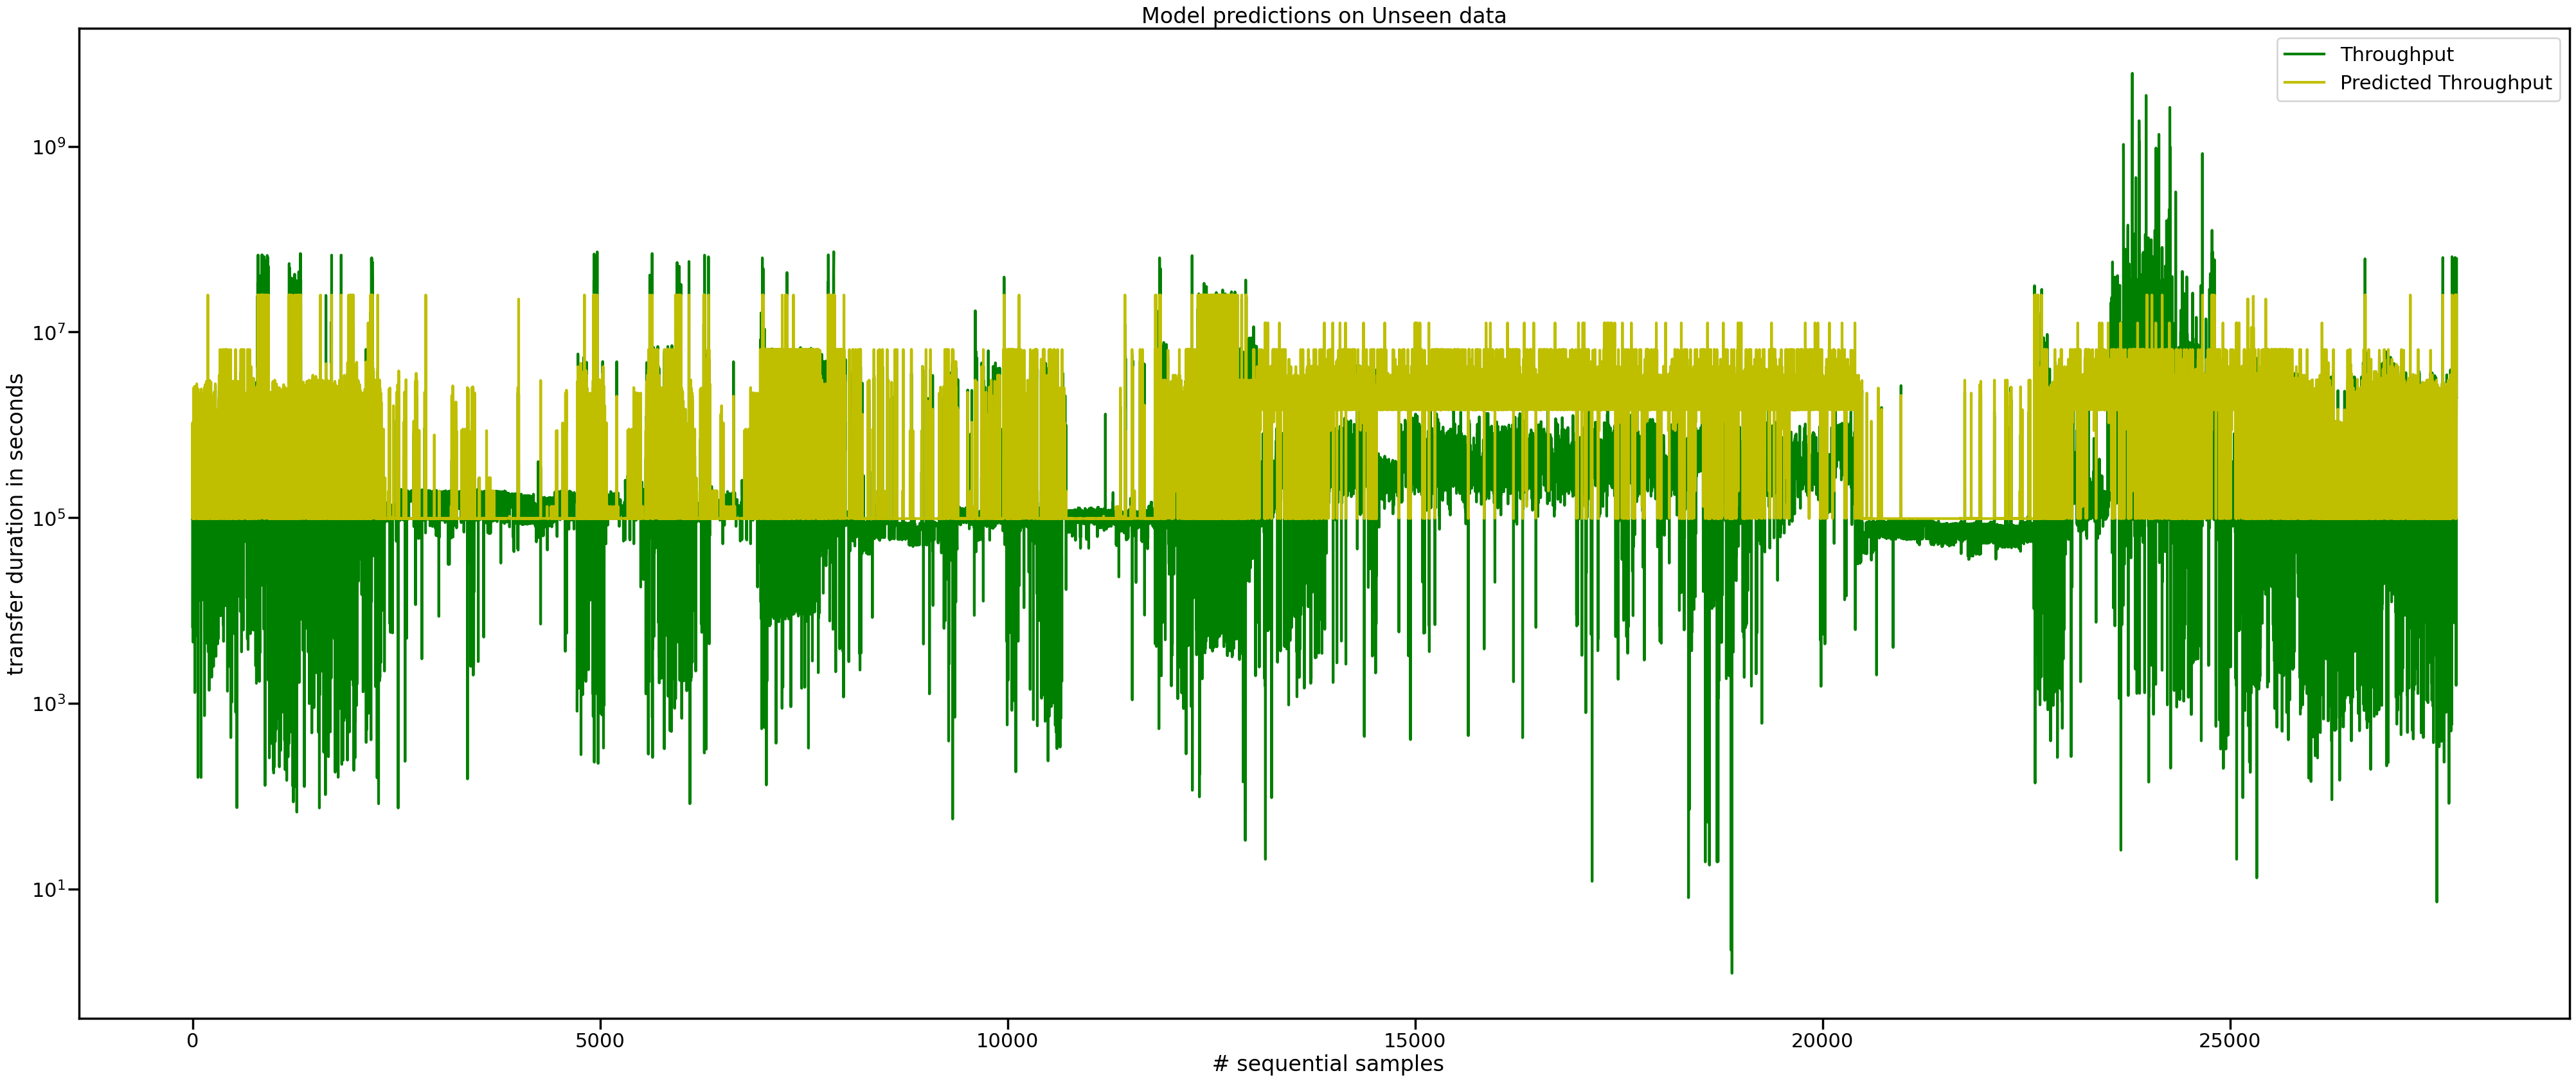

In [46]:
data_full = X[features].copy()
throughput_full_pred = model.predict(data_full,batch_size=256, verbose=1)
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y.to_numpy(), 'g', label='Throughput')
plt.plot(throughput_full_pred, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

In [44]:
# Meaningless???
#history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [46]:
model2.save('/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel')


INFO:tensorflow:Assets written to: /opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel/assets


INFO:tensorflow:Assets written to: /opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel/assets


In [47]:
!file /opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel

/opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel: directory


In [48]:
!ls /opt/cms/services/T2/ops/Work/CHEP2023/chep2023XRDMonitoringDataDeepLearningTake3_3_1_SavedModel

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
sys.exit()

In [52]:
## Model 3

In [53]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/500
87/87 [==============================] - 4s 34ms/step - loss: 29937264.0000 - val_loss: 2841162.5000
Epoch 2/500
87/87 [==============================] - 3s 32ms/step - loss: 1768811.8750 - val_loss: 2760463.2500
Epoch 3/500
87/87 [==============================] - 3s 31ms/step - loss: 1728185.7500 - val_loss: 2782218.2500
Epoch 4/500
87/87 [==============================] - 3s 33ms/step - loss: 1716886.5000 - val_loss: 2807158.2500
Epoch 5/500
87/87 [==============================] - 3s 31ms/step - loss: 1706399.1250 - val_loss: 2724724.5000
Epoch 6/500
87/87 [==============================] - 3s 31ms/step - loss: 1706812.1250 - val_loss: 2727323.5000
Epoch 7/500
87/87 [==============================] - 3s 31ms/step - loss: 1710715.8750 - val_loss: 2757996.0000
Epoch 8/500
87/87 [==============================] - 3s 33ms/step - loss: 1709238.2500 - val_loss: 2717812.0000
Epoch 9/500
87/87 [==============================] - 3s 32ms/step - loss: 1687546.6250 - val_loss: 2774

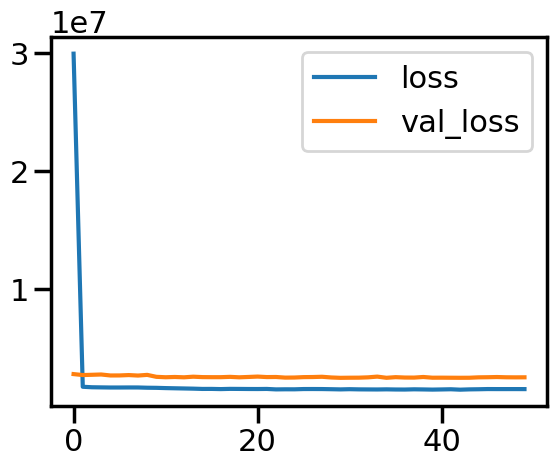

In [54]:
start_time= time.time()
model3 = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1),
])


model3.compile(
    optimizer='adam',
    loss='mae',
)

training = model3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,
)

history_df = pd.DataFrame(training.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

## Check Closure

109/109 [==============================] - 1s 7ms/step


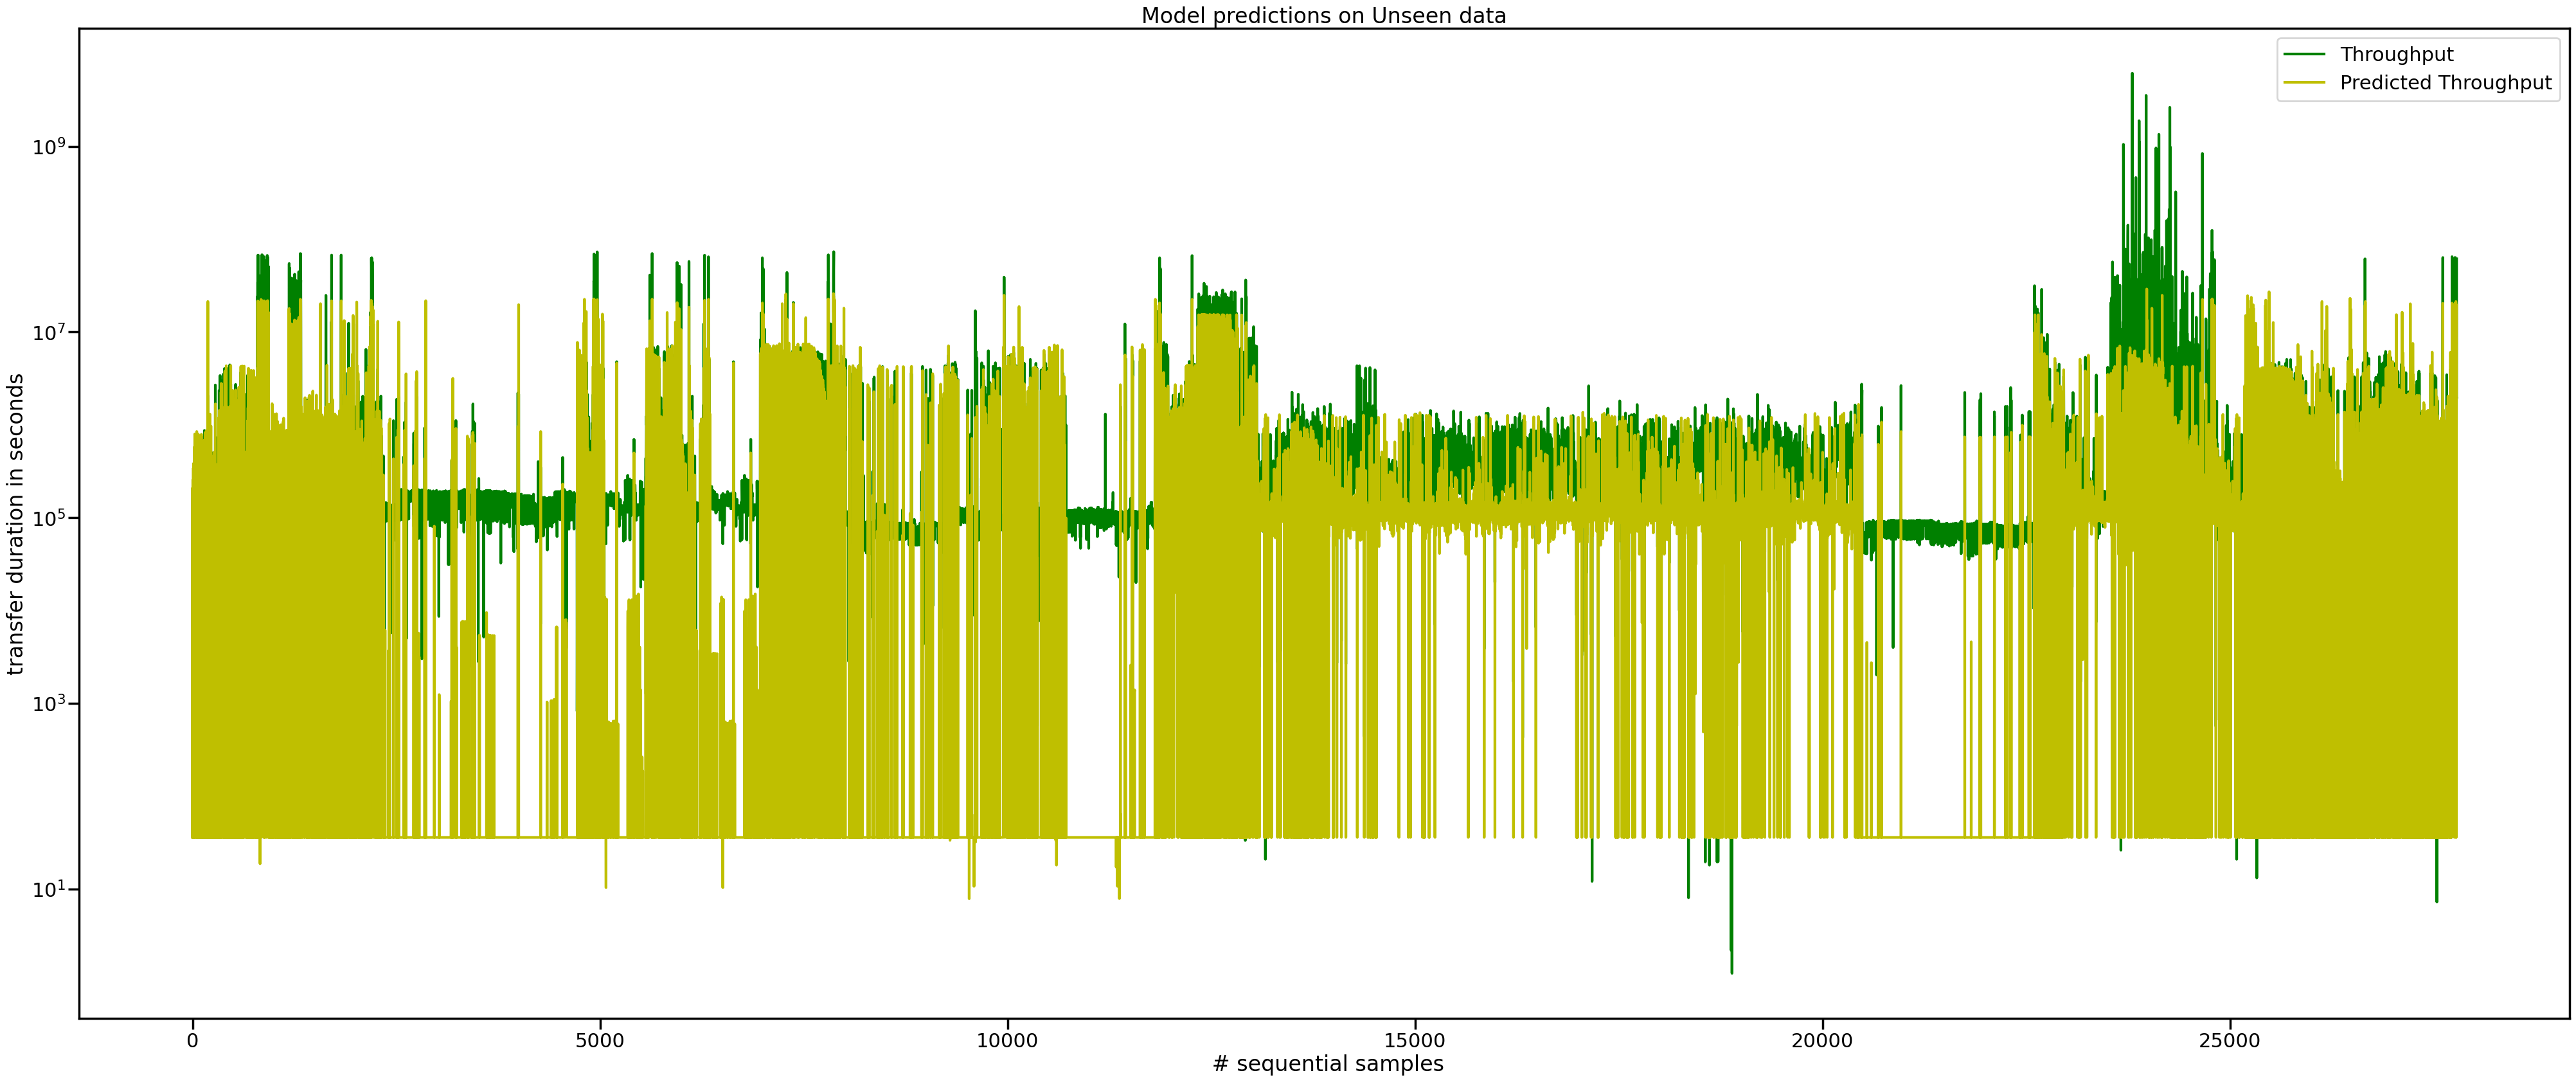

In [55]:
data_full = X[features].copy()
throughput_full_pred = model3.predict(data_full,batch_size=256, verbose=1)
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y.to_numpy(), 'g', label='Throughput')
plt.plot(throughput_full_pred, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

In [56]:
### Model 2-1

Minimum validation loss: 4165380079616000.0


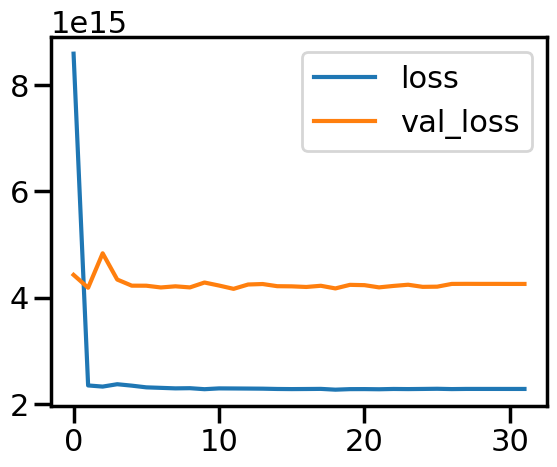

In [58]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model2_1 = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=512, activation='relu', input_shape=input_shape),
    layers.Dense(units=512, activation='relu'),
    layers.Dense(units=512, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

model2_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy'],
)
#model2_1.compile(loss='mean_squared_error', optimizer='adam', metric=['mean_squared_error'])

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model2_1.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

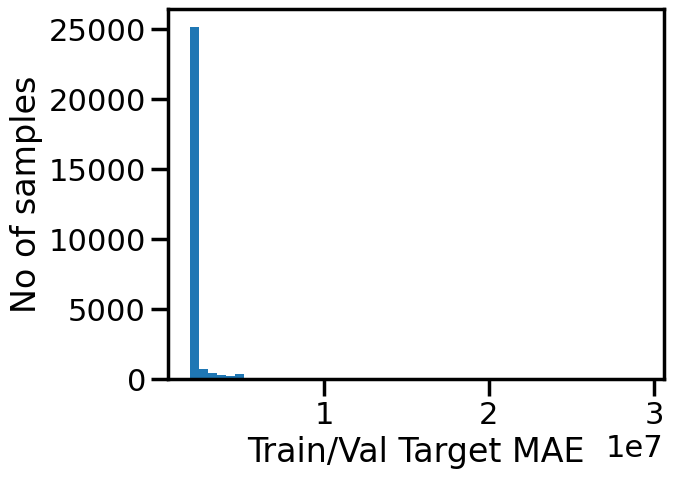

In [60]:
# MAE for Train and Validation Sample
mae_train_val = np.mean(np.abs(throughput_full_pred - y.to_numpy() ), axis=1)
plt.hist(mae_train_val, bins=50)
plt.xlabel("Train/Val Target MAE")
plt.ylabel("No of samples")
plt.show()

In [61]:
# Get the threshold.
threshold = np.max(mae_train_val)
print("MAE Train/Val error threshold: ", threshold)

MAE Train/Val error threshold:  29213097.44953707


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


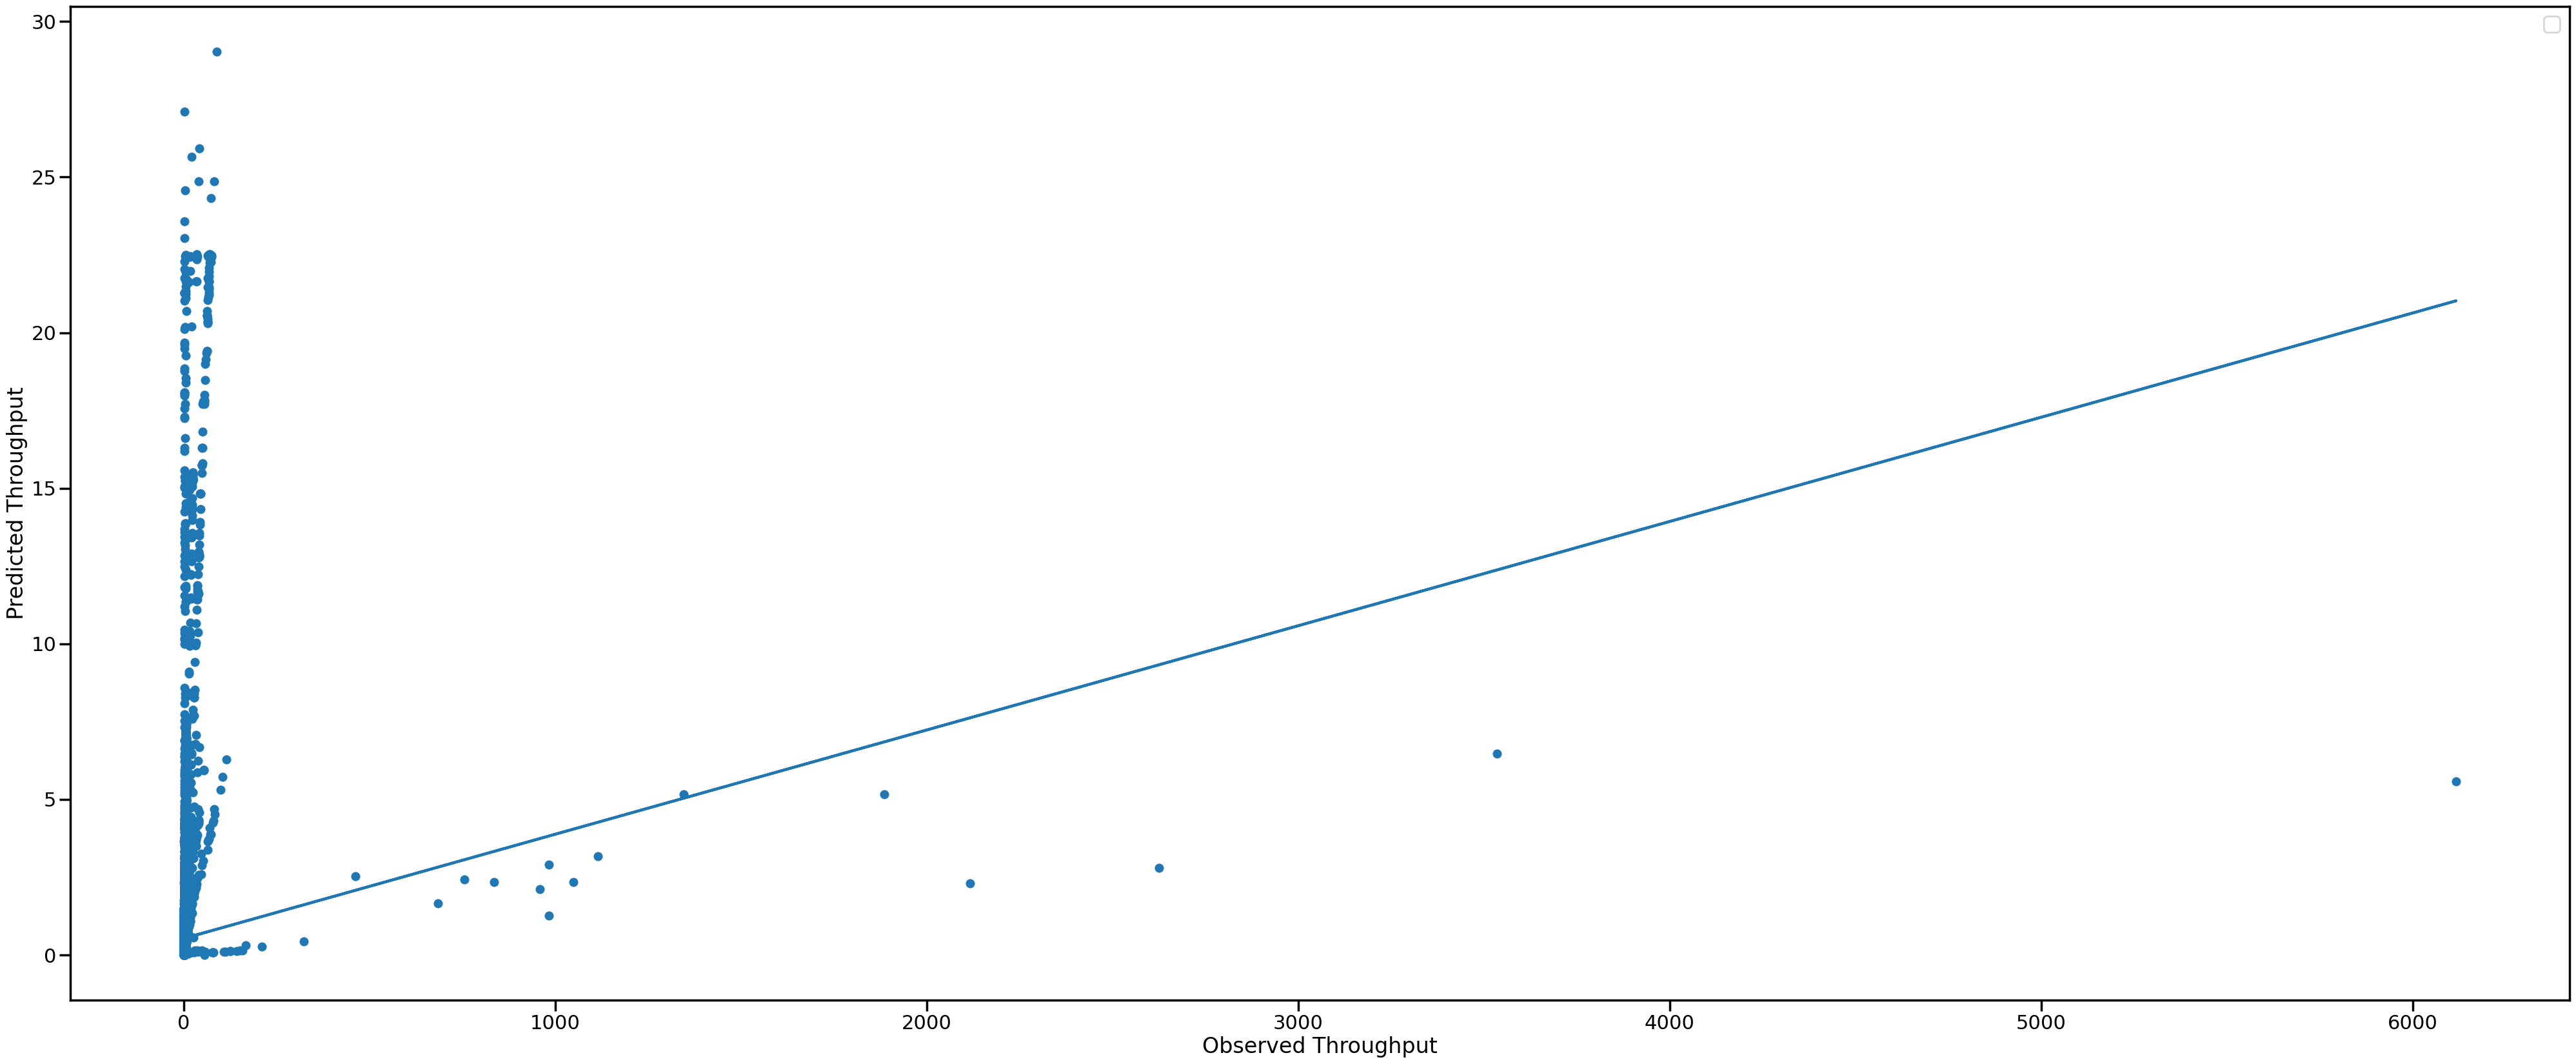

In [62]:
sns.set_context('poster')
Y = y
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(Y.to_numpy()/scale_me, throughput_full_pred/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
m, b = np.polyfit(Y.to_numpy()/scale_me, throughput_full_pred/scale_me,  1)
plt.plot(Y.to_numpy()/scale_me, m*(Y.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Observed Throughput')
plt.ylabel('Predicted Throughput')
#plt.yscale("log")
plt.show()

## Test Sample

In [63]:
#df_test = get_test_sample ()
testcsv = 'chep2023XRDMonitoringDataDeepLearning_test.csv'
df_test = pd.read_csv( testcsv, low_memory=False)

### Preprocess Data

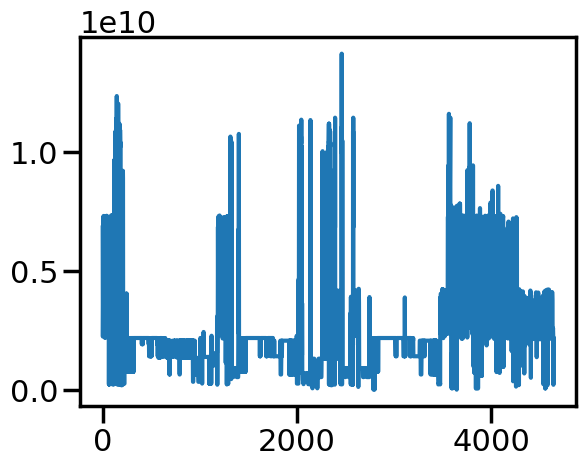

In [64]:
fig, ax = plt.subplots()

xrdcoll_test_data = df_test.loc[df_test['throughput'] > throughput]
xrdcoll_test_data = xrdcoll_test_data.loc[xrdcoll_test_data['site_name'] == site]
xrdcoll_test_data = xrdcoll_test_data.loc[xrdcoll_test_data['operation'] == operation]
xrdcoll_test_data = xrdcoll_test_data.loc[xrdcoll_test_data['user_protocol'] == user_protocol]
xrdcoll_test_data = xrdcoll_test_data.loc[xrdcoll_test_data['client_domain'] == client_domain]
xrdcoll_test_data[f'read_btyes/file_size'] = xrdcoll_test_data['read_bytes'].div(xrdcoll_test_data['file_size'])
xrdcoll_test_data["file_size"].plot(legend=False, ax=ax)
plt.show()

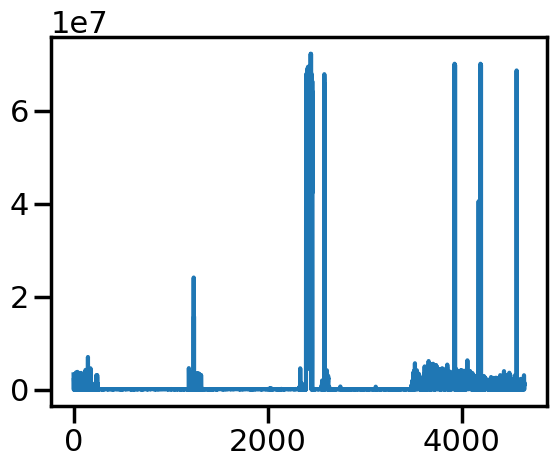

In [65]:
fig, ax = plt.subplots()
xrdcoll_test_data["throughput"].plot(legend=False, ax=ax)
plt.show()

In [66]:
X_test, y_test = select_features_and_target ( xrdcoll_test_data, features=features, target = 'throughput' )
X_test = train_encoders_fit_transform(X_test, use_cache=False)

In [67]:
X_test.head()

file_size  read_bytes  ipv6  server_host  read_btyes/file_size
0  6823905796  4527307154     1            2              0.663448
1  2244733417   763588442     1            2              0.340169
2  2244733417      891396     0            0              0.000397
3  3590714935     5412899     1            1              0.001507
4  3590714935  2378410319     1            2              0.662378

### Evaluate the model

In [68]:
mae = model.evaluate(X_test, y_test, verbose=0)
print (mae)

965790.4375


In [69]:
mae2 = model2.evaluate(X_test, y_test, verbose=0)
print (mae2)

[823752.8125, 0.0]


In [70]:
throughput_test_pred = model.predict(X_test,batch_size=256, verbose=1)

19/19 [==============================] - 0s 7ms/step


In [71]:
throughput_test_pred2 = model2.predict(X_test,batch_size=256, verbose=1)

19/19 [==============================] - 0s 3ms/step


In [72]:
mae = np.mean(np.abs(throughput_test_pred - y_test.to_numpy()), axis=1)

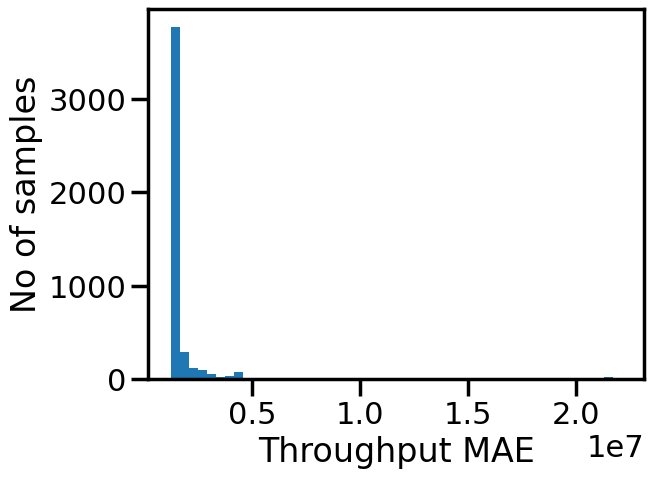

In [73]:
plt.hist(mae, bins=50)
plt.xlabel("Throughput MAE")
plt.ylabel("No of samples")
plt.show()

In [74]:
mae2 = np.mean(np.abs(throughput_test_pred2 - y_test.to_numpy()), axis=1)

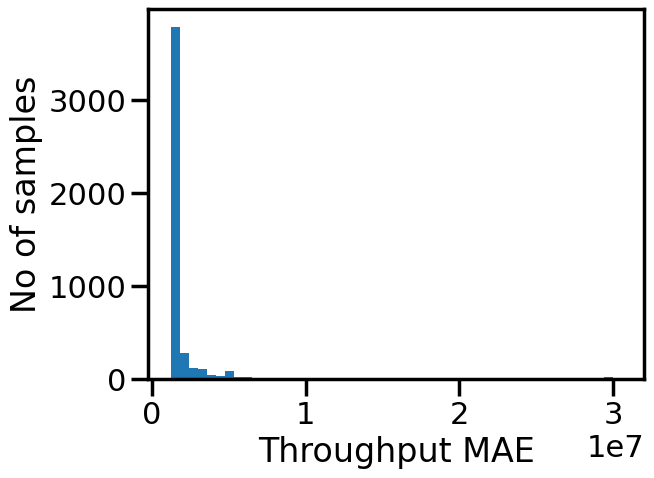

In [75]:
plt.hist(mae2, bins=50)
plt.xlabel("Throughput MAE")
plt.ylabel("No of samples")
plt.show()

In [76]:
mae_max = np.max(mae)
print("Max MAE with the Test Target ", mae_max)

Max MAE with the Test Target  22130165.391466975


In [77]:
mae2_max = np.max(mae2)
print("Max MAE with the Test Target ", mae2_max)

Max MAE with the Test Target  30550608.814737312


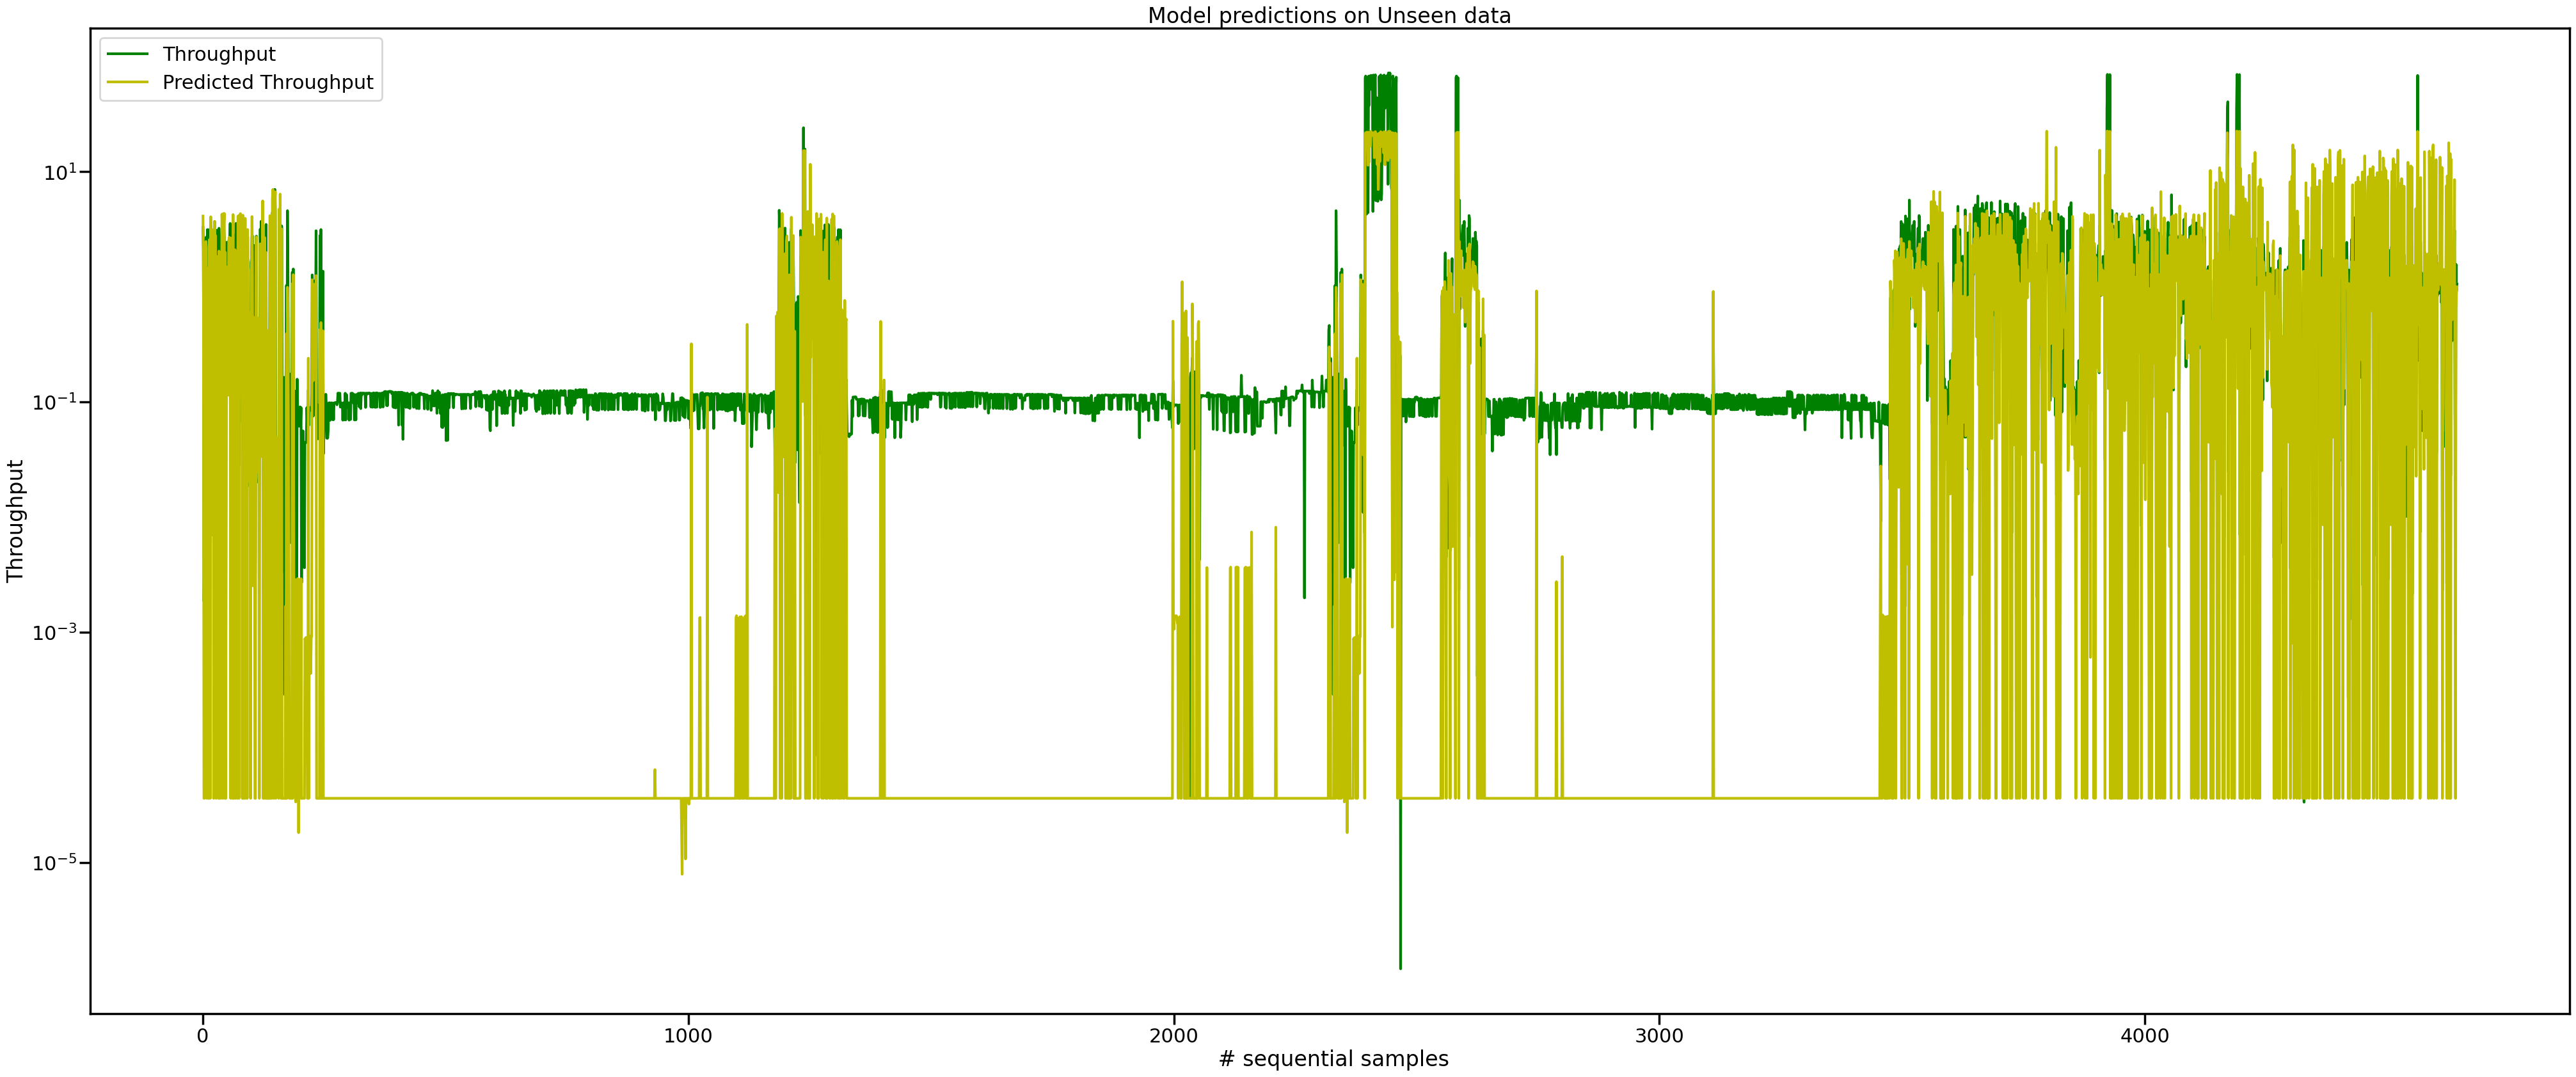

In [78]:
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

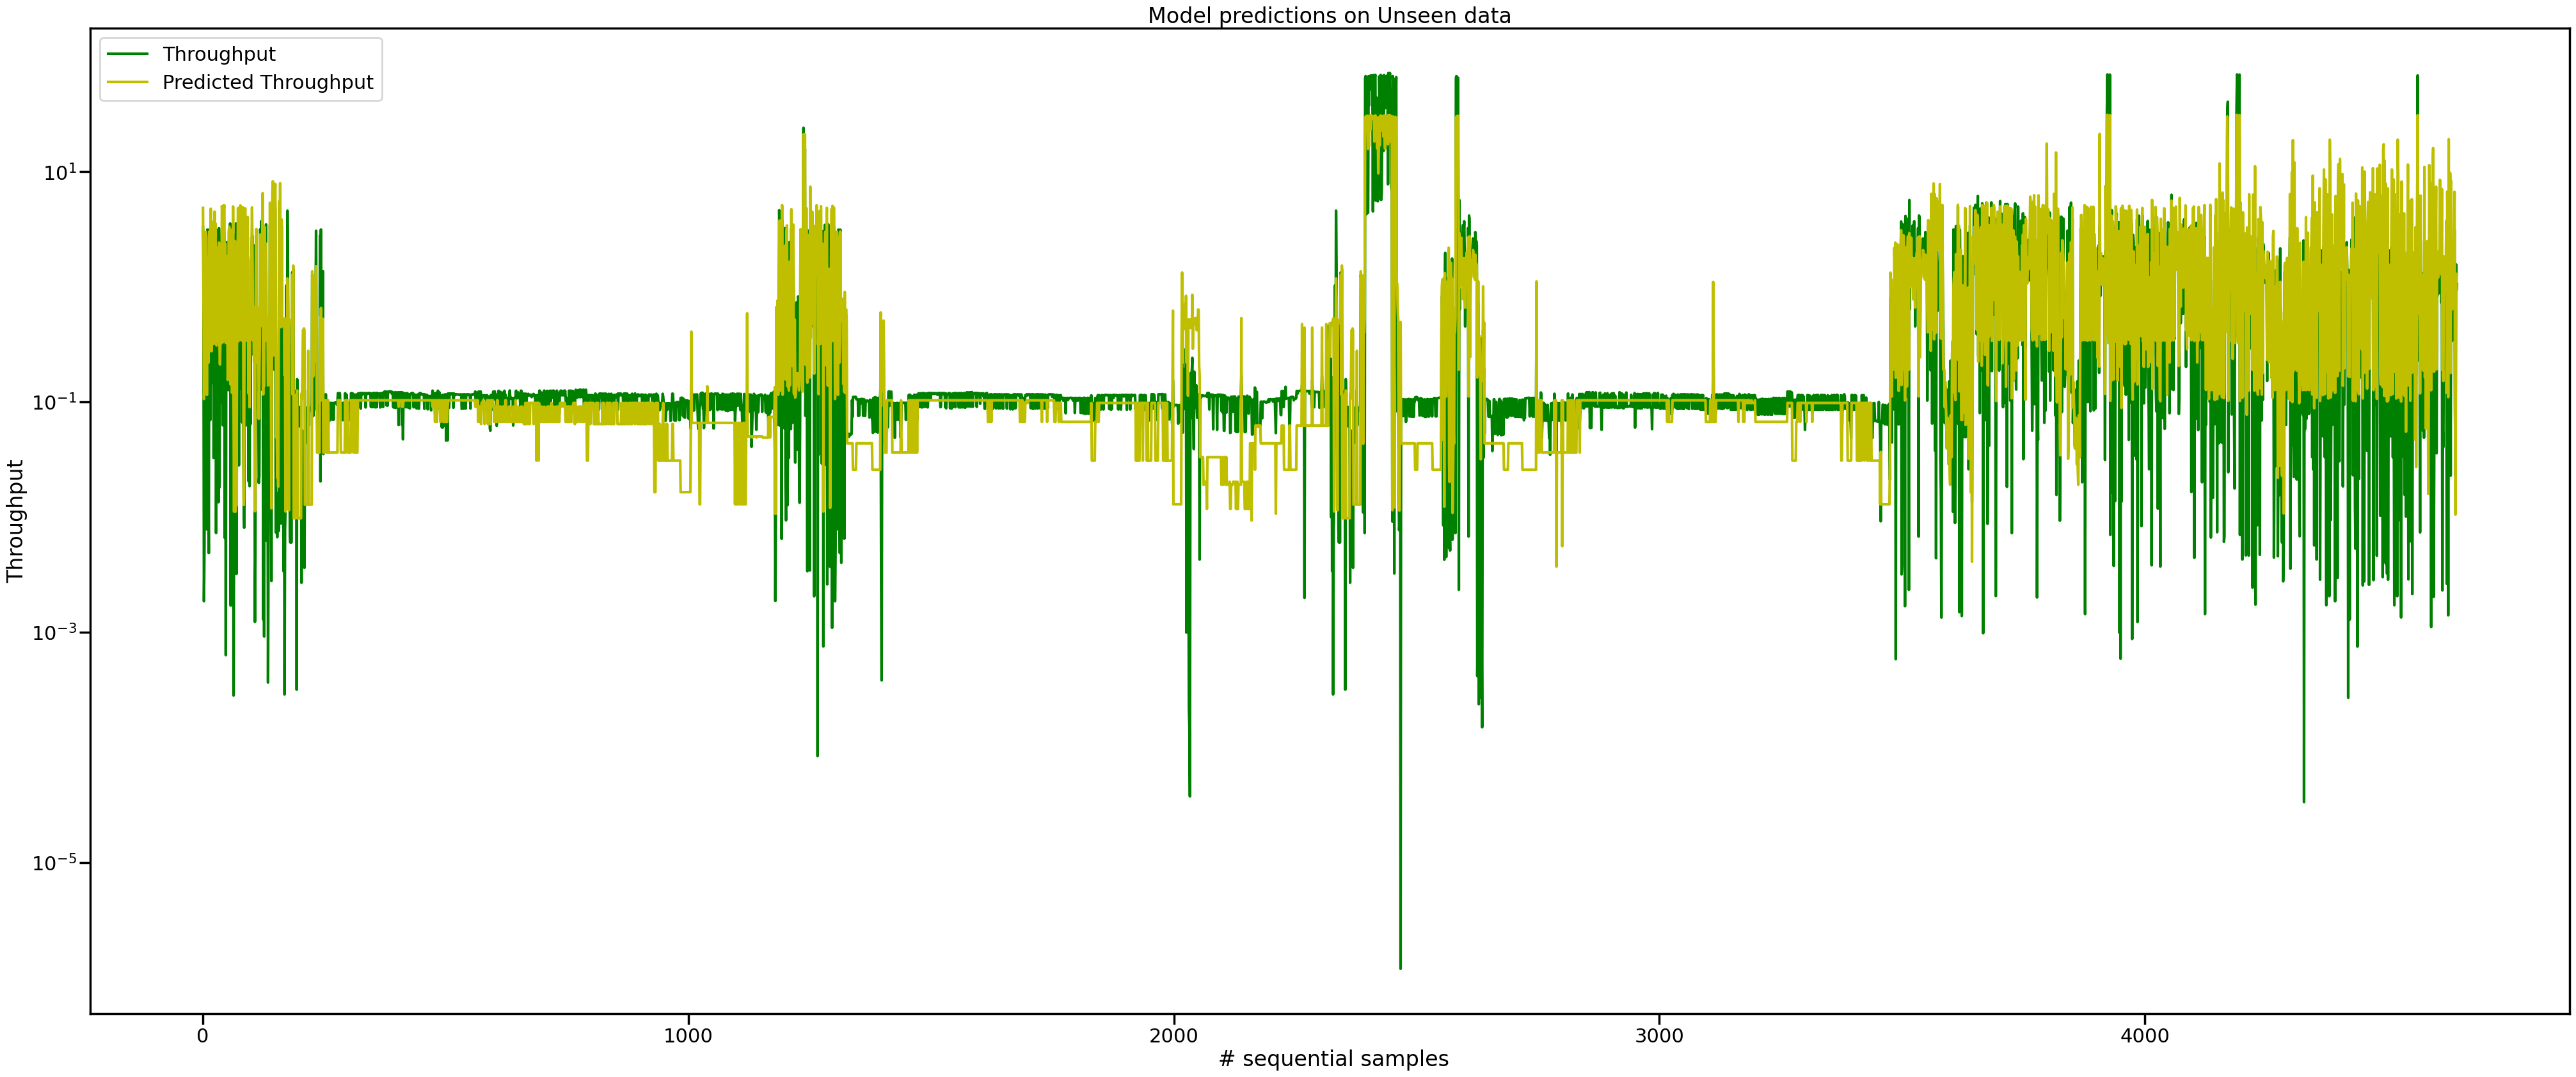

In [79]:
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
plt.plot(throughput_test_pred2/1000000, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

## Latest Test Sample

In [96]:
#testcsv = 'chep2023XRDMonitoringDataDeepLearning_test_latest.csv'
#df_test_latest = pd.read_csv( testcsv, low_memory=False)
df_test_latest = get_latest_test_sample ()

Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030206.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030212.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030200.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030218.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030300.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030306.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030312.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030318.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030400.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030406.csv.zip
Skipping /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollecto

In [97]:
#df_test_latest.to_csv('chep2023XRDMonitoringDataDeepLearning_test_latest.csv', index=False)

In [98]:
#!zip -r /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/chep2023XRDMonitoringDataDeepLearningTake3_2_test_latest.csv.zip chep2023XRDMonitoringDataDeepLearning_test_latest.csv

  adding: chep2023XRDMonitoringDataDeepLearning_test_latest.csv (deflated 81%)


In [99]:
#!rm -f chep2023XRDMonitoringDataDeepLearning_test_latest.csv ; ln -s /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/chep2023XRDMonitoringDataDeepLearningTake3_2_test_latest.csv.zip 

In [100]:
#!ls -al chep2023XRDMonitoringDataDeepLearningTake3_2_test_latest.csv.zip

lrwxrwxrwx 1 bockjoo avery 121 Mar 16 16:41 chep2023XRDMonitoringDataDeepLearningTake3_2_test_latest.csv.zip -> /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/chep2023XRDMonitoringDataDeepLearningTake3_2_test_latest.csv.zip


In [81]:
testcsv = 'chep2023XRDMonitoringDataDeepLearningTake3_2_test_latest.csv.zip'
df_test_latest = pd.read_csv( testcsv, low_memory=False, compression='zip')

In [93]:
df_test_latest = get_latest_test_sample ()

xrdcoll_test_latest_data = df_test_latest.loc[df_test_latest['throughput'] > throughput]
xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['site_name'] == site]
xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['operation'] == operation]
xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['user_protocol'] == user_protocol]
xrdcoll_test_latest_data = xrdcoll_test_latest_data.loc[xrdcoll_test_latest_data['client_domain'] == client_domain]
xrdcoll_test_latest_data[f'read_btyes/file_size'] = xrdcoll_test_latest_data['read_bytes'].div(xrdcoll_test_latest_data['file_size'])

X_test_latest, y_test_latest = select_features_and_target ( xrdcoll_test_latest_data, features=features, target = 'throughput' )
X_test_latest = train_encoders_fit_transform(X_test_latest, use_cache=False)

score = model2.evaluate(X_test_latest, y_test_latest, verbose=2)
print (score)

308/308 - 1s - loss: 365476.3438 - accuracy: 0.0000e+00 - 547ms/epoch - 2ms/step
[365476.34375, 0.0]


### Predict the throughput with the Model 2

39/39 [==============================] - 0s 3ms/step


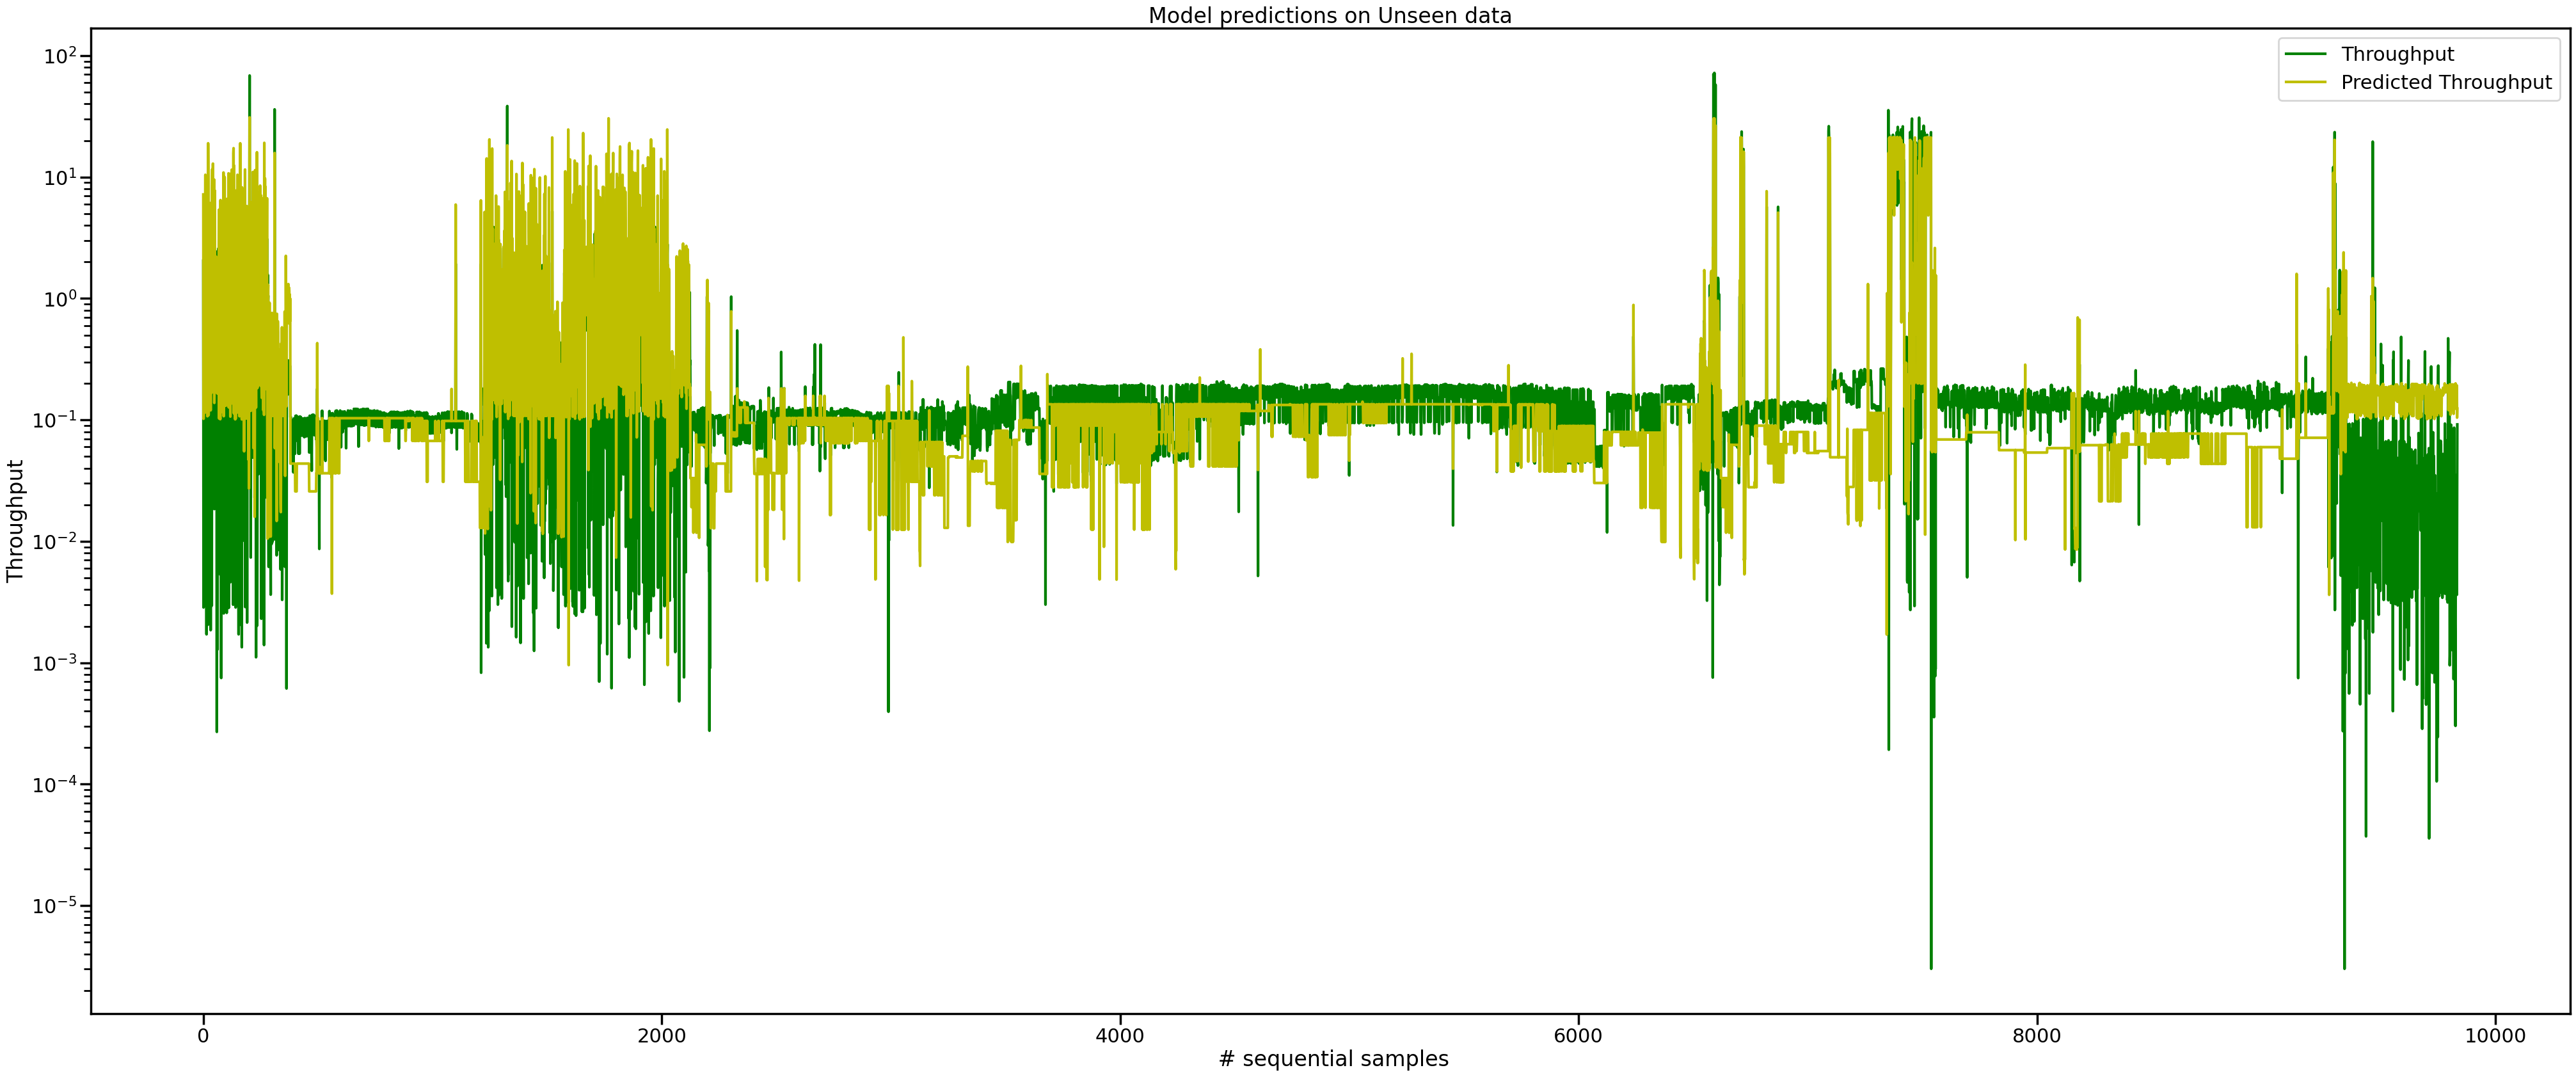

In [86]:
X_test_latest, y_test_latest = select_features_and_target ( xrdcoll_test_latest_data, features=features, target = 'throughput' )
X_test_latest = train_encoders_fit_transform(X_test_latest, use_cache=False)

throughput_test_latest_pred = model2.predict(X_test_latest,batch_size=256, verbose=1)

sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y_test_latest.to_numpy()/1000000, 'g', label='Throughput')
plt.plot(throughput_test_latest_pred/1000000, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('Throughput')
plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


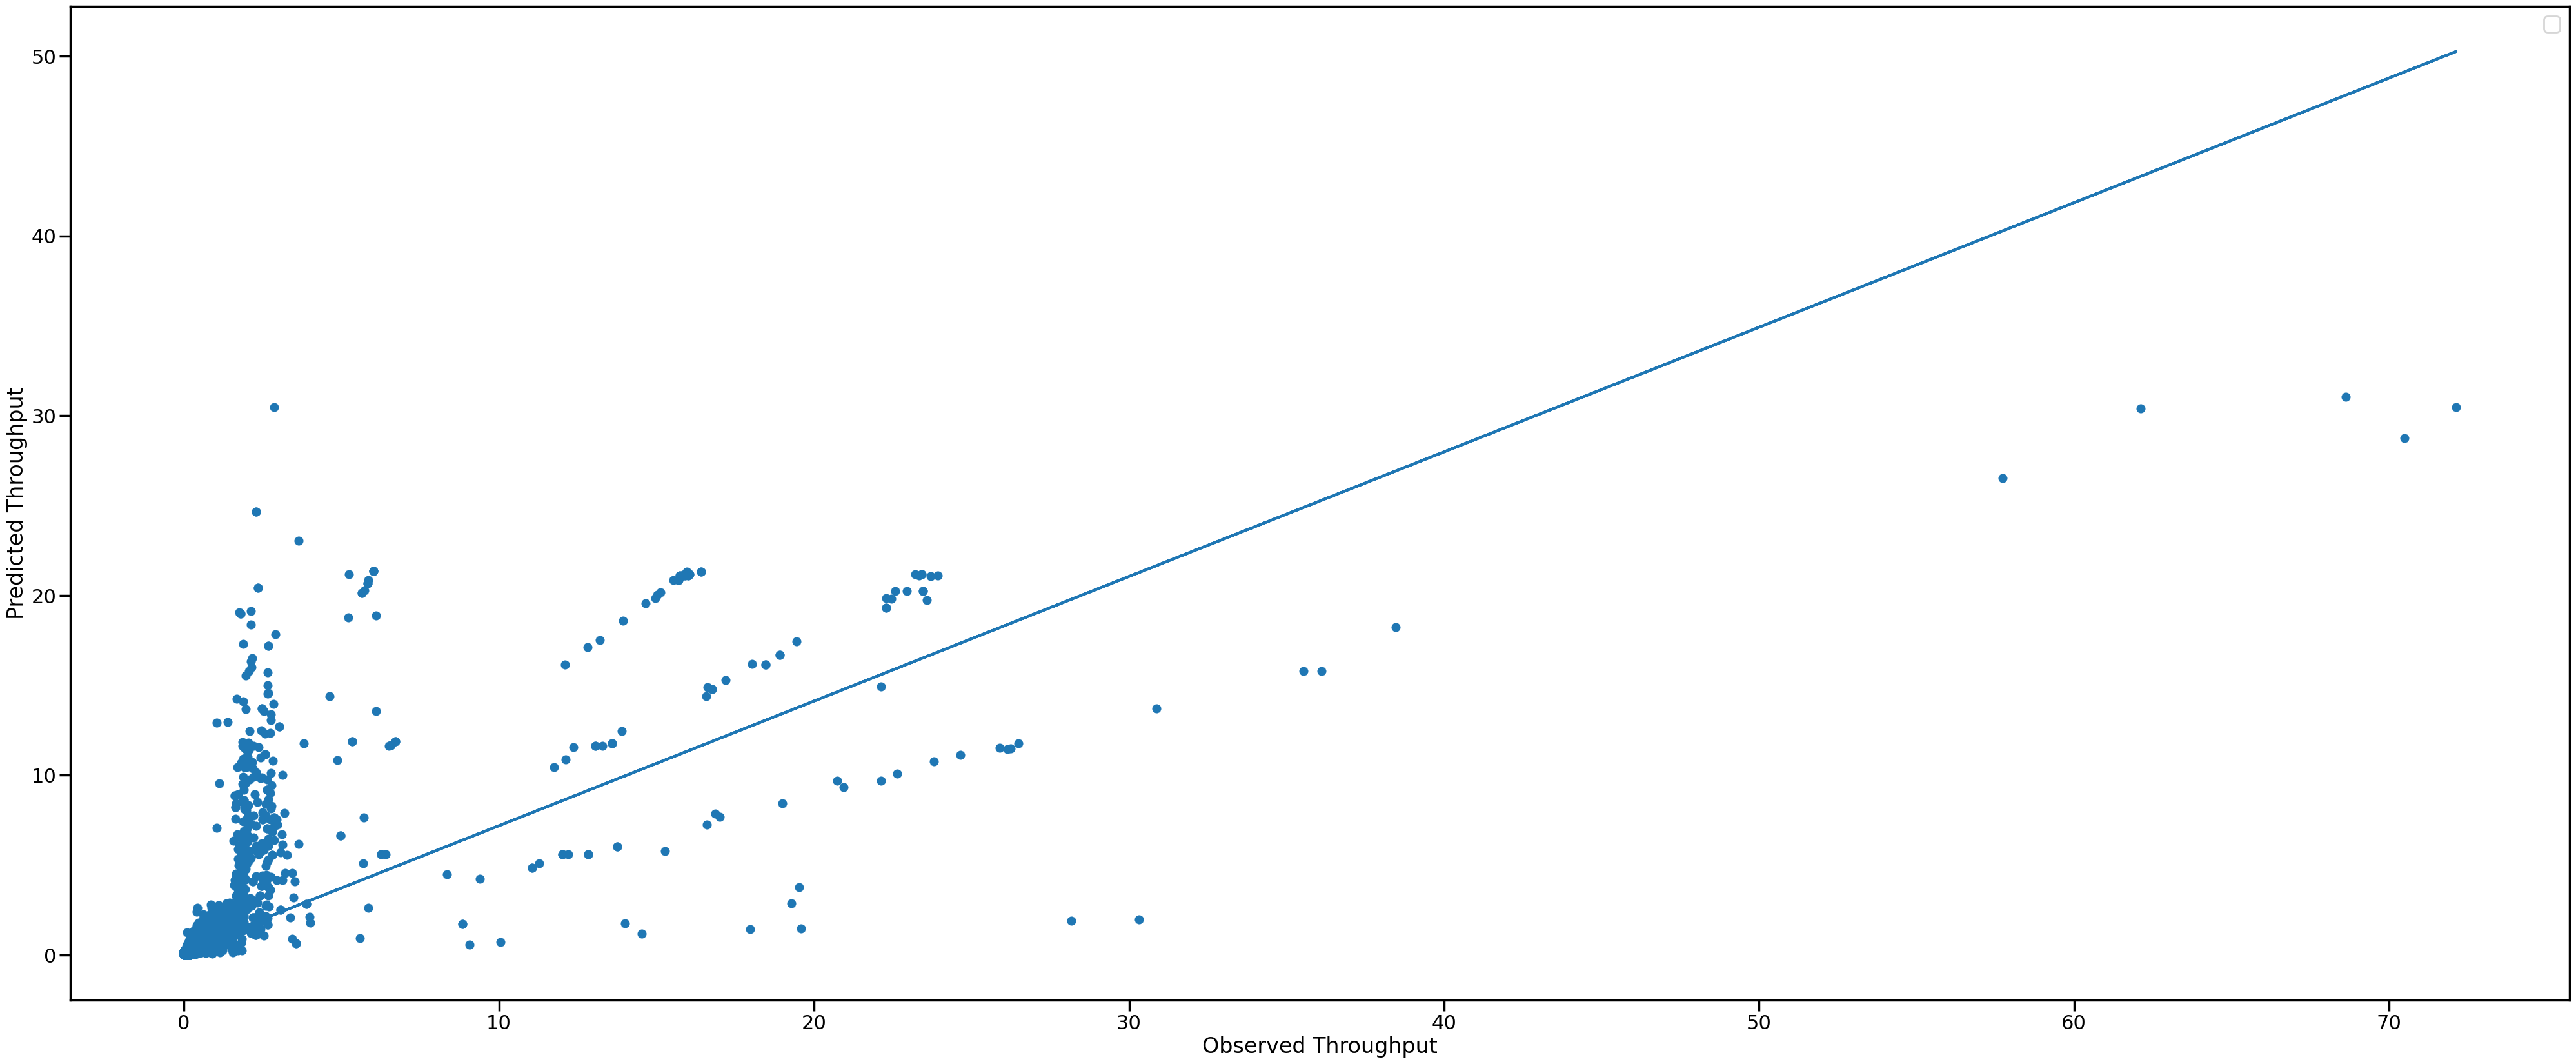

In [87]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(y_test_latest.to_numpy()/scale_me, throughput_test_latest_pred/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
m, b = np.polyfit(y_test_latest.to_numpy()/scale_me, throughput_test_latest_pred/scale_me, 1)
plt.plot(y_test_latest.to_numpy()/scale_me, m*(y_test_latest.to_numpy()/scale_me)+b)
plt.legend()
plt.xlabel('Observed Throughput')
plt.ylabel('Predicted Throughput')
#plt.yscale("log")
plt.show()

In [88]:
(y_test_latest.to_numpy() - throughput_test_latest_pred).mean()

-113332.15408117657

In [89]:
(y_test_latest.to_numpy() - throughput_test_latest_pred).max()

72121320.29529236

In [90]:
(y_test_latest.to_numpy() - throughput_test_latest_pred).min()

-31038846.98148148

In [91]:
throughput_test_latest_pred.mean()

581721.2

In [97]:
type(X_test_latest['read_bytes'])

pandas.core.series.Series

In [96]:
X_test_latest['read_bytes']

Index(['file_size', 'read_bytes', 'ipv6', 'server_host',
       'read_btyes/file_size'],
      dtype='object')

In [95]:
type(y_test_latest)

pandas.core.series.Series

In [99]:
X_test_latest['read_bytes'].shape

(9834,)

In [100]:
y_test_latest.shape

(9834,)

In [105]:
throughput_test_latest_pred[:,0].shape

(9834,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


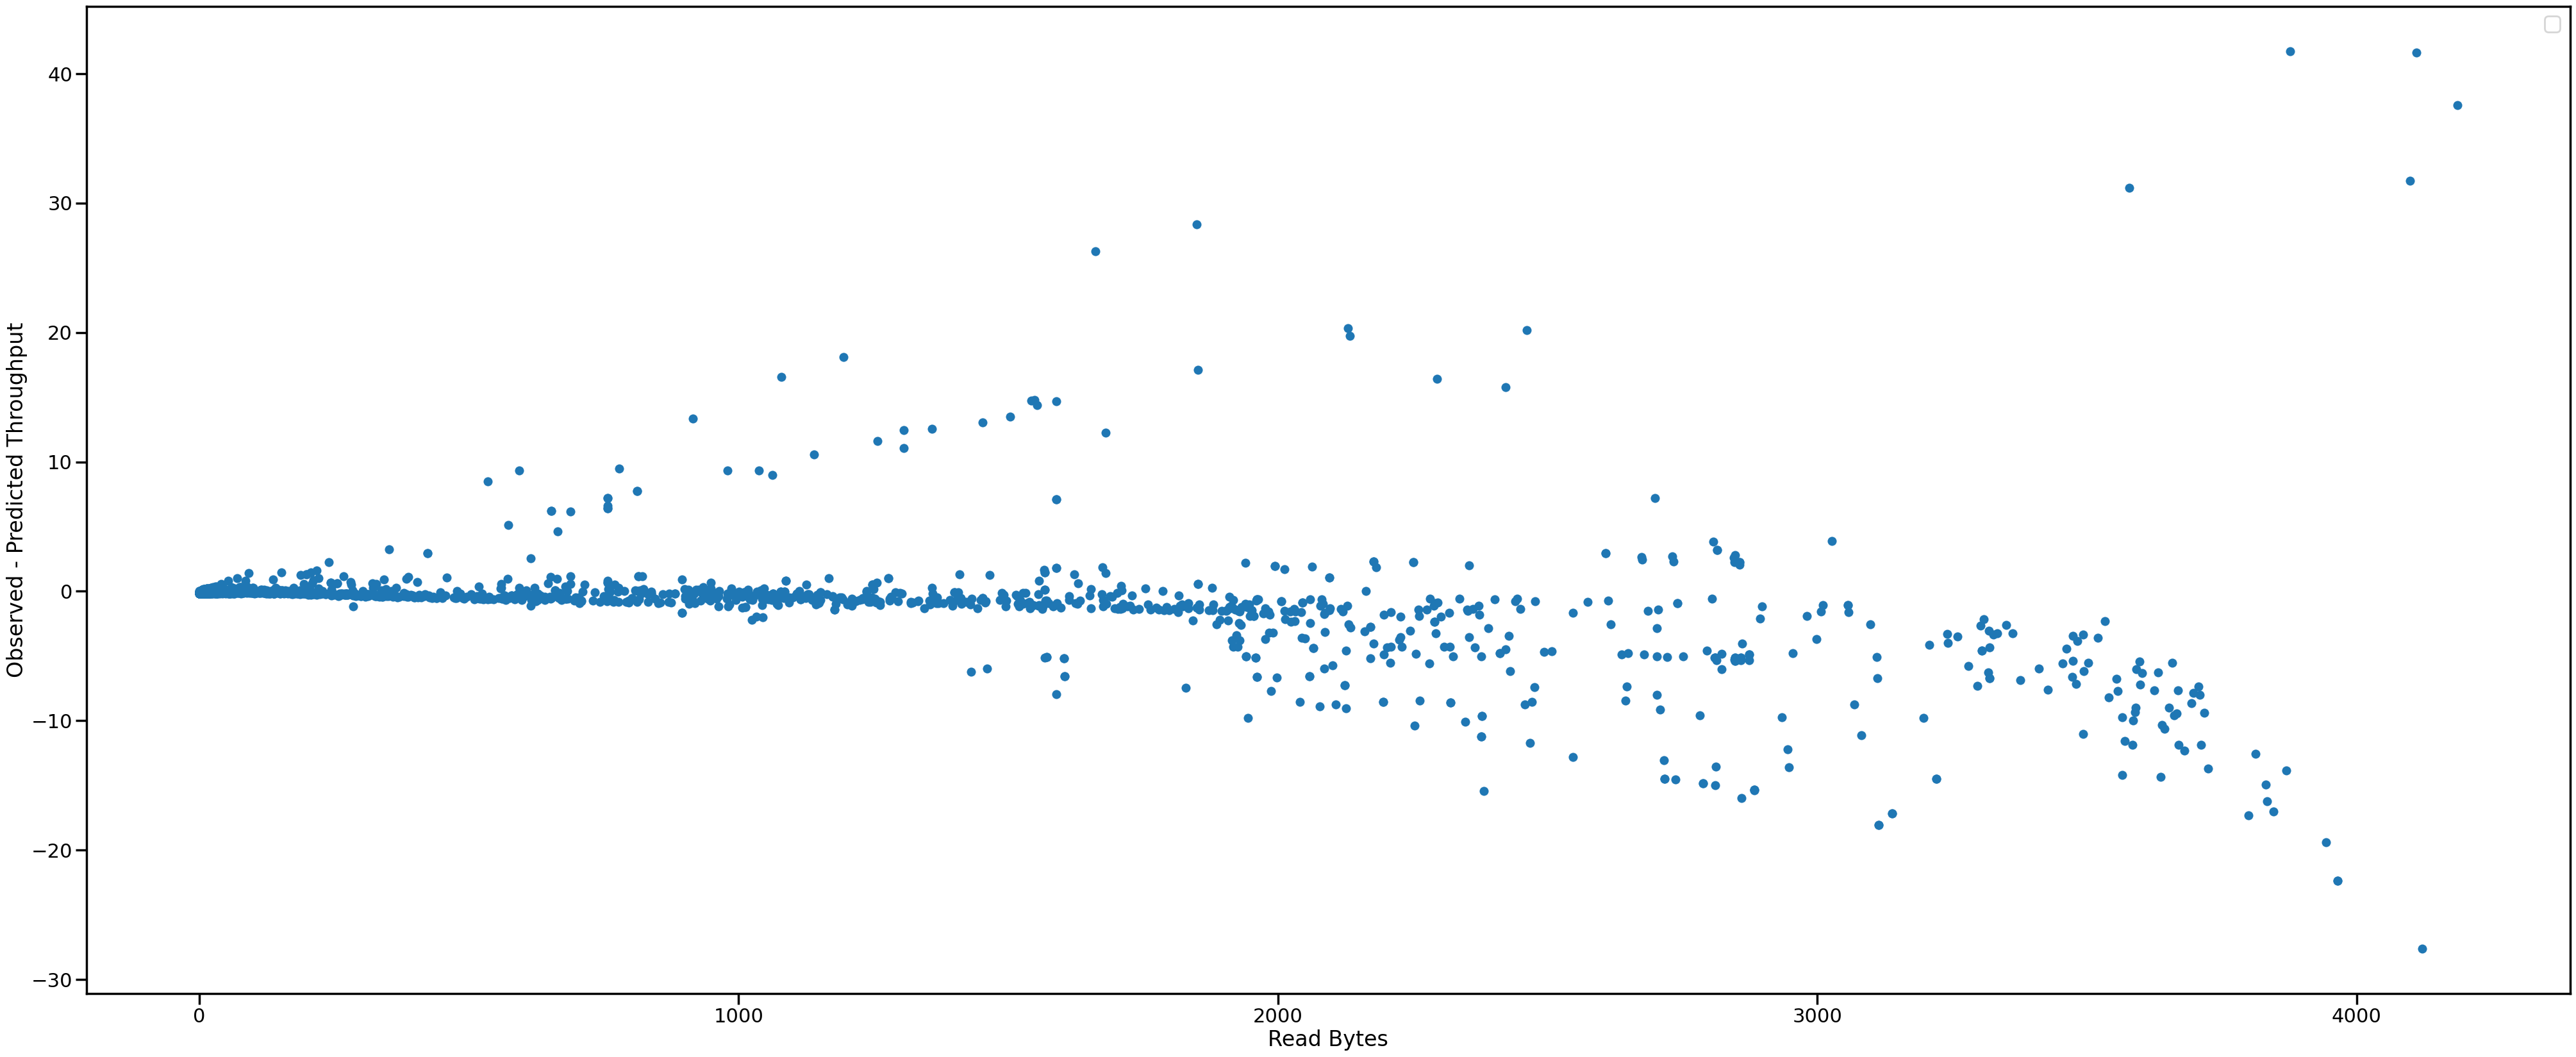

In [107]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X_test_latest['read_bytes'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred[:,0]/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(X_test_latest['read_bytes'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me, 1)
#plt.plot((y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me), m*(y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me)+b)
plt.legend()
plt.xlabel('Read Bytes')
plt.ylabel('Observed - Predicted Throughput')
#plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


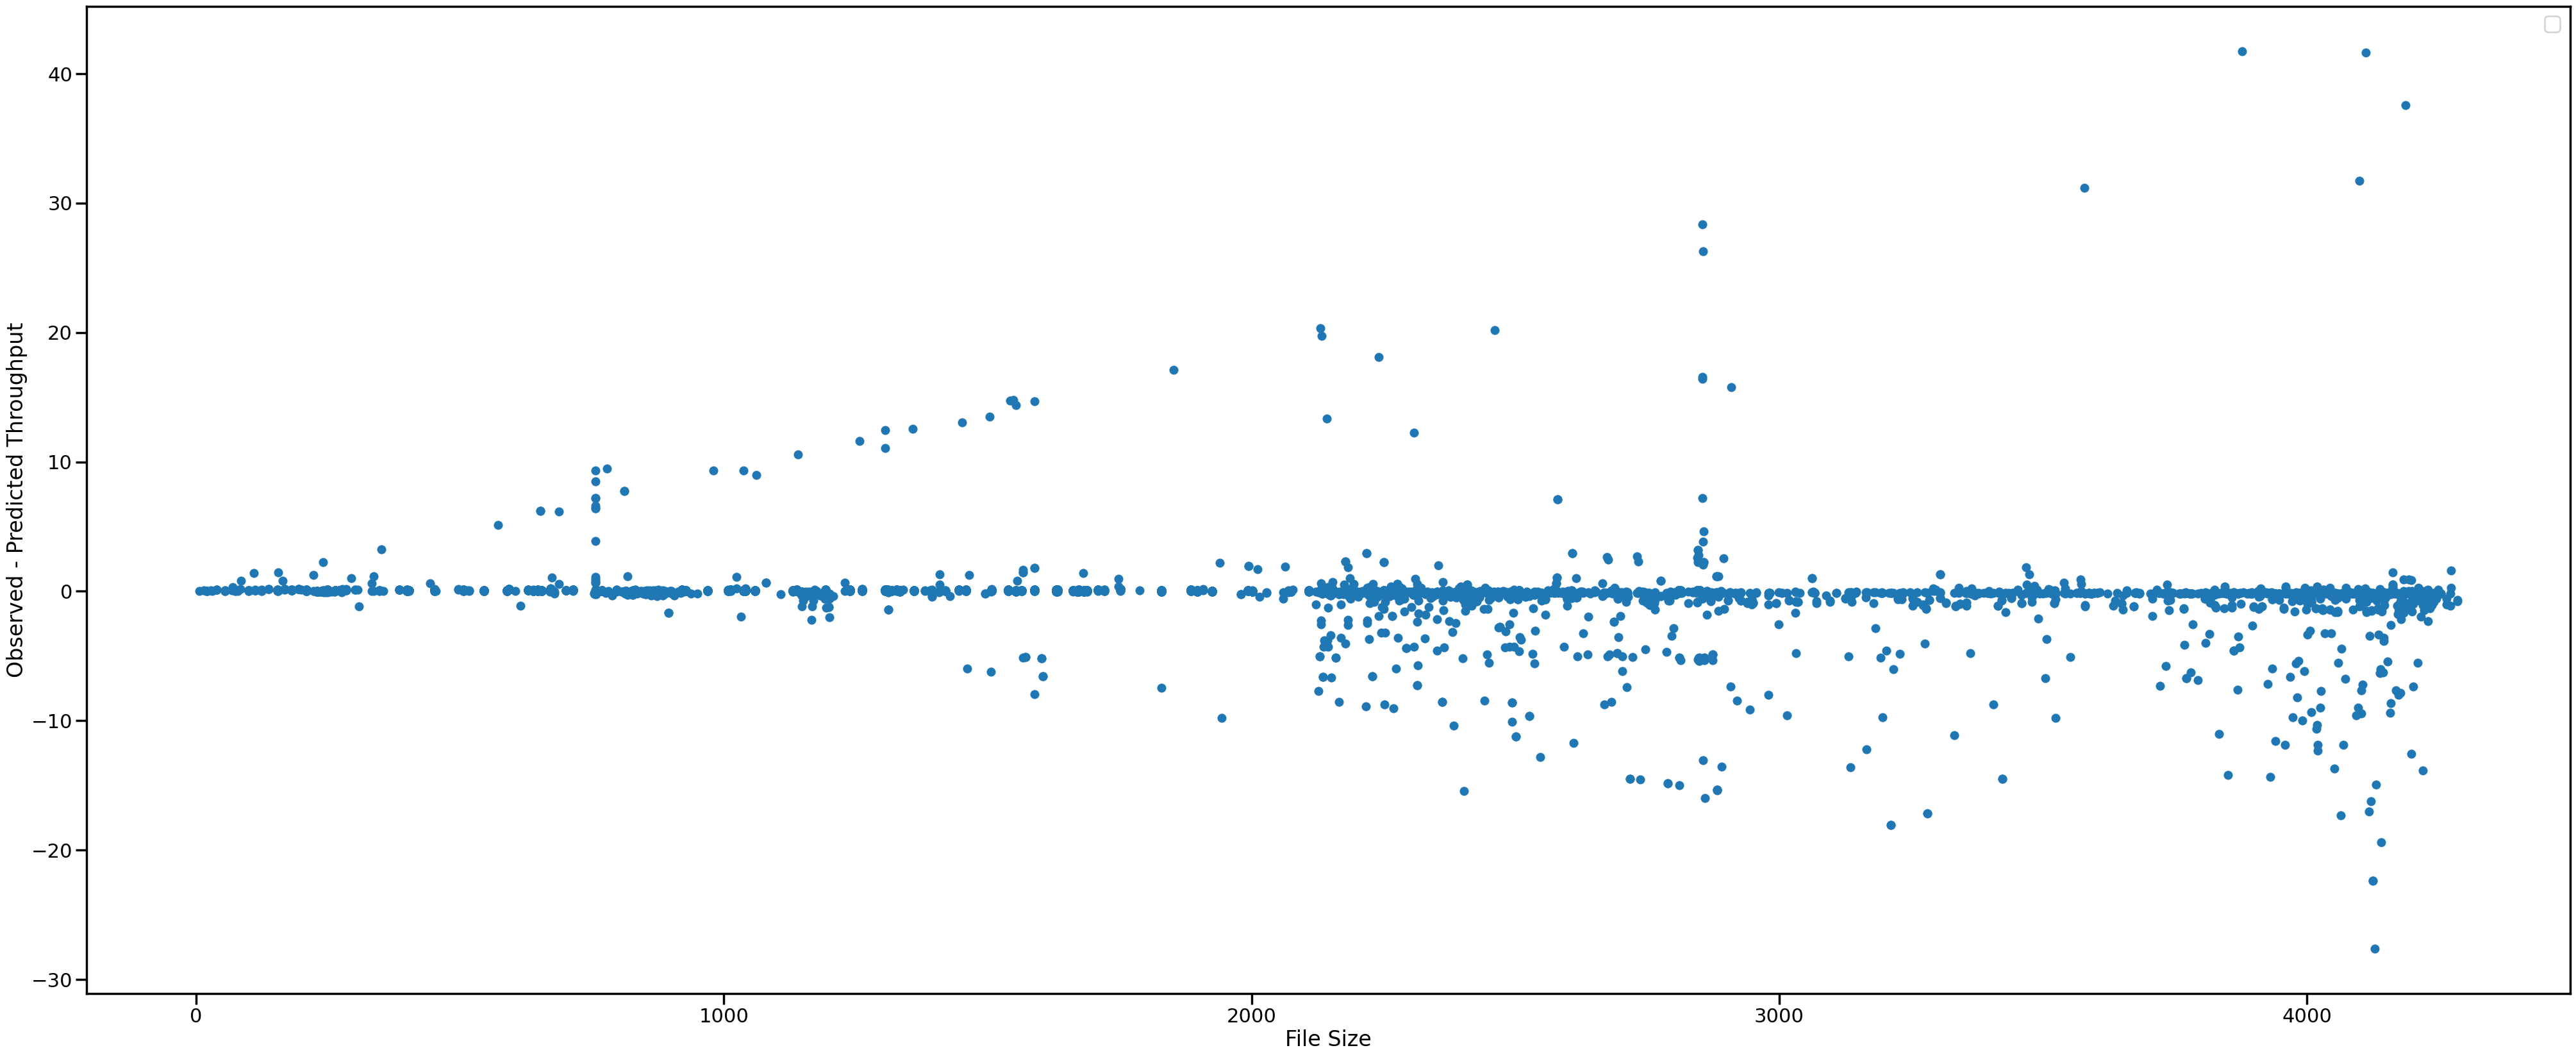

In [108]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X_test_latest['file_size'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred[:,0]/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(X_test_latest['read_bytes'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me, 1)
#plt.plot((y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me), m*(y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me)+b)
plt.legend()
plt.xlabel('File Size')
plt.ylabel('Observed - Predicted Throughput')
#plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


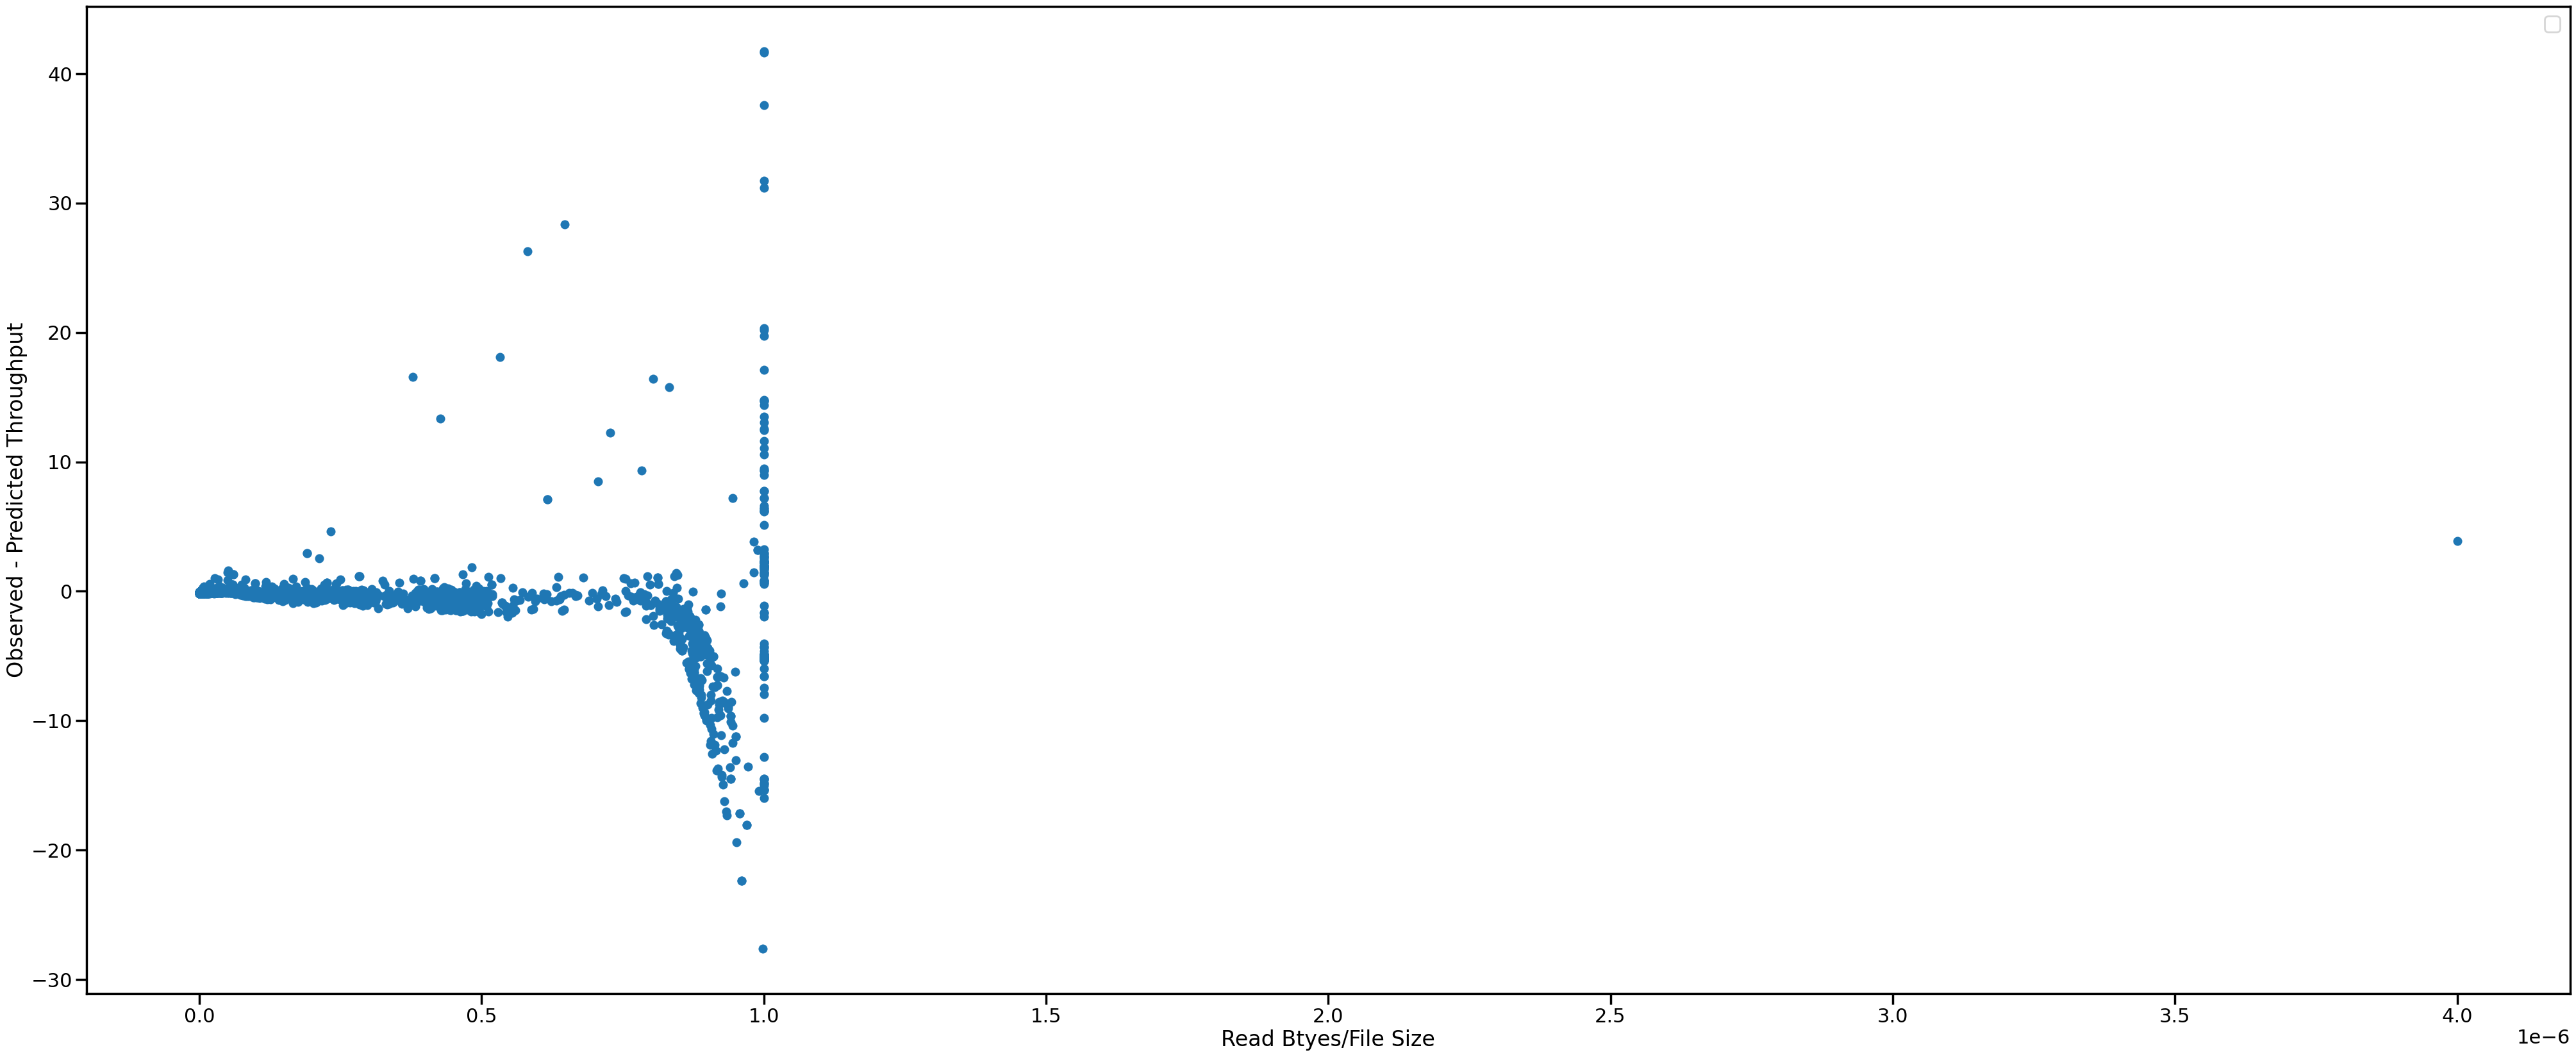

In [109]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(X_test_latest['read_btyes/file_size'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred[:,0]/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(X_test_latest['read_bytes'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me, 1)
#plt.plot((y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me), m*(y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me)+b)
plt.legend()
plt.xlabel('Read Btyes/File Size')
plt.ylabel('Observed - Predicted Throughput')
#plt.yscale("log")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


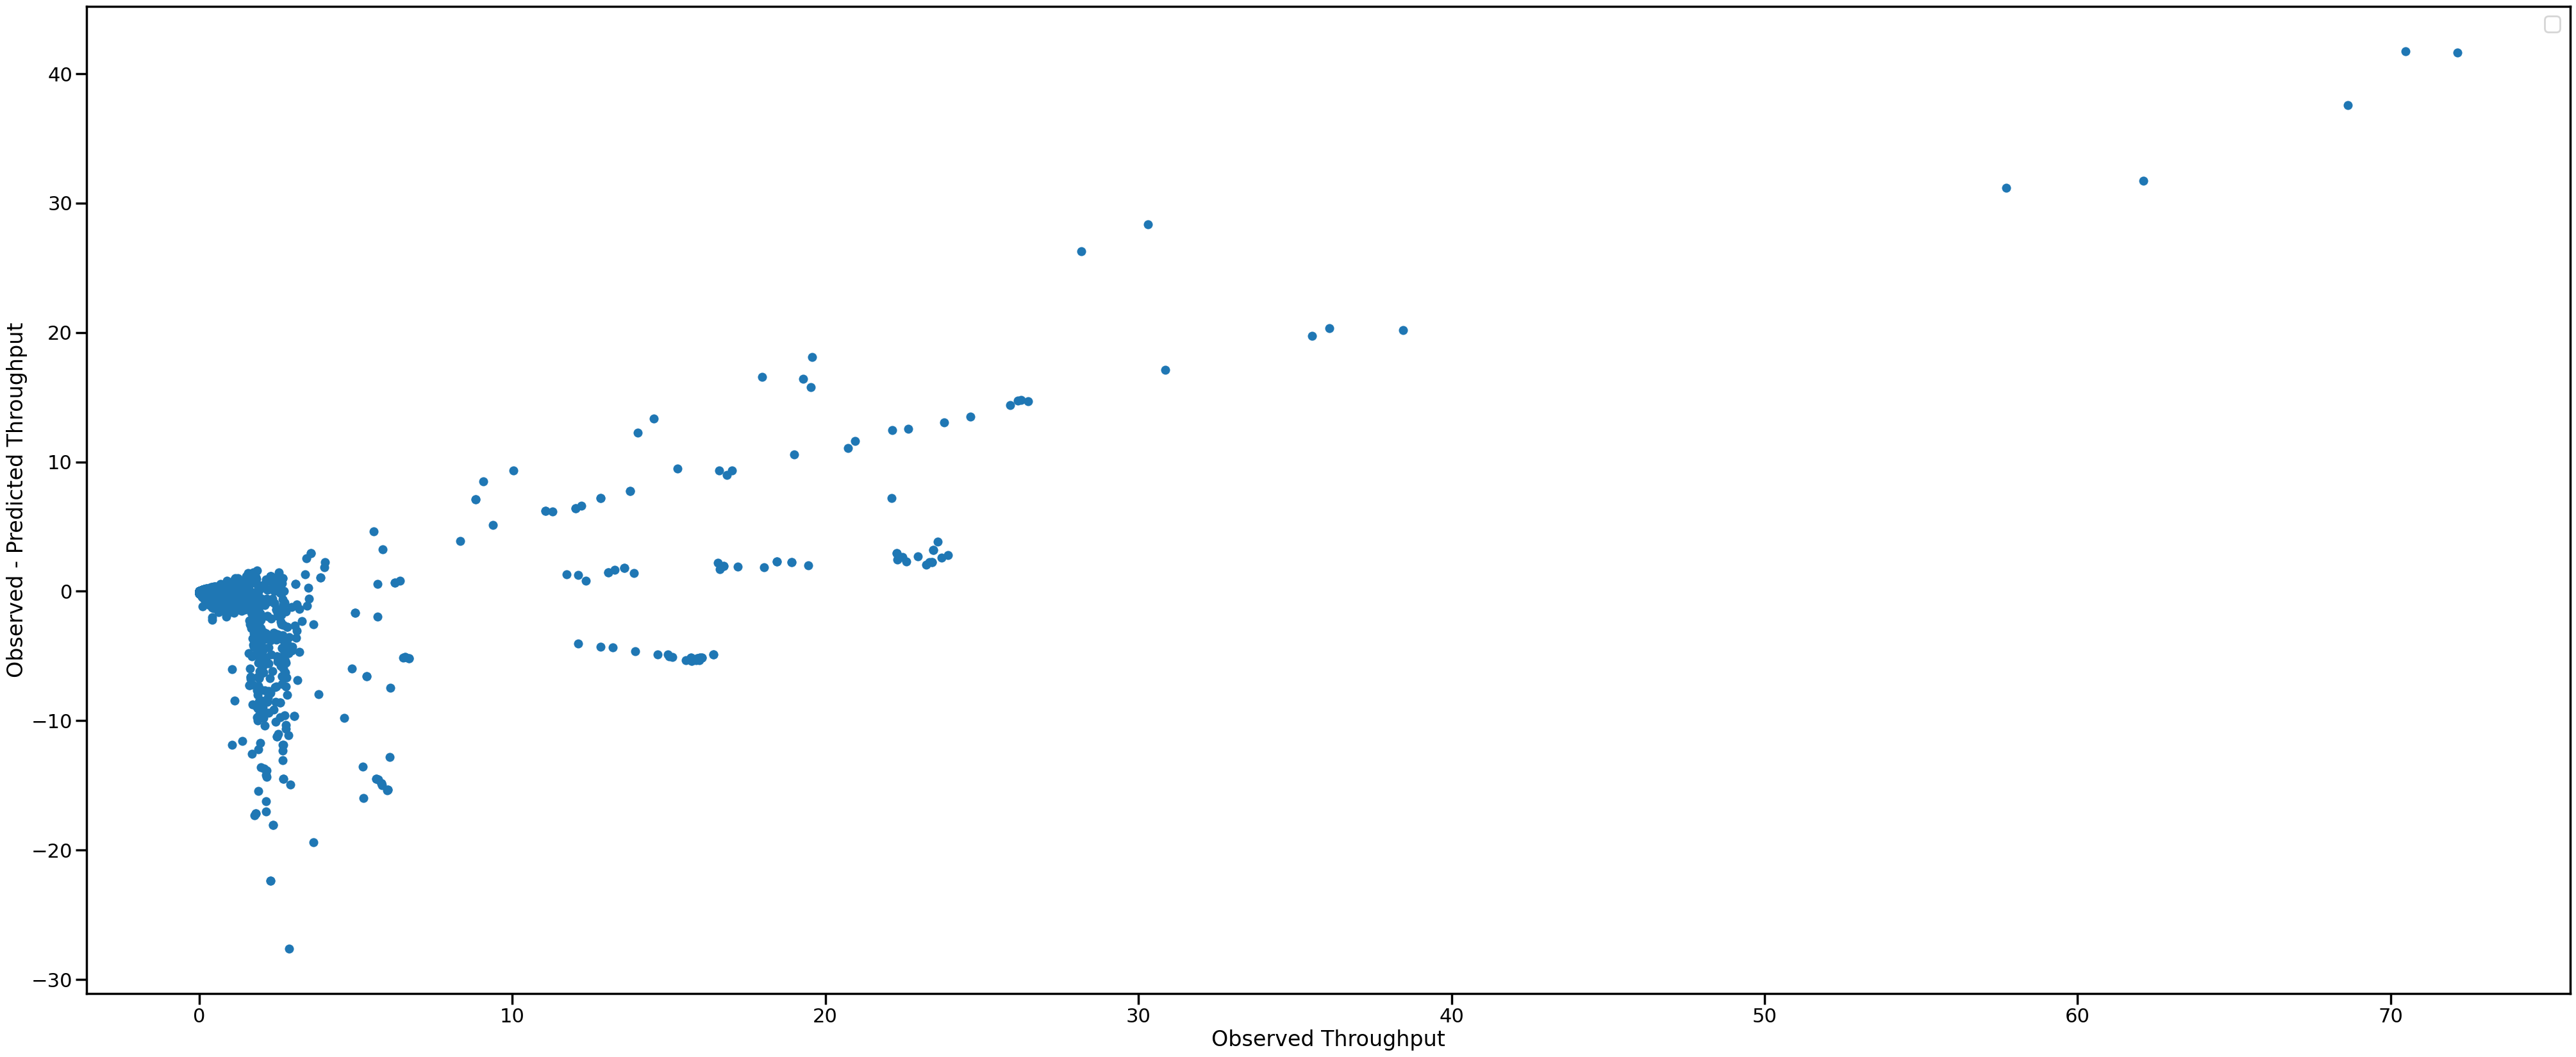

In [110]:
sns.set_context('poster')
scale_me = 1000000
plt.figure(figsize=(50,20))
#plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
#plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.scatter(y_test_latest.to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred[:,0]/scale_me, s=100, linewidths = 0.1)
#plt.title('Model predictions on Unseen data')
#m, b = np.polyfit(X_test_latest['read_bytes'].to_numpy()/scale_me, y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me, 1)
#plt.plot((y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me), m*(y_test_latest.to_numpy()/scale_me - throughput_test_latest_pred/scale_me)+b)
plt.legend()
plt.xlabel('Observed Throughput')
plt.ylabel('Observed - Predicted Throughput')
#plt.yscale("log")
plt.show()

##### 1 Get a linear fit of the prediction -> Take the average predicted Throughput
##### 2 Do this for all US T2 sites and check difference
##### 3 Can I fit the scatter plots and take some benefit from the fits?
##### 4 Is there any other way to improve the ML model?
##### 5 What's the accuracy?
##### 6 Check the sample with rb/fs > some_cut and see if the result makes more sense

## From https://keras.io/examples/timeseries/timeseries_anomaly_detection/

### Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct the input data.

* Find MAE loss on training samples.
* Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
* If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

869/869 [==============================] - 2s 2ms/step


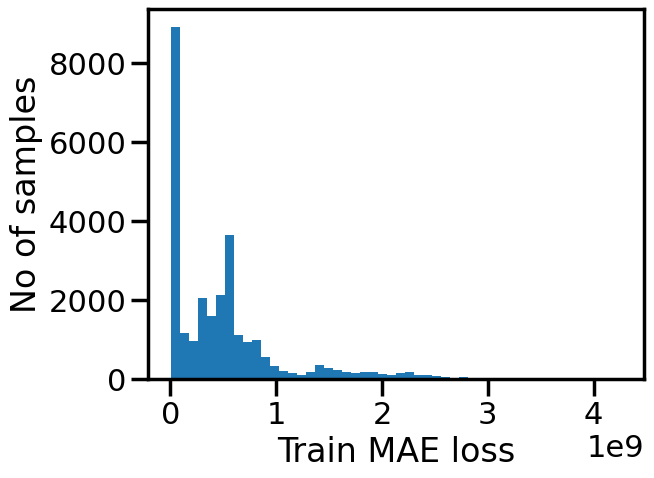

Reconstruction error threshold:  4264395111.9716024


In [86]:
# Get train MAE loss.
X_pred = model.predict(X)
train_mae_loss = np.mean(np.abs(X_pred - X), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction
Just for fun, let's see how our model has recontructed the first sample.



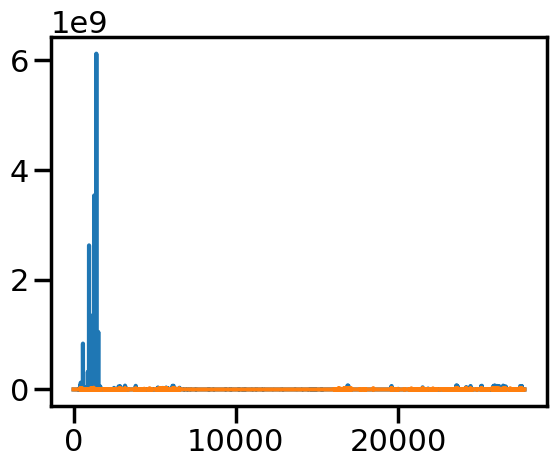

In [88]:
# Checking how the first sequence is learnt
plt.plot(y.to_numpy()) #X[0])
plt.plot(throughput_full_pred) # X_pred[0])
plt.show()

### Prepare test data

In [89]:
#df_test_value = (df_daily_jumpsup - training_mean) / training_std
#fig, ax = plt.subplots()
#df_test_value.plot(legend=False, ax=ax)
#plt.show()

## Create sequences from test values.
#x_test = create_sequences(df_test_value.values)
#print("Test input shape: ", x_test.shape)

## Get test MAE loss.
#x_test_pred = model.predict(x_test)
x_test_pred = model.predict(X_test) #,batch_size=256, verbose=1)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

121/121 [==============================] - 0s 2ms/step


AttributeError: 'Series' object has no attribute 'reshape'

## Evaluate the model and Predict on a Test Sample

In [32]:
def make_test_sample ():
    import glob
    import os
    from chep2023XRDMonitoringDataDeepLearning_list import chep2023XRDMonitoringDataDeepLearning_list
    #print ( chep2023XRDMonitoringDataDeepLearning_list)

    all_files = glob.glob(path + '/*.csv.zip')

    li = []

    for filename in all_files:
        if filename in chep2023XRDMonitoringDataDeepLearning_list : continue # Exclude files in the training/validation
        print ( "Doing " + filename)    
        df = pd.read_csv( filename, low_memory=False, compression='zip')
        df = preprocess_data(df, site=site, operation=operation, throughput=throughput, 
                                 user_protocol=user_protocol, client_domain=client_domain,
                                 use_cache=False).dropna()
        li.append(df)
        print ( "Done " + filename)    

    frame = pd.concat(li, axis=0, ignore_index=True)
    frame.to_csv('chep2023XRDMonitoringDataDeepLearning_test.csv', index=False)    #print ( li )
    print ( "Created chep2023XRDMonitoringDataDeepLearning_test.csv")    
    with open("chep2023XRDMonitoringDataDeepLearning_test_list.py", "w") as inputs :
        # Writing data to a file
        inputs.write("chep2023XRDMonitoringDataDeepLearning_test_list = [\n")
        len(all_files)
        for i, f in enumerate(all_files) :
          if i == (len(all_files) - 1) :
            inputs.write('               "'+f+'"]\n')
          else :
            inputs.write('               "'+f+'",\n')
    print("Created chep2023XRDMonitoringDataDeepLearning_test_list.py")

    return li

In [36]:
li = make_test_sample()

Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030906.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030906.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030901.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030901.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030812.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030812.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023031006.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023031006.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023031000.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023031000.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030806.csv.zip
Done

[                       file_size  read_bytes   ipv6  operation_time  \
 YmdHMS                                                                
 2023-03-09 04:44:18   4111527882  4111527882   True             900   
 2023-03-09 04:50:18   4115370246  4115370246   True             960   
 2023-03-09 05:00:56   3941708717  3941708717  False              60   
 2023-03-09 05:01:03   6821575580   328826207   True            1980   
 2023-03-09 05:02:03  10866590442   538971342   True            2879   
 2023-03-09 05:03:02  11434983772    10018476   True            1380   
 2023-03-09 05:12:06    227896817    26304348   True            2400   
 2023-03-09 05:17:05   4004244081  4004244081   True              60   
 2023-03-09 05:18:02   4069224329  4069224329   True              60   
 2023-03-09 05:19:57   3987929127  3987929127  False              61   
 2023-03-09 05:38:05    242071856    39912805   True            1801   
 2023-03-09 06:20:02    230147020    15187275   True            

In [37]:
csvFileToTest = 'chep2023XRDMonitoringDataDeepLearning_test.csv'
preprocessed_data_X_test_full = pd.read_csv( csvFileToTest, low_memory=False) # , compression='zip')

In [39]:
# Obtain target and predictors
X_test_full, y_test = select_features_and_target ( preprocessed_data_X_test_full, target = 'throughput' )

X_test_full = train_encoders_fit_transform(X_test_full, use_cache=False)

X_test = X_test_full[features].copy()

#X_test_full, _ = select_features_and_target ( preprocessed_data_X_test_full, target = 'throughput' )
#X_test_full = train_encoders_fit_transform(X_test_full, use_cache=False)
#X_test = X_test_full[features].copy()

#from sklearn.model_selection import train_test_split

# Break off validation set from training data
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
#                                                      random_state=0)

### Evaludate the model

In [80]:
mae = model.evaluate(X_test, y_test, verbose=0)

In [84]:
print (mae)
#from math import sqrt
#print('MSE: %.3f, RMSE: %.3f' % (mae, sqrt(mae)))


[643509.25, 0.0]


In [90]:
# Get train MAE loss.
mae = np.mean(np.abs(throughput_test_pred - y_test.to_numpy()), axis=1)

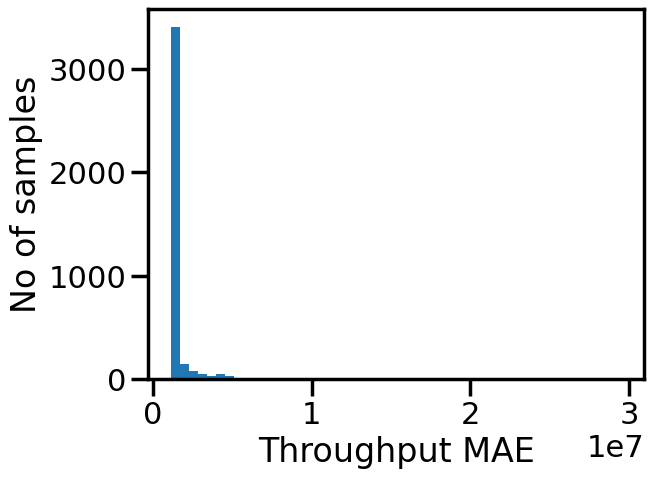

In [91]:
plt.hist(mae, bins=50)
plt.xlabel("Throughput MAE")
plt.ylabel("No of samples")
plt.show()


In [94]:
# Get reconstruction loss threshold.
mae_max = np.max(mae)
print("Max MAE with the Test Target ", mae_max)

Max MAE with the Test Target  29530649.654228147


16/16 [==============================] - 0s 3ms/step


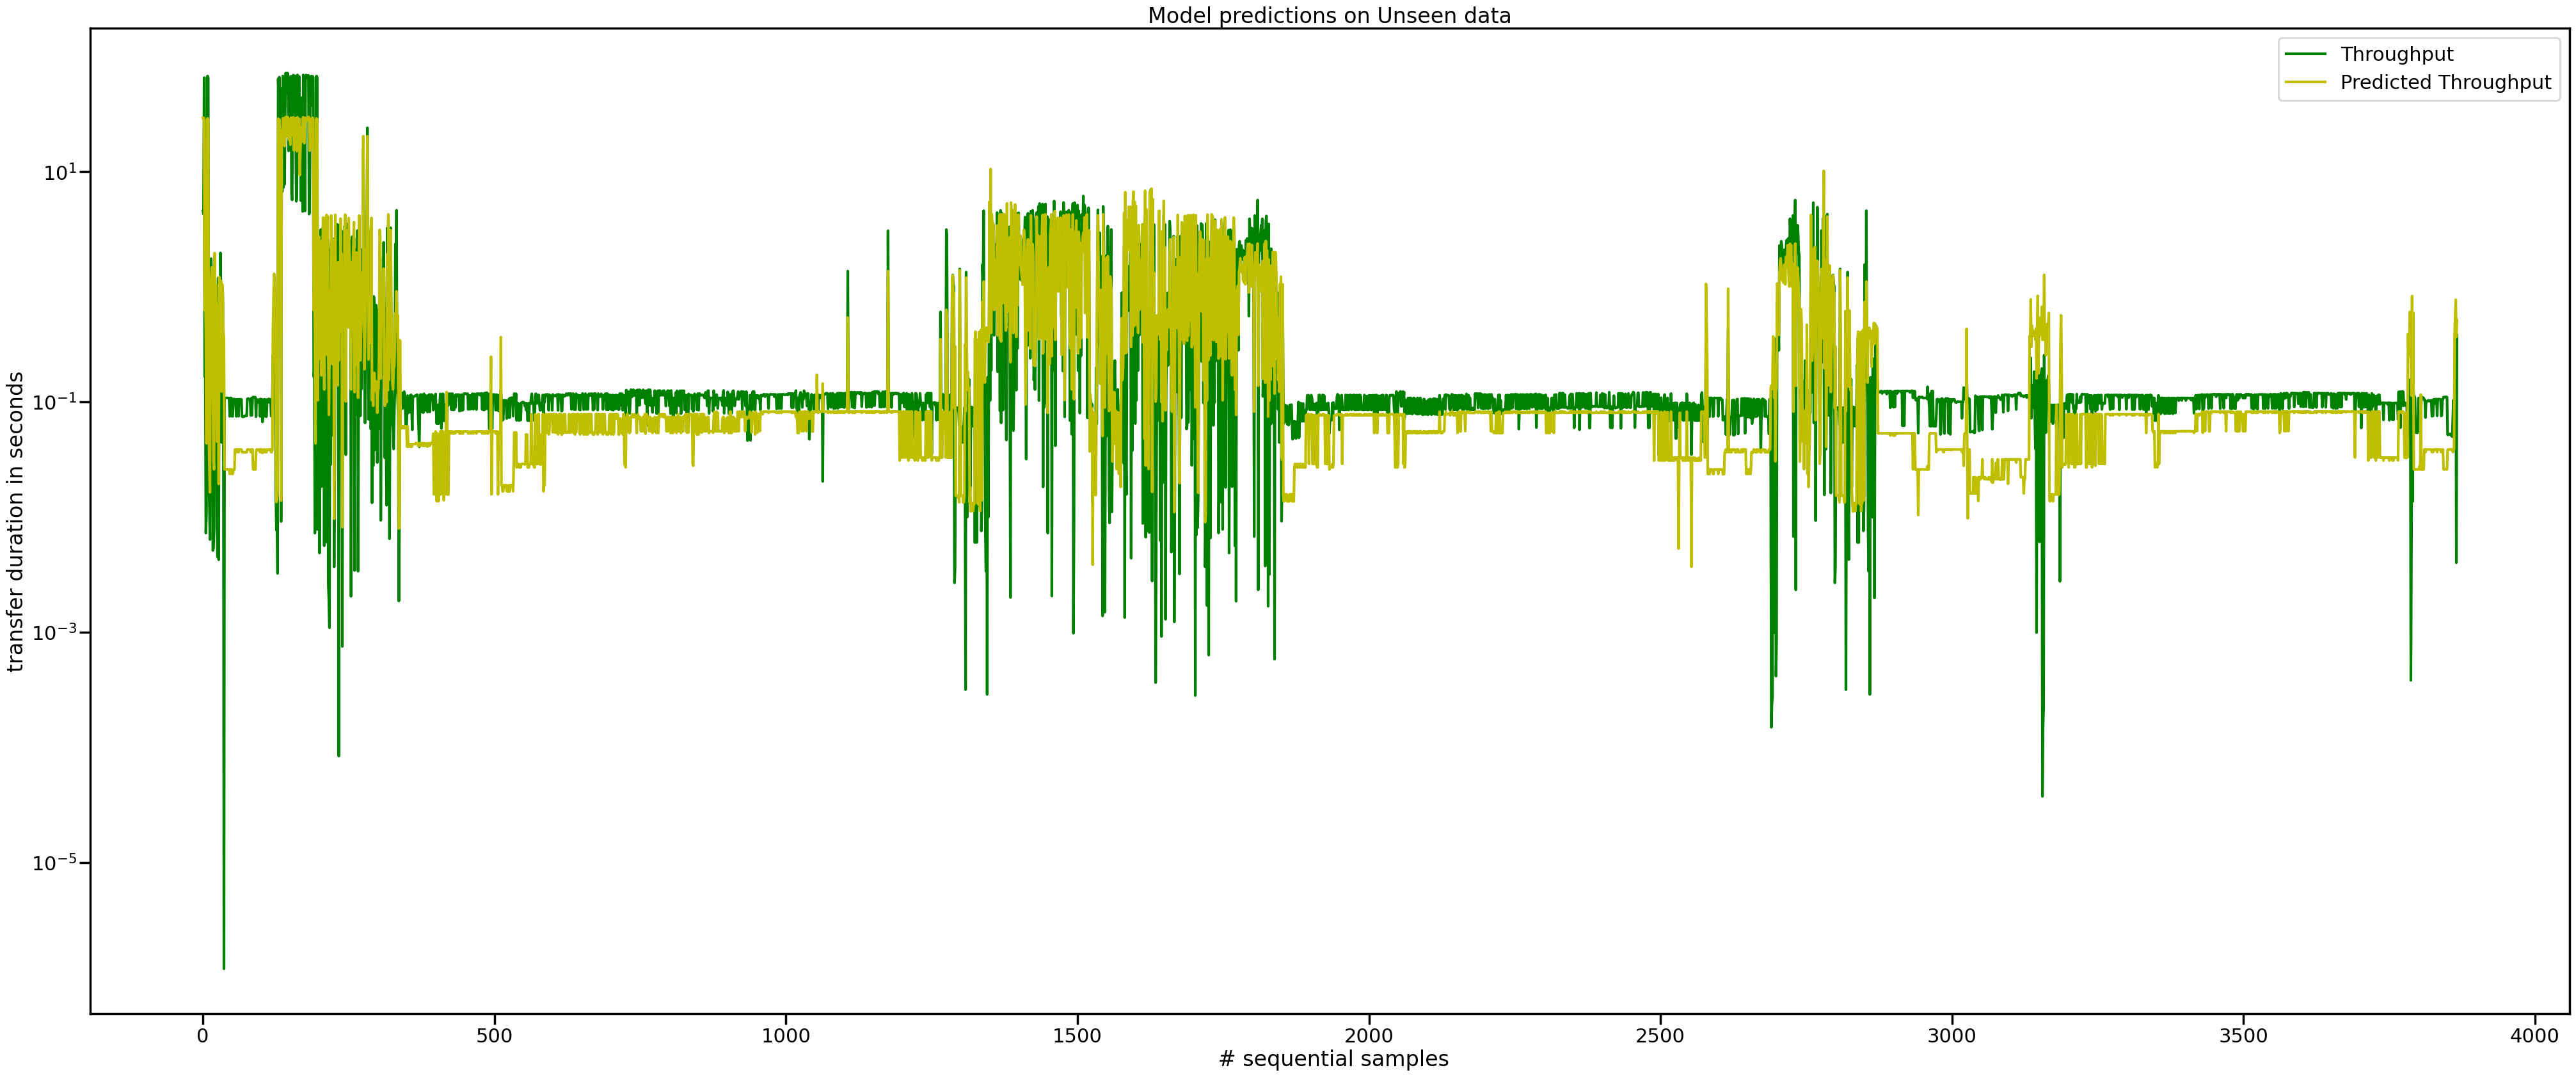

In [70]:
throughput_test_pred = model.predict(X_test,batch_size=256, verbose=1)
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y_test.to_numpy()/1000000, 'g', label='Throughput')
plt.plot(throughput_test_pred/1000000, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

## Statistical Analysis
### 1 Separating Observation Distribution from Predicted Distribution

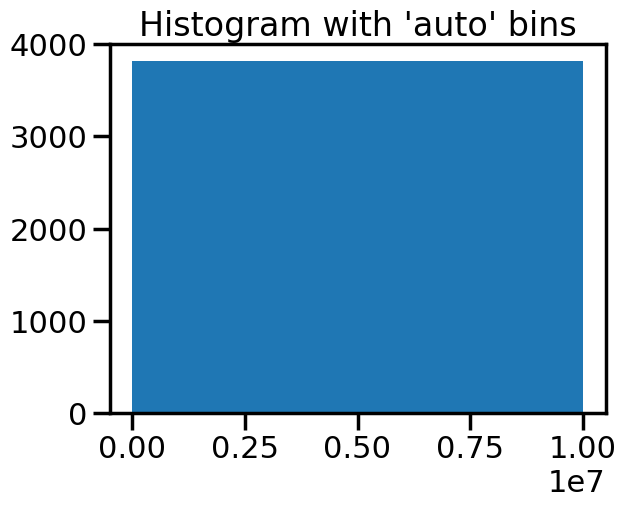

In [50]:
import matplotlib.pyplot as plt
#rng = np.random.RandomState(10)  # deterministic random data
#a = np.hstack((rng.normal(size=1000),
#                rng.normal(loc=5, scale=2, size=1000)))
#_ = plt.hist(y_test.to_numpy(), bins='auto')  # arguments are passed to np.histogram
n, bins, patches = plt.hist(y_test.to_numpy(), bins = [-10, 10000000])
plt.title("Histogram with 'auto' bins")
#Text(0.5, 1.0, "Histogram with 'auto' bins")
plt.show()

In [51]:
print(n)

[3811.]


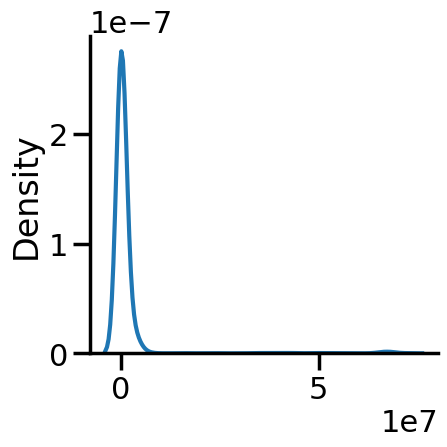

In [46]:
import seaborn as sns
import numpy as np
#create histogram to visualize distribution of values
sns.displot(y_test.to_numpy(), kind='kde')

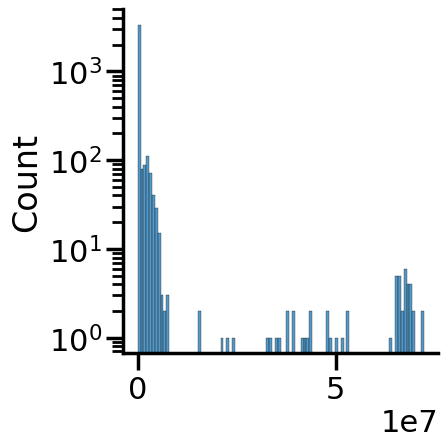

In [60]:
sns.displot(y_test.to_numpy(), bins=100, log=True)

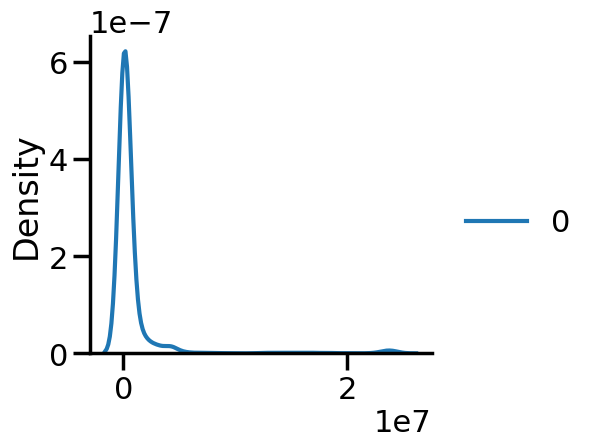

In [58]:
sns.displot(throughput_test_pred, kind='kde')

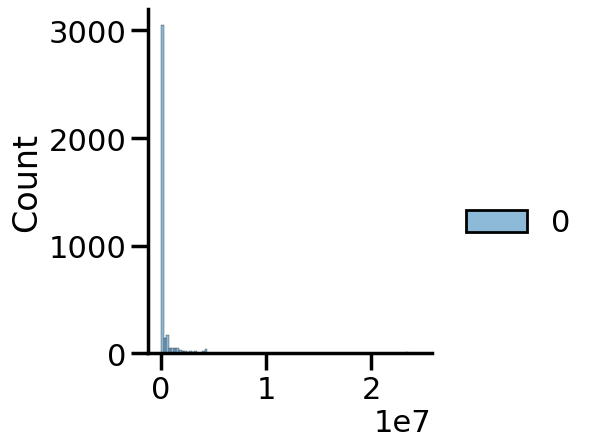

In [62]:
sns.displot(throughput_test_pred, bins=100)

Minimum validation loss: 1888637.75


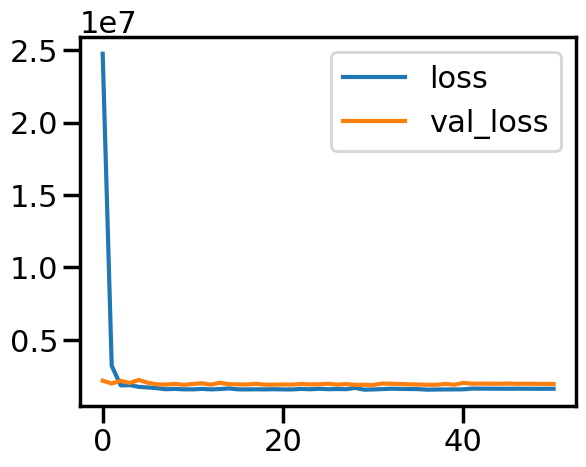

In [69]:
if False:
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]

    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.callbacks import EarlyStopping

    model = keras.Sequential([
        # the hidden ReLU layers
        layers.Dense(units=512, activation='relu', input_shape=input_shape),
        layers.Dense(units=512, activation='relu'),
        layers.Dense(units=512, activation='relu'),
        # the linear output layer 
        layers.Dense(units=1),
    ])

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=METRICS
    )

    early_stopping = EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=20, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=256,
        epochs=500,
        callbacks=[early_stopping], # put your callbacks in a list
        verbose=0,  # turn off training log
    )

    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot();
    print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [66]:
#sns.jointplot(throughput_test_pred='hp', y_test.to_numpy()=='mpg', data=auto)
#plt.show()

In [23]:
csvFile_full = '/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030206.csv.zip'
csvFile_test_full = '/cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030212.csv.zip'

In [24]:
# Read the data
#data_X_full = pd.read_csv( csvFile_full, low_memory=False, compression='zip', index_col='metadata.timestamp')
#data_X_test_full = pd.read_csv( csvFile_test_full, low_memory=False, compression='zip', index_col='metadata.timestamp')
data_X_full = pd.read_csv( csvFile_full, low_memory=False, compression='zip')

In [25]:
data_X_test_full = pd.read_csv( csvFile_test_full, low_memory=False, compression='zip')

In [26]:
preprocessed_data_X_full = preprocess_data(data_X_full, site=site, operation=operation, throughput=throughput, 
                             user_protocol=user_protocol, client_domain=client_domain,
                             use_cache=False).dropna()
preprocessed_data_X_test_full = preprocess_data(data_X_test_full, site=site, operation=operation, throughput=throughput, 
                             user_protocol=user_protocol, client_domain=client_domain,
                             use_cache=False).dropna()

In [27]:
data_X_full.shape

(4147972, 55)

In [37]:
preprocessed_data_X_full.shape

(104, 6)

In [36]:
client_domain='wisc.edu' # 'purdue.edu' 'ALL'
preprocessed_data_X_full = preprocess_data(data_X_full, site=site, operation=operation, throughput=throughput, 
                             user_protocol=user_protocol, client_domain=client_domain,
                             use_cache=False).dropna()
preprocessed_data_X_full.shape

(104, 6)

##### Read all files, preprocess them, and put them in a list

In [46]:
import glob
import os

all_files = glob.glob(path + '/*.csv.zip')

li = []

for filename in all_files:
    print ( "Doing " + filename)    
    df = pd.read_csv( filename, low_memory=False, compression='zip')
    df = preprocess_data(df, site=site, operation=operation, throughput=throughput, 
                             user_protocol=user_protocol, client_domain=client_domain,
                             use_cache=False).dropna()
    li.append(df)
    print ( "Done " + filename)    

print ( li )

Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030618.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030618.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030500.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030500.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030212.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030212.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030600.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030600.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030306.csv.zip
Done /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030306.csv.zip
Doing /cmsuf/data/store/user/bockjoo/CHEP2023/XRDCollectorData/colldata_2023030706.csv.zip
Done

In [47]:
frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
frame.to_csv('chep2023XRDMonitoringDataDeepLearning.csv', index=False)

In [ ]:
frame.shape

In [60]:
with open("chep2023XRDMonitoringDataDeepLearning_list.py", "w") as inputs :
    # Writing data to a file
    inputs.write("chep2023XRDMonitoringDataDeepLearning_list = [\n")
    len(all_files)
    for i, f in enumerate(all_files) :
      if i == (len(all_files) - 1) :
        inputs.write('               "'+f+'"]\n')
      else :
        inputs.write('               "'+f+'",\n')
    

109/109 [==============================] - 1s 4ms/step


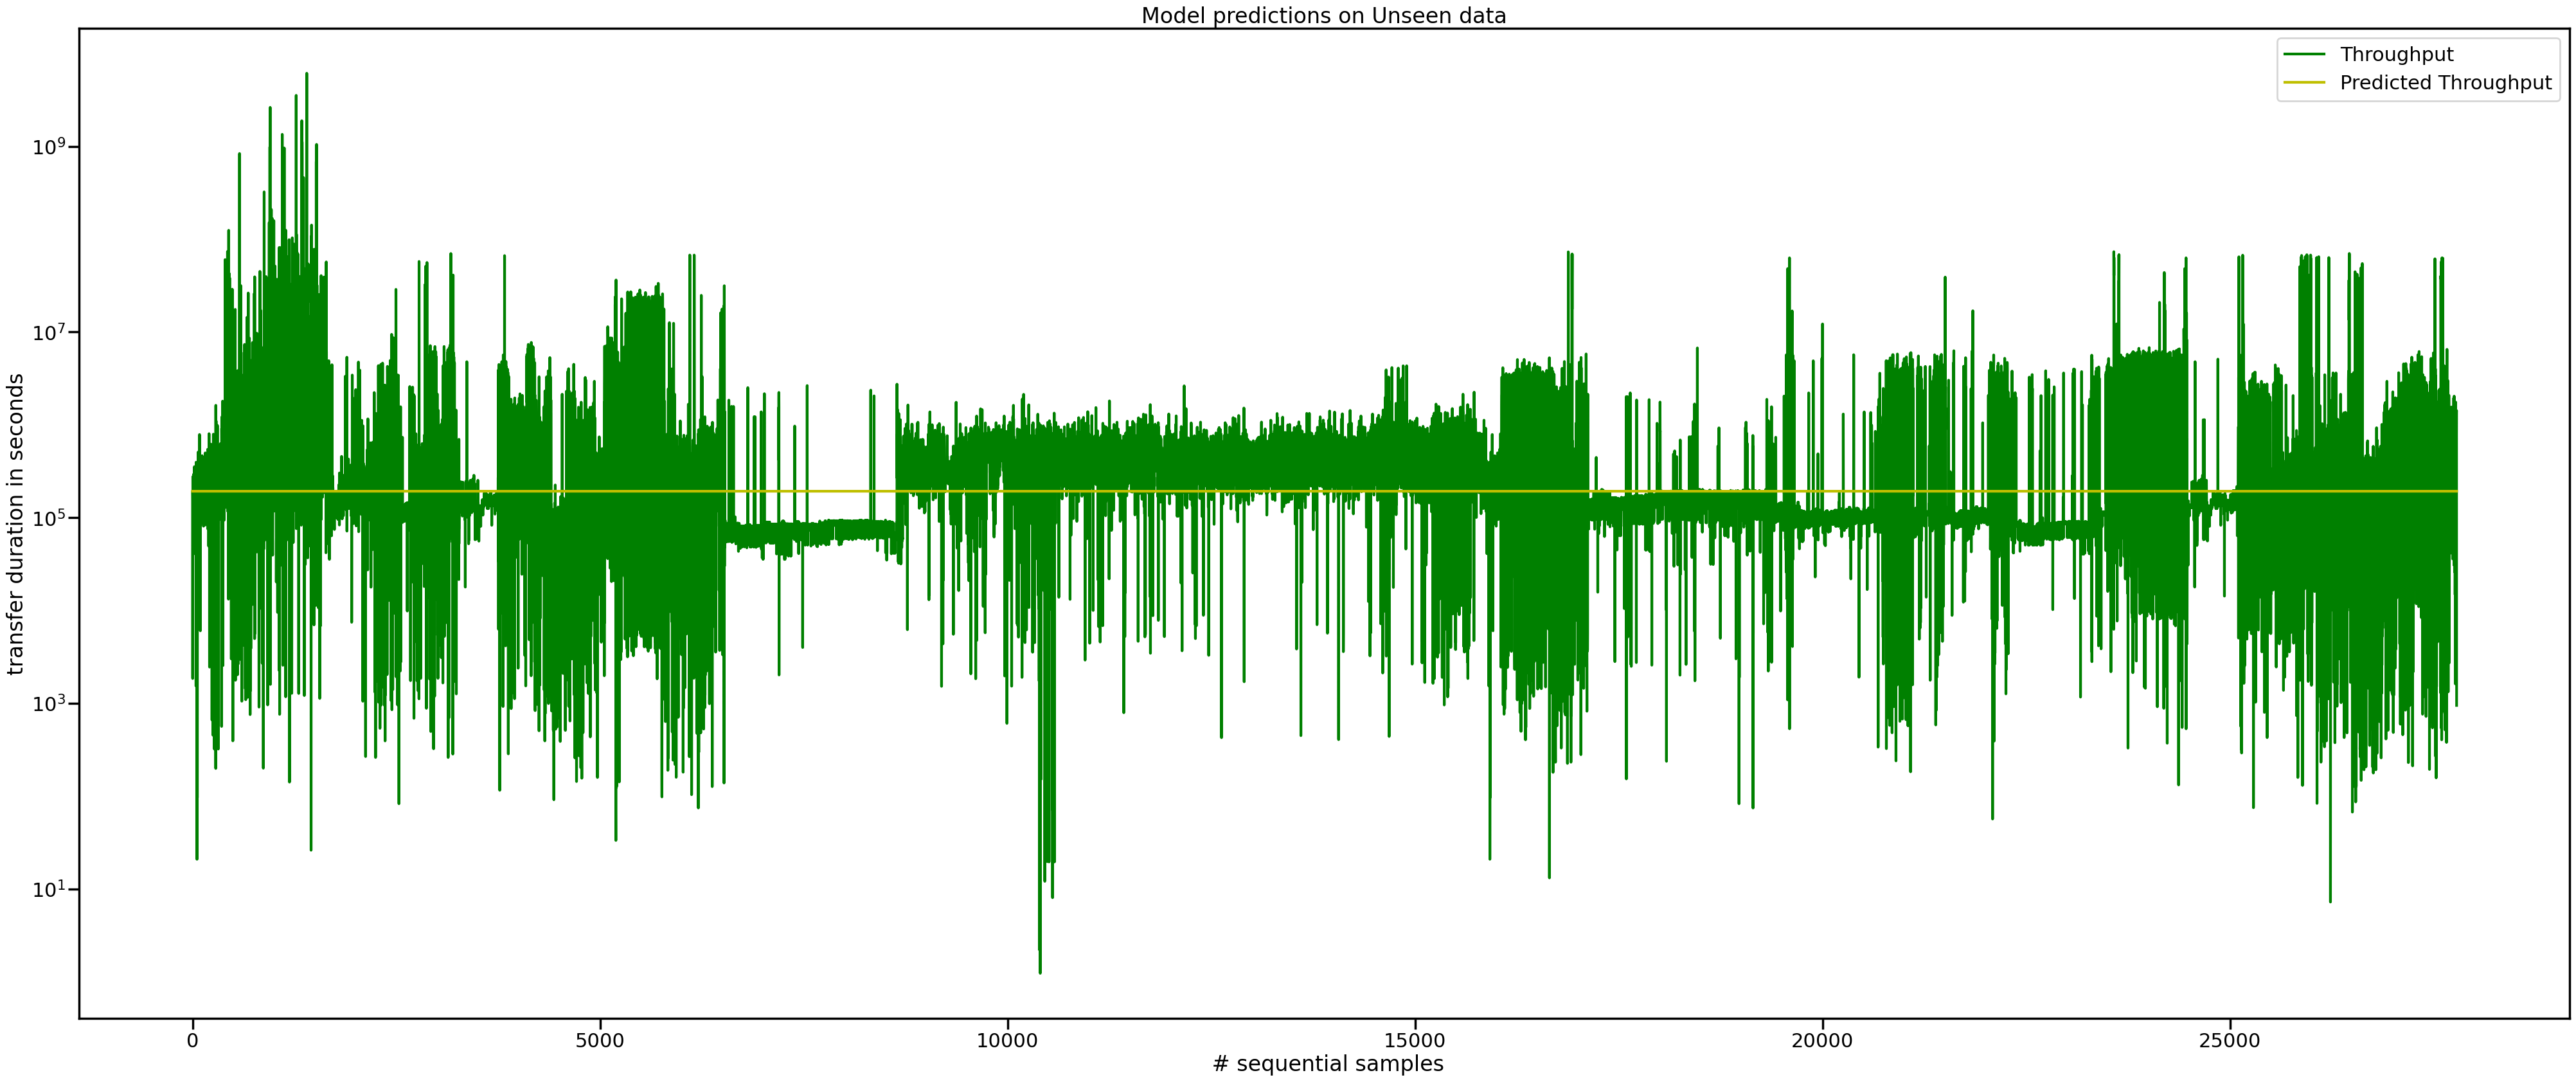

In [68]:

data_full = X_full[features].copy()
throughput_full_pred = model.predict(data_full,batch_size=256, verbose=1)
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y.to_numpy(), 'g', label='Throughput')
plt.plot(throughput_full_pred, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

In [69]:
throughput_full_pred

array([[192715.81],
       [192715.81],
       [192715.81],
       ...,
       [192715.81],
       [192715.81],
       [192715.81]], dtype=float32)

In [77]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1),
])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              6144      
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                

##### Check the Closeness

In [79]:
model.compile(
    optimizer='adam',
    loss='mae',
)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    #callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

##### Plot Loss

Minimum validation loss: 1908546.375


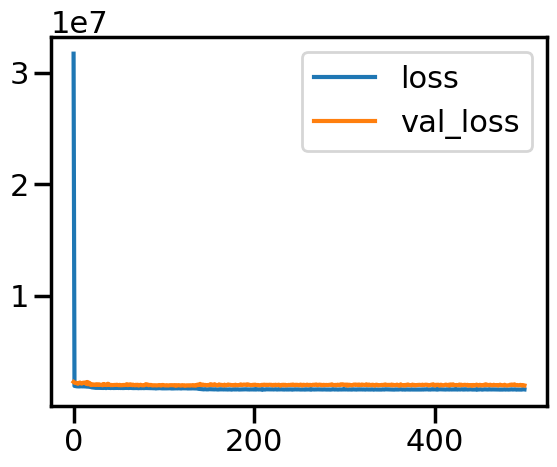

In [80]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##### Is the model overfitting?
I don't think so

##### Do we need more data?

In [89]:
# Get Weights
# model.get_weights()
# Train Size = 0.8 , 80%

[]

##### Plot Accuracy

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['acc', 'val_acc']].plot();
#print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

KeyError: 'acc'

In [85]:
model.evaluate(data_full, y, verbose=2)[0]

869/869 - 2s - loss: 1660318.5000 - 2s/epoch - 3ms/step


TypeError: 'float' object is not subscriptable

# Where do we go from here?

## Linear Model
##### 1) Input shape #

How well can we predict a wine's perceived quality from the physiochemical measurements?  

The target is `'quality'`, and the remaining columns are the features.  How would you set the `input_shape` parameter for a Keras model on this task?

In [34]:
input_shape = [X_train.shape[1]]

##### 2) Define a linear model

Now define a linear model appropriate for this task. Pay attention to how many inputs and outputs the model should have.

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE
model = model = keras.Sequential([
    layers.Dense(units=1, input_shape=input_shape)
])

2023-03-07 12:30:55.102988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64::/home/bockjoo/services/external/webisoget-2.8.4/lib:/usr/lib/x86_64-linux-gnu
2023-03-07 12:30:55.103043: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 12:30:55.103106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cms.ufhpc): /proc/driver/nvidia/version does not exist


##### 3) Look at the weights

Internally, Keras represents the weights of a neural network with **tensors**. Tensors are basically TensorFlow's version of a Numpy array with a few differences that make them better suited to deep learning. One of the most important is that tensors are compatible with [GPU](https://www.kaggle.com/docs/efficient-gpu-usage) and [TPU](https://www.kaggle.com/docs/tpu)) accelerators. TPUs, in fact, are designed specifically for tensor computations.

A model's weights are kept in its `weights` attribute as a list of tensors. Get the weights of the model you defined above. (If you want, you could display the weights with something like: `print("Weights\n{}\n\nBias\n{}".format(w, b))`).

In [36]:
w, b = model.weights
print("Weights\n{}\n\nBias\n{}".format(w, b))

Weights
<tf.Variable 'dense/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-0.5819869 ],
       [ 0.61440825],
       [ 0.7808666 ],
       [-0.31272435],
       [ 0.3947451 ]], dtype=float32)>

Bias
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


4/4 [==============================] - 1s 1ms/step


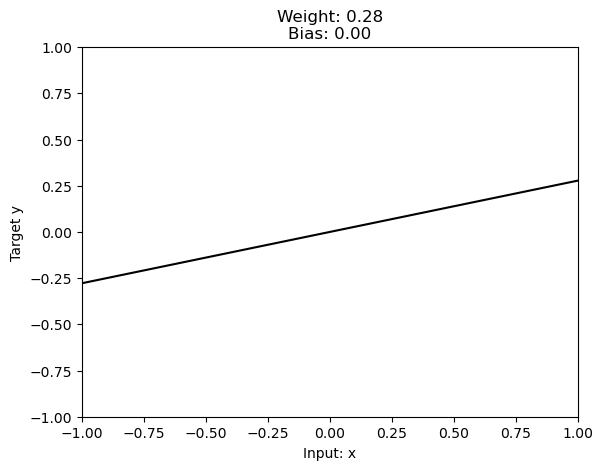

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt

model = keras.Sequential([
    layers.Dense(1, input_shape=[1]),
])

x = tf.linspace(-1.0, 1.0, 100)
y = model.predict(x)

plt.figure(dpi=100)
plt.plot(x, y, 'k')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Input: x")
plt.ylabel("Target y")
w, b = model.weights # you could also use model.get_weights() here
plt.title("Weight: {:0.2f}\nBias: {:0.2f}".format(w[0][0], b[0]))
plt.show()

##### Layers
Neural networks typically organize their neurons into layers. When we collect together linear units having a common set of inputs we get a dense layer.

A stack of three circles in an input layer connected to two circles in a dense layer.
A dense layer of two linear units receiving two inputs and a bias.
You could think of each layer in a neural network as performing some kind of relatively simple transformation. Through a deep stack of layers, a neural network can transform its inputs in more and more complex ways. In a well-trained neural network, each layer is a transformation getting us a little bit closer to a solution.


##### Many Kinds of Layers
A "layer" in Keras is a very general kind of thing. A layer can be, essentially, any kind of data transformation. Many layers, like the convolutional and recurrent layers, transform data through use of neurons and differ primarily in the pattern of connections they form. Others though are used for feature engineering or just simple arithmetic. There's a whole world of layers to discover -- check them out!

##### The Activation Function
It turns out, however, that two dense layers with nothing in between are no better than a single dense layer by itself. Dense layers by themselves can never move us out of the world of lines and planes. What we need is something nonlinear. What we need are activation functions.

 
Without activation functions, neural networks can only learn linear relationships. In order to fit curves, we'll need to use activation functions.
An activation function is simply some function we apply to each of a layer's outputs (its activations). The most common is the rectifier function  𝑚𝑎𝑥(0,𝑥)
 .
The rectifier function has a graph that's a line with the negative part "rectified" to zero. Applying the function to the outputs of a neuron will put a bend in the data, moving us away from simple lines.

When we attach the rectifier to a linear unit, we get a rectified linear unit or ReLU. (For this reason, it's common to call the rectifier function the "ReLU function".) Applying a ReLU activation to a linear unit means the output becomes max(0, w * x + b), which we might draw in a diagram like:
                                                                                        

##### Stacking Dense Layers
Now that we have some nonlinearity, let's see how we can stack layers to get complex data transformations.

An input layer, two hidden layers, and a final linear layer.
A stack of dense layers makes a "fully-connected" network.
The layers before the output layer are sometimes called hidden since we never see their outputs directly.

Now, notice that the final (output) layer is a linear unit (meaning, no activation function). That makes this network appropriate to a regression task, where we are trying to predict some arbitrary numeric value. Other tasks (like classification) might require an activation function on the output.

## Deep Neural Network

##### 1) Define a Model with Hidden Layers
Let's create a model with three hidden layers, each having 512 units and the ReLU activation. 

##### 2) Activation Layers #

Let's explore activations functions some.

The usual way of attaching an activation function to a `Dense` layer is to include it as part of the definition with the `activation` argument. Sometimes though you'll want to put some other layer between the `Dense` layer and its activation function. (We'll see an example of this in Lesson 5 with *batch normalization*.) In this case, we can define the activation in its own `Activation` layer, like so:

```
layers.Dense(units=8),
layers.Activation('relu')
```

This is completely equivalent to the ordinary way: `layers.Dense(units=8, activation='relu')`.

Rewrite the following model so that each activation is in its own `Activation` layer.

In [40]:
model = keras.Sequential([
    layers.Dense(units=512, input_shape=input_shape),
    layers.Activation('relu'),
    layers.Dense(units=512),
    layers.Activation('relu'),
    layers.Dense(units=512),
    layers.Activation('relu'),
    layers.Dense(1),
])


##### Optional: Alternatives to ReLU #

There is a whole family of variants of the `'relu'` activation -- `'elu'`, `'selu'`, and `'swish'`, among others -- all of which you can use in Keras. Sometimes one activation will perform better than another on a given task, so you could consider experimenting with activations as you develop a model. The ReLU activation tends to do well on most problems, so it's a good one to start with.

Let's look at the graphs of some of these. Change the activation from `'relu'` to one of the others named above. Then run the cell to see the graph. (Check out the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/activations) for more ideas.)

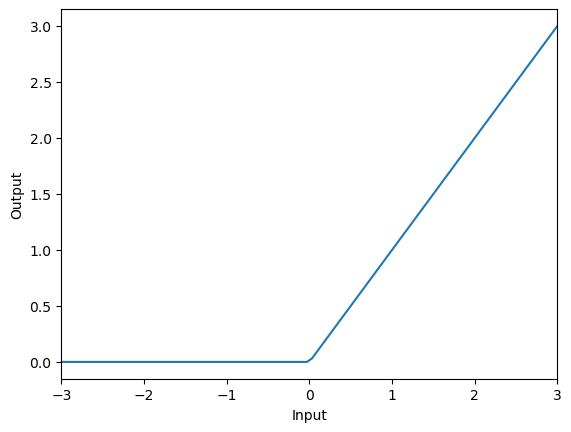

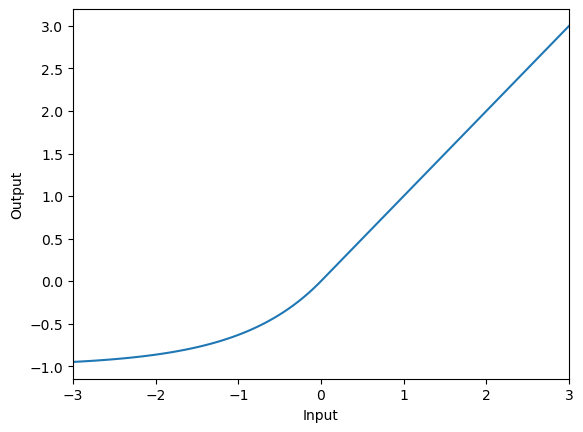

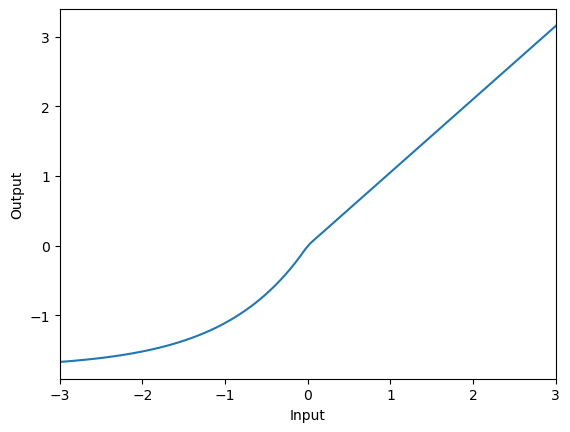

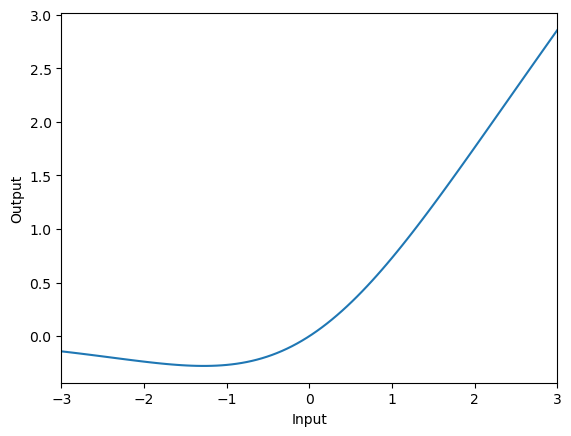

In [41]:
for acti in ['relu', 'elu', 'selu', 'swish'] :
    activation_layer = layers.Activation(acti)

    x = tf.linspace(-3.0, 3.0, 100)
    y = activation_layer(x) # once created, a layer is callable just like a function

    plt.figure(dpi=100)
    plt.plot(x, y)
    plt.xlim(-3, 3)
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.show()

## Stochastic Gradient Descent
##### Introduction
In the first two lessons, we learned how to build fully-connected networks out of stacks of dense layers. When first created, all of the network's weights are set randomly -- the network doesn't "know" anything yet. In this lesson we're going to see how to train a neural network; we're going to see how neural networks learn.

As with all machine learning tasks, we begin with a set of training data. Each example in the training data consists of some features (the inputs) together with an expected target (the output). Training the network means adjusting its weights in such a way that it can transform the features into the target. In the 80 Cereals dataset, for instance, we want a network that can take each cereal's 'sugar', 'fiber', and 'protein' content and produce a prediction for that cereal's 'calories'. If we can successfully train a network to do that, its weights must represent in some way the relationship between those features and that target as expressed in the training data.

In addition to the training data, we need two more things:

A "loss function" that measures how good the network's predictions are.
An "optimizer" that can tell the network how to change its weights.


##### The Loss Function
We've seen how to design an architecture for a network, but we haven't seen how to tell a network what problem to solve. This is the job of the loss function.

The loss function measures the disparity between the the target's true value and the value the model predicts.

Different problems call for different loss functions. We have been looking at regression problems, where the task is to predict some numerical value -- calories in 80 Cereals, rating in Red Wine Quality. Other regression tasks might be predicting the price of a house or the fuel efficiency of a car.

A common loss function for regression problems is the mean absolute error or MAE. For each prediction y_pred, MAE measures the disparity from the true target y_true by an absolute difference abs(y_true - y_pred).

The total MAE loss on a dataset is the mean of all these absolute differences.


Besides MAE, other loss functions you might see for regression problems are the mean-squared error (MSE) or the Huber loss (both available in Keras).

During training, the model will use the loss function as a guide for finding the correct values of its weights (lower loss is better). In other words, the loss function tells the network its objective.

##### The Optimizer - Stochastic Gradient Descent
We've described the problem we want the network to solve, but now we need to say how to solve it. This is the job of the optimizer. The optimizer is an algorithm that adjusts the weights to minimize the loss.

Virtually all of the optimization algorithms used in deep learning belong to a family called stochastic gradient descent. They are iterative algorithms that train a network in steps. One step of training goes like this:

* 1 Sample some training data and run it through the network to make predictions.
* 2 Measure the loss between the predictions and the true values.
* 3 Finally, adjust the weights in a direction that makes the loss smaller.
Then just do this over and over until the loss is as small as you like (or until it won't decrease any further.)



Each iteration's sample of training data is called a minibatch (or often just "batch"), while a complete round of the training data is called an epoch. The number of epochs you train for is how many times the network will see each training example.


##### Learning Rate and Batch Size
Notice that the line only makes a small shift in the direction of each batch (instead of moving all the way). The size of these shifts is determined by the learning rate. A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.

The learning rate and the size of the minibatches are the two parameters that have the largest effect on how the SGD training proceeds. Their interaction is often subtle and the right choice for these parameters isn't always obvious. (We'll explore these effects in the exercise.)

Fortunately, for most work it won't be necessary to do an extensive hyperparameter search to get satisfactory results. Adam is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is "self tuning", in a sense). Adam is a great general-purpose optimizer.

Adding the Loss and Optimizer
After defining a model, you can add a loss function and optimizer with the model's compile method:

model.compile(
    optimizer="adam",
    loss="mae",
)

##### Normalize the features and the target

In [52]:
X_full, y = select_features_and_target ( preprocessed_data_X_full, target = 'throughput' )
X_full = train_encoders_fit_transform(X_full, use_cache=False)
#X = X_full[features].copy()
#y ~= X_full['throughput']
#X_test = X_test_full[features].copy()
# Break off validation set from training data
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [58]:
max_ = X_train.max(axis=0)
min_ = X_train.min(axis=0)
X_train_normalized = ( X_train - min_ ) / (max_ - min_)
X_valid_normalized = ( X_valid - min_ ) / (max_ - min_)

In [60]:
ymax_ = y_train.max(axis=0)
ymin_ = y_train.min(axis=0)
y_train_normalized = ( y_train - ymin_ ) / (ymax_ - ymin_)
y_valid_normalized = ( y_valid - ymin_ ) / (ymax_ - ymin_)

In [56]:
display(X_train.head(4))


file_size  read_bytes  ipv6  operation_time  \
YmdHMS                                                              
2023-03-02 05:07:03  2621444713   804488712     1            1500   
2023-03-02 06:27:11   195108388   195108388     0              31   
2023-03-02 05:56:15   196579440   196579440     0              65   
2023-03-02 06:00:54   196579440   196579440     0              75   

                     read_btyes/file_size  
YmdHMS                                     
2023-03-02 05:07:03              0.306888  
2023-03-02 06:27:11              1.000000  
2023-03-02 05:56:15              1.000000  
2023-03-02 06:00:54              1.000000

In [59]:
display(X_train_normalized.head(4))

file_size  read_bytes  ipv6  operation_time  \
YmdHMS                                                             
2023-03-02 05:07:03   0.310698    0.077011   1.0        0.430871   
2023-03-02 06:27:11   0.015615    0.018677   0.0        0.008623   
2023-03-02 05:56:15   0.015794    0.018818   0.0        0.018396   
2023-03-02 06:00:54   0.015794    0.018818   0.0        0.021270   

                     read_btyes/file_size  
YmdHMS                                     
2023-03-02 05:07:03              0.151022  
2023-03-02 06:27:11              0.492109  
2023-03-02 05:56:15              0.492109  
2023-03-02 06:00:54              0.492109

In [61]:
X_train_normalized.shape

(8703, 5)

Five columns means eleven inputs.

We've chosen a three-layer network with over 1500 neurons. This network should be capable of learning fairly complex relationships in the data.

##### Build a Model

In [62]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train_normalized.shape[1]]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

Deciding the architecture of your model should be part of a process. Start simple and use the validation loss as your guide. You'll learn more about model development in the exercises.

After defining the model, we compile in the optimizer and loss function.

In [63]:
model.compile(
    optimizer='adam',
    loss='mae',
)

##### Train the Model
Now we're ready to start the training! We've told Keras to feed the optimizer 256 rows of the training data at a time (the batch_size) and to do that 10 times all the way through the dataset (the epochs).


In [64]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
34/34 [==============================] - 2s 21ms/step - loss: 48886280.0000 - val_loss: 8551673.0000
Epoch 2/10
34/34 [==============================] - 0s 14ms/step - loss: 9323735.0000 - val_loss: 5566785.5000
Epoch 3/10
34/34 [==============================] - 1s 16ms/step - loss: 6660663.0000 - val_loss: 5546596.0000
Epoch 4/10
34/34 [==============================] - 0s 14ms/step - loss: 6630496.0000 - val_loss: 6805495.5000
Epoch 5/10
34/34 [==============================] - 0s 14ms/step - loss: 6534600.5000 - val_loss: 6826985.5000
Epoch 6/10
34/34 [==============================] - 0s 14ms/step - loss: 6315545.0000 - val_loss: 6107245.0000
Epoch 7/10
34/34 [==============================] - 1s 15ms/step - loss: 6151304.0000 - val_loss: 5304839.5000
Epoch 8/10
34/34 [==============================] - 0s 14ms/step - loss: 5765842.0000 - val_loss: 5060548.5000
Epoch 9/10
34/34 [==============================] - 0s 15ms/step - loss: 5591912.0000 - val_loss: 5011549.0000


You can see that Keras will keep you updated on the loss as the model trains.

##### Plot the Loss
Often, a better way to view the loss though is to plot it. The fit method in fact keeps a record of the loss produced during training in a History object. We'll convert the data to a Pandas dataframe, which makes the plotting easy.

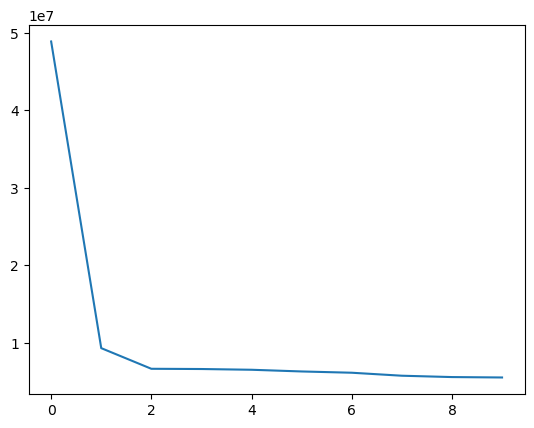

In [65]:
import pandas as pd

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

Notice how the loss levels off as the epochs go by. When the loss curve becomes horizontal like that, it means the model has learned all it can and there would be no reason continue for additional epochs.

Evaluate Training

If you trained the model longer, would you expect the loss to decrease further?

This depends on how the loss has evolved during training: if the learning curves have levelled off, there won't usually be any advantage to training for additional epochs. Conversely, if the loss appears to still be decreasing, then training for longer could be advantageous.



With the learning rate and the batch size, you have some control over:
- How long it takes to train a model
- How noisy the learning curves are
- How small the loss becomes

To get a better understanding of these two parameters, we'll look at the linear model, our ppsimplest neural network. Having only a single weight and a bias, it's easier to see what effect a change of parameter has.

The next cell will generate an animation like the one in the tutorial. Change the values for `learning_rate`, `batch_size`, and `num_examples` (how many data points) and then run the cell. (It may take a moment or two.) Try the following combinations, or try some of your own:


In [66]:
parameters = [ {'learning_rate': 0.05, 'batch_size': 32, 'num_examples': 256}, {'learning_rate': 0.05, 'batch_size': 2, 'num_examples': 256}, {'learning_rate': 0.05, 'batch_size': 128, 'num_examples': 256}, {'learning_rate': 0.02, 'batch_size': 32, 'num_examples': 256}, {'learning_rate': 0.2, 'batch_size': 32, 'num_examples': 256}, {'learning_rate': 1.0, 'batch_size': 32, 'num_examples': 256}, {'learning_rate': 0.9, 'batch_size': 4096, 'num_examples': 8192}, {'learning_rate': 0.99, 'batch_size': 4096, 'num_examples': 8192}]
#for parameter in parameters :
from learntools.deep_learning_intro.dltools import animate_sgd


In [67]:
for parameter in parameters :
    print (parameter)
    learning_rate = parameter['learning_rate']
    batch_size = parameter['batch_size']
    num_examples = parameter['num_examples']
    animate_sgd(
        learning_rate=learning_rate,
        batch_size=batch_size,
        num_examples=num_examples,
        # You can also change these, if you like
        steps=50, # total training steps (batches seen)
        true_w=3.0, # the slope of the data
        true_b=2.0, # the bias of the data
    )

{'learning_rate': 0.05, 'batch_size': 32, 'num_examples': 256}
{'learning_rate': 0.05, 'batch_size': 2, 'num_examples': 256}
{'learning_rate': 0.05, 'batch_size': 128, 'num_examples': 256}
{'learning_rate': 0.02, 'batch_size': 32, 'num_examples': 256}
{'learning_rate': 0.2, 'batch_size': 32, 'num_examples': 256}
{'learning_rate': 1.0, 'batch_size': 32, 'num_examples': 256}
{'learning_rate': 0.9, 'batch_size': 4096, 'num_examples': 8192}
{'learning_rate': 0.99, 'batch_size': 4096, 'num_examples': 8192}


##### Adding Early Stopping

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

These parameters say: "If there hasn't been at least an improvement of 0.001 in the validation loss over the previous 20 epochs, then stop the training and keep the best model you found." It can sometimes be hard to tell if the validation loss is rising due to overfitting or just due to random batch variation. The parameters allow us to set some allowances around when to stop.

As we'll see in our example, we'll pass this callback to the fit method along with the loss and optimizer.

In [69]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)

Minimum validation loss: 4811019.5


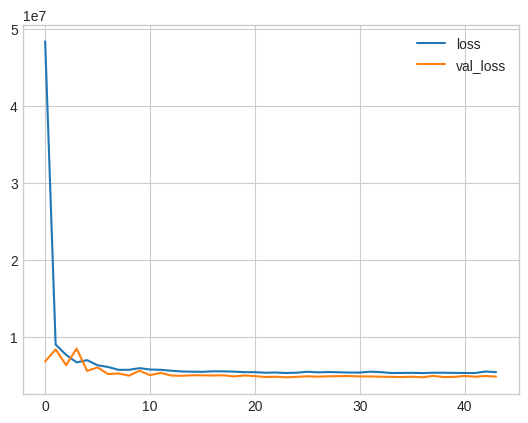

In [70]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Minimum validation loss: 4688280.0


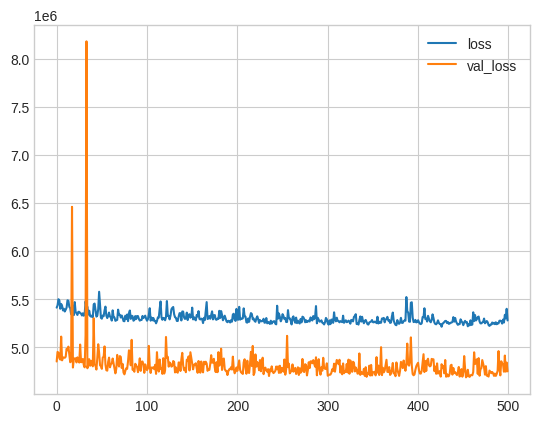

In [71]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    #callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##### Dropout
The first of these is the "dropout layer", which can help correct overfitting.

In the last lesson we talked about how overfitting is caused by the network learning spurious patterns in the training data. To recognize these spurious patterns a network will often rely on very a specific combinations of weight, a kind of "conspiracy" of weights. Being so specific, they tend to be fragile: remove one and the conspiracy falls apart.

This is the idea behind dropout. To break up these conspiracies, we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust.


##### Batch Normalization
The next special layer we'll look at performs "batch normalization" (or "batchnorm"), which can help correct training that is slow or unstable.

With neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's StandardScaler or MinMaxScaler. The reason is that SGD will shift the network weights in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.

Now, if it's good to normalize the data before it goes into the network, maybe also normalizing inside the network would be better! In fact, we have a special kind of layer that can do this, the batch normalization layer. A batch normalization layer looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batchnorm, in effect, performs a kind of coordinated rescaling of its inputs.

Most often, batchnorm is added as an aid to the optimization process (though it can sometimes also help prediction performance). Models with batchnorm tend to need fewer epochs to complete training. Moreover, batchnorm can also fix various problems that can cause the training to get "stuck". Consider adding batch normalization to your models, especially if you're having trouble during training.



In [93]:
model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    #layers.BatchNormalization(),
    layers.Dense(1),
])


<AxesSubplot: >

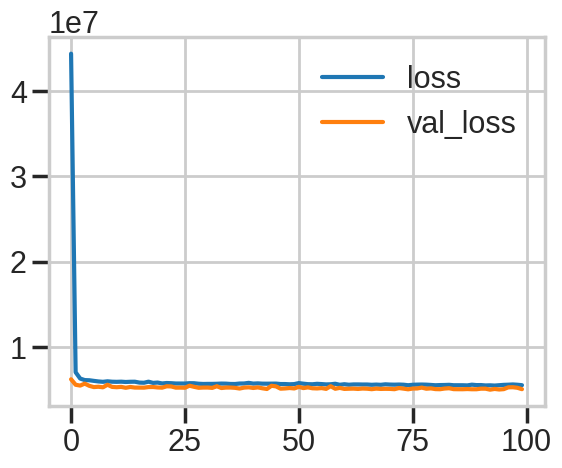

In [94]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

You'll typically get better performance if you standardize your data before using it for training. That we were able to use the raw data at all, however, shows how effective batch normalization can be on more difficult datasets.

##### Save the Trained Model

In [74]:
model_json = model.to_json()
with open("sequential_dropout_batch_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("sequential_dropout_batch_model.h5")

In [76]:
!file sequential*

sequential_dropout_batch_model.h5:   Hierarchical Data Format (version 5) data
sequential_dropout_batch_model.json: ASCII text, with very long lines, with no line terminators


In [77]:
from keras.models import Sequential,Model,model_from_json
def load_keras_sequential_model(json_file_name = "sequential_dropout_batch_model.json",
                                h5_weight_file = "sequential_dropout_batch_model.h5" ):
    try:
        get_ipython().system('ls -al '+ json_file_name )
        json_file = open(json_file_name, 'r')
        print ("INFO " + json_file_name + " opened")
    except:
        return None
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    try:
        # load weights into new model
        get_ipython().system('ls -al ' + h5_weight_file )
        loaded_model.load_weights(h5_weight_file)
        print ("INFO " + h5_weight_file + " loaded")
    except:
        return None
    print("Loaded model from disk")
    loaded_model.compile(loss="mse", optimizer="adam")
    print('Model model compiled!!')
    return loaded_model

## Prediction of Throughput

In [78]:
X_test_full, throughput = select_features_and_target ( preprocessed_data_X_test_full, target = 'throughput' )
X_test_full = train_encoders_fit_transform(X_test_full, use_cache=False)
data = X_test_full[features].copy()

In [96]:
throughput_pred = model.predict(data,batch_size=256, verbose=1)

11/11 [==============================] - 0s 10ms/step


In [123]:
#plt.plot(throughput_pred)
#plt.show()

#X_test_full, throughput = select_features_and_target ( preprocessed_data_X_test_full, target = 'throughput' )
#X_test_full = train_encoders_fit_transform(X_test_full, use_cache=False)
#X_full, y
#X_full, y = select_features_and_target ( preprocessed_data_X_full, target = 'throughput' )
#X_full = train_encoders_fit_transform(X_full, use_cache=False)

data_full = X_full[features].copy()
throughput_full_pred = model.predict(data_full,batch_size=256, verbose=1)

43/43 [==============================] - 0s 10ms/step


In [119]:
len(throughput.to_numpy())

2814

In [120]:
len(throughput_pred)

2814

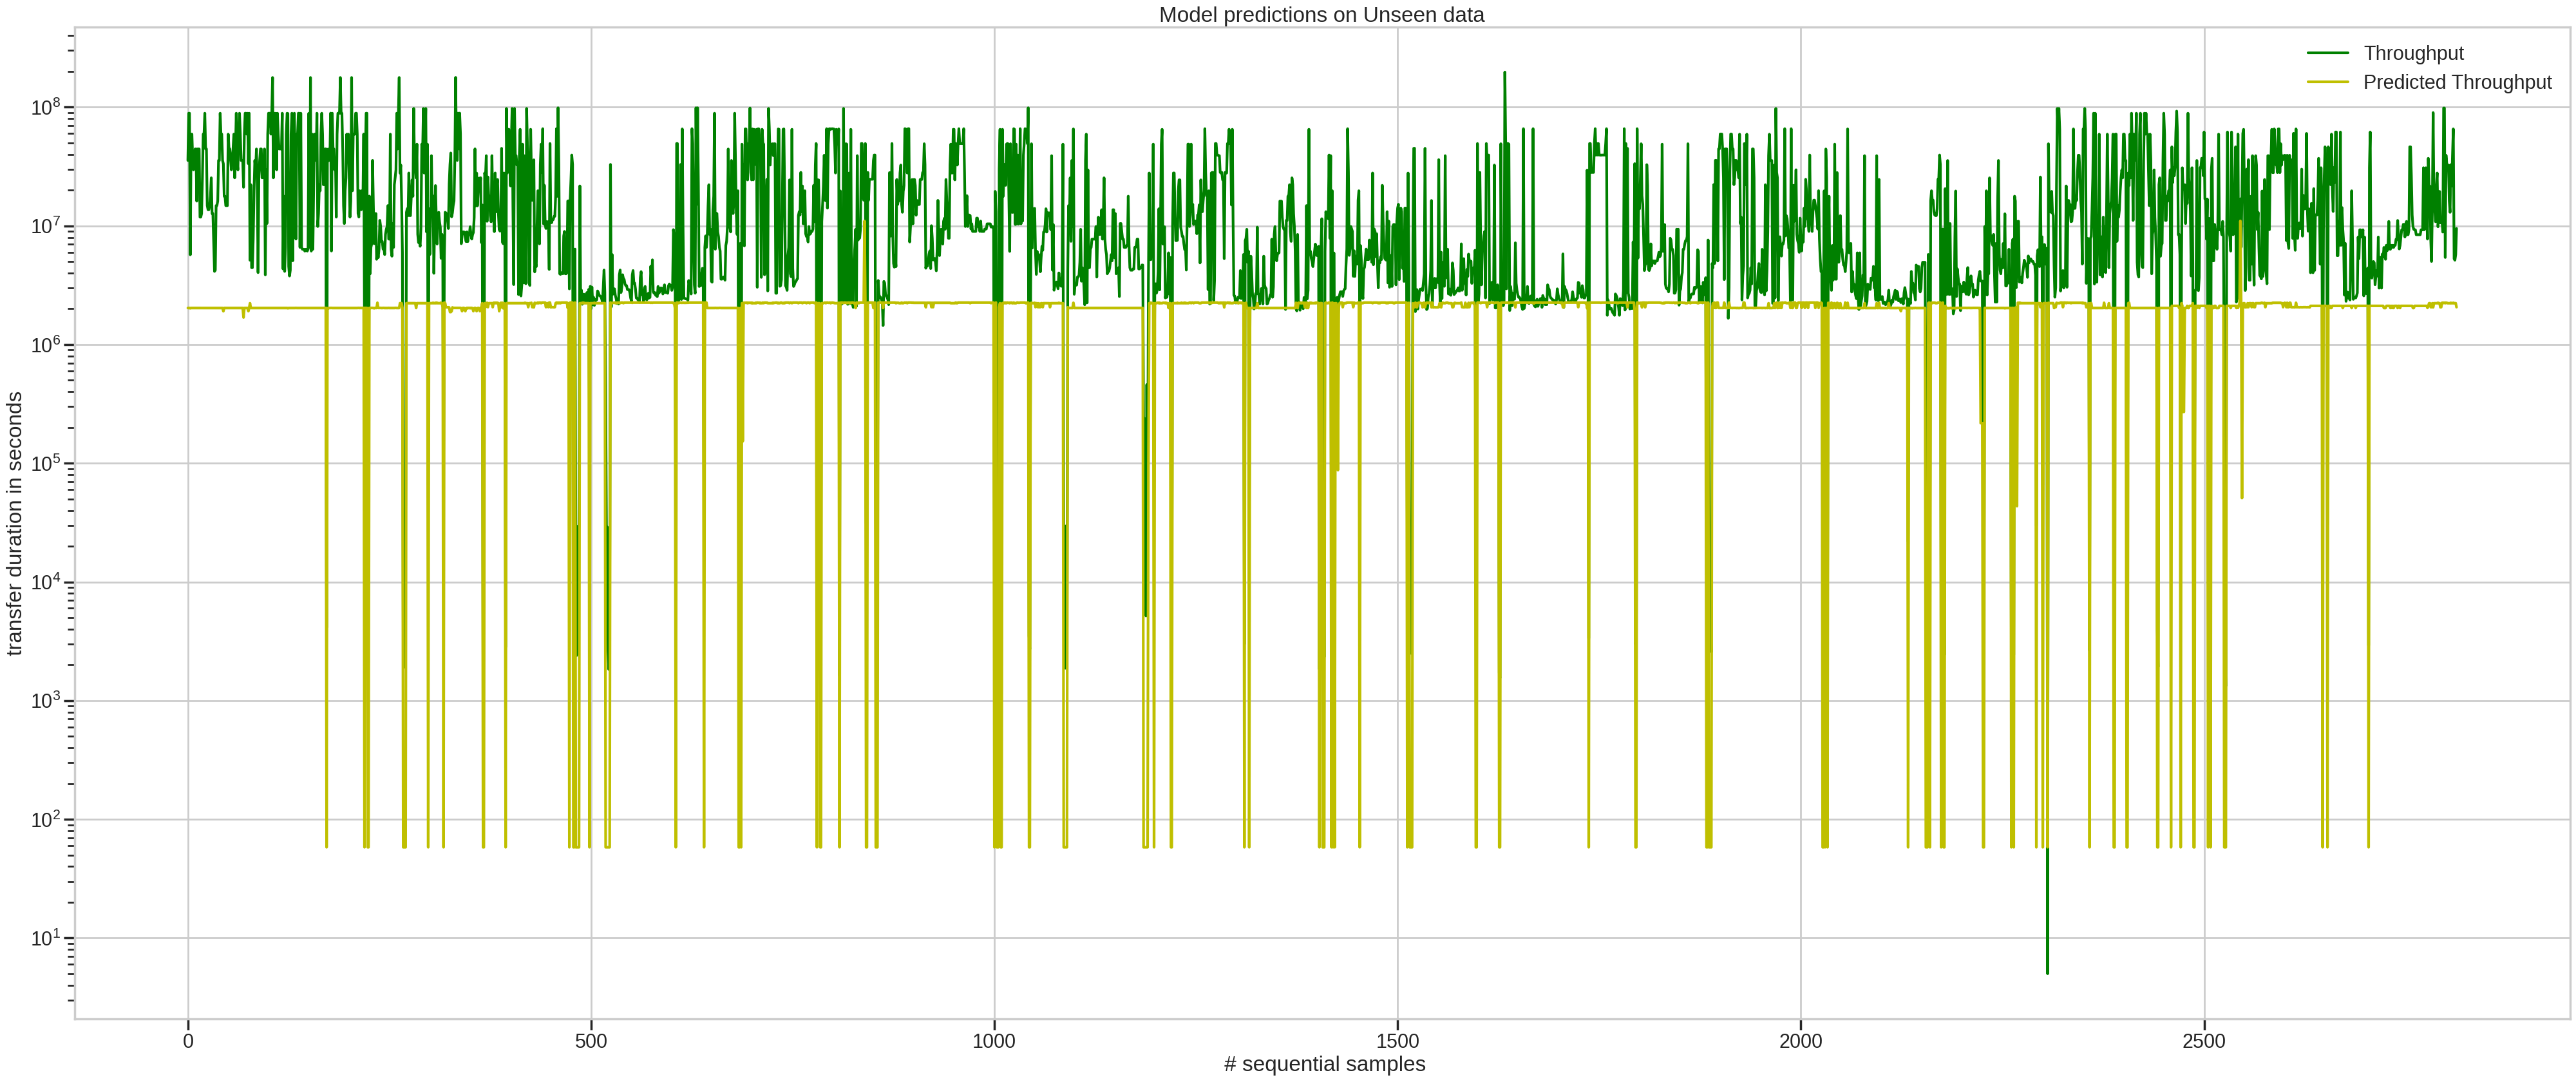

In [122]:
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(throughput.to_numpy(), 'g', label='Throughput')
plt.plot(throughput_pred, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

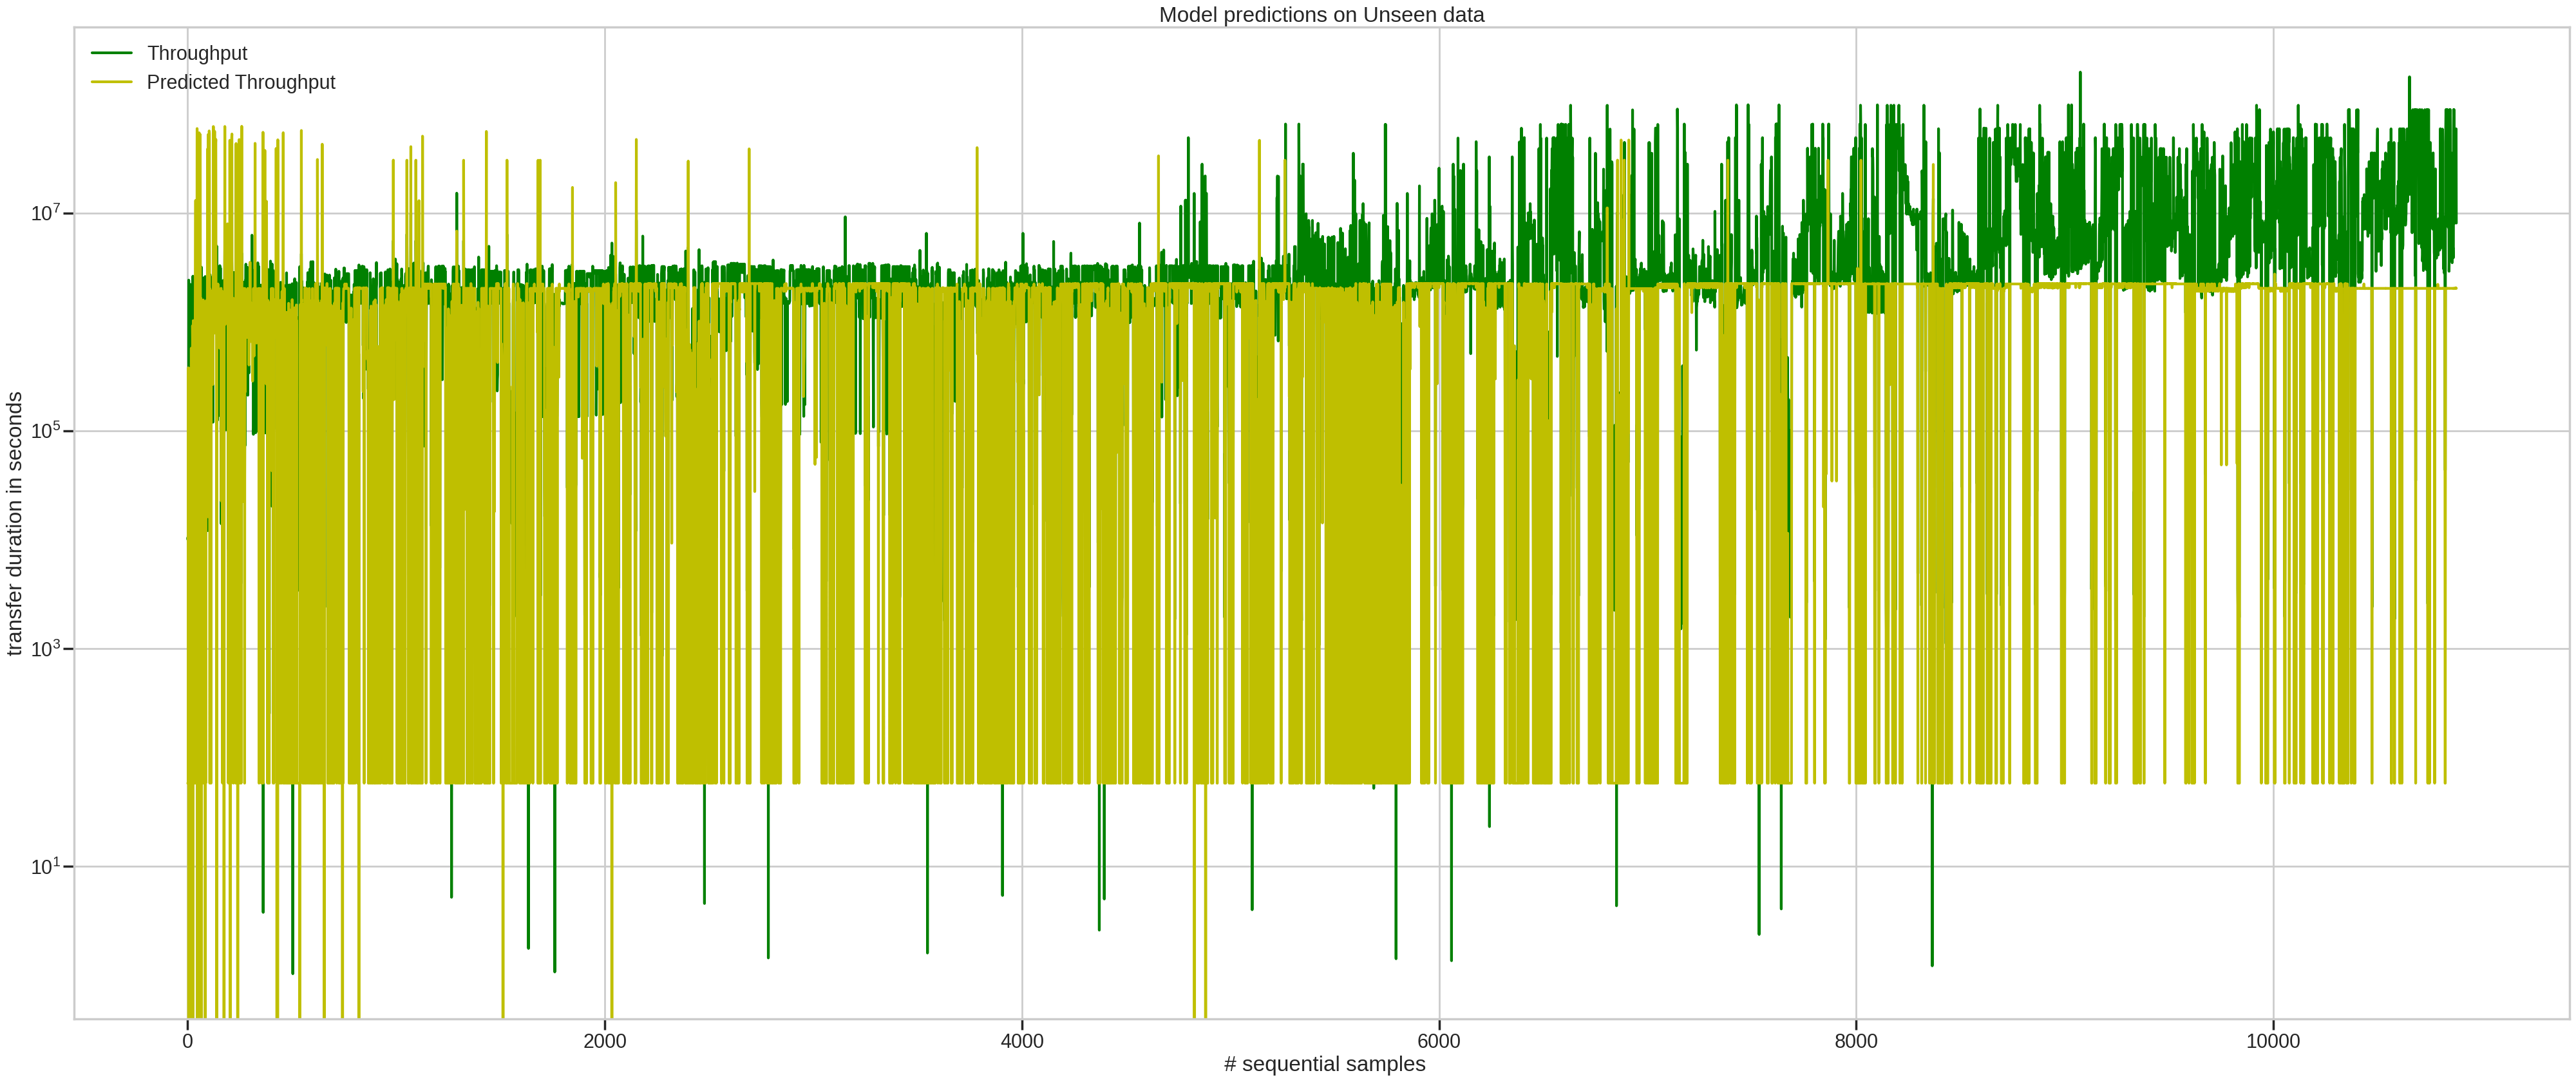

In [124]:

data_full = X_full[features].copy()
throughput_full_pred = model.predict(data_full,batch_size=256, verbose=1)
sns.set_context('poster')

plt.figure(figsize=(50,20))
plt.plot(y.to_numpy(), 'g', label='Throughput')
plt.plot(throughput_full_pred, 'y', label='Predicted Throughput')
plt.title('Model predictions on Unseen data')
plt.legend()
plt.xlabel(' # sequential samples')
plt.ylabel('transfer duration in seconds')
plt.yscale("log")
plt.show()

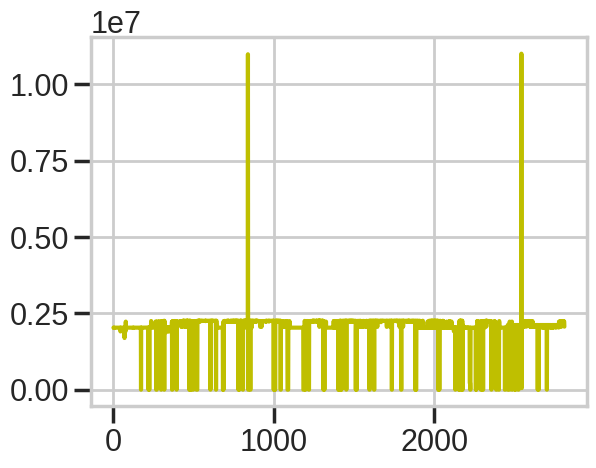

In [116]:
plt.plot(throughput_pred, 'y', label='Predicted Throughput')
plt.show()

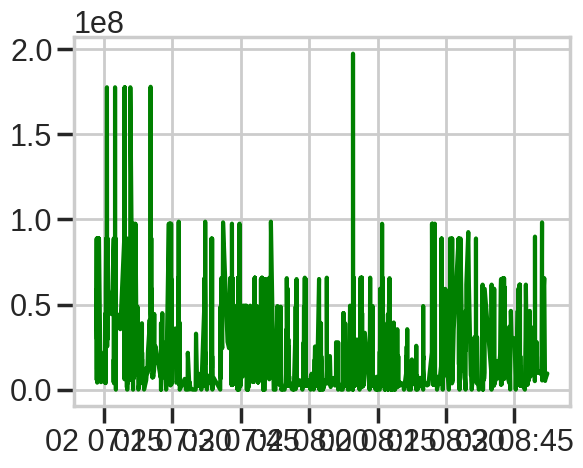

In [115]:
plt.plot(throughput, 'g', label='Throughput')
#plt.plot(throughput_pred, 'y', label='Predicted Throughput')
plt.show()

In [113]:
model.evaluate(data, throughput, verbose=2)

88/88 - 0s - loss: 15308882.0000 - 352ms/epoch - 4ms/step


15308882.0

# Where do I go from here?

##### https://datascience103579984.wordpress.com/2020/01/31/introduction-to-deep-learning-with-keras-from-datacamp/

##### https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/